<a href="https://colab.research.google.com/github/juan-villa02/medical_vqa_vlm/blob/main/code/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA Model - BERT + ResNet18

## Libraries/Dependencies

In [1]:
# # Install dependencies for local running
# !pip install torch
# !pip install torchvision
# !pip install PIL
# !pip install skimage
# !pip install scipy
# !pip install transformers
# !pip install bertviz
# !pip install seaborn
# !pip install matplotlib
# !pip install numpy
# !pip install tqdm
# !pip install zipfile

In [2]:
# PyTorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils
# Image and mask handling
from PIL import Image
from skimage import transform
import scipy.io as sio
# Transformers (Hugginface)
from transformers import AutoTokenizer, BertForQuestionAnswering, VisualBertModel, VisualBertForQuestionAnswering, VisualBertConfig
# Attention visualization
#from bertviz import head_view
import seaborn as sns
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Extra dependencies
import json
import os
from tqdm import tqdm
import zipfile
from google.colab import files

In [3]:
# Set training device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Paths & Data Extraction

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_dir = '.'
path_dir = '/content/drive/MyDrive/TFG Juan Villanueva/databases_qa.zip'

In [6]:
# Data folder
data_folder = './data/'

In [7]:
# ISIC_2016 database
train_ISIC_path = 'databases_qa/ISIC_2016'

In [8]:
# def filter_json(json_file, images_dir, output_file):
#    filtered_data = []

#    with open(json_file, 'r') as f:
#        data = json.load(f)

#        for item in data:
#            image_id = item['image_id'] + '.jpg'
#            image_path = os.path.join(images_dir, image_id)

#            # Check if the image file exists
#            if os.path.exists(image_path):
#                filtered_data.append(item)

#    # Write the filtered data to the output JSON file
#    with open(output_file, 'w') as f:
#        json.dump(filtered_data, f, indent=4)

#    return

In [9]:
# json_file = '/content/data/databases_qa/ISIC_2016/qa_ISIC.json'
# images_dir = '/content/data/databases_qa/ISIC_2016/images/ISBI2016_ISIC_Part1_Test_Data_orig'
# output_file = 'qa_filtered_ISIC.json'
# filter_json(json_file, images_dir, output_file)

In [10]:
# ISIC_2016 database (images and masks)
train_extra_ISIC_path = 'ISBI2016_ISIC_Part3_Training_Data_orig'

In [11]:
# Pizarro database (images)
pizarro_path = 'databases_qa/pizarro'

In [12]:
# Function to extract databases from the main zip file
def extract_databases(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [13]:
# Extract all databases from the main zip file
if path_dir != '.':
  extract_databases(path_dir, data_folder)

In [14]:
# ISIC_2016 images
database1_path = os.path.join(data_folder, train_ISIC_path)

In [15]:
# Pizarro images
# 500 imágenes; Las 46 primeras son más complejas, en cuanto a diagnóstico. (Entrega 1) El resto están más equilibradas (Entrega 2-5)
database2_path = os.path.join(data_folder, pizarro_path)

## VQA Dataset - Images, Masks, & QA

In [16]:
# Dataset class to load images and questions
class VQADataset(Dataset):
    def __init__(self, data_dir, json_file, tokenizer=None, transform=None, extraPath=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.masks_dir = os.path.join(self.data_dir, 'masks')

        # Handle special ISIC data folder
        self.extraPath = extraPath
        if self.extraPath is not None:
            self.images_dir = os.path.join(self.images_dir, self.extraPath)
            self.masks_dir = os.path.join(self.masks_dir, self.extraPath)

        self.transform = transform
        self.tokenizer = tokenizer

        with open(json_file, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item['image_id'])

        # Ensure the image ID ends with ".jpg"
        if not image_path.endswith(".jpg"):
            image_path += ".jpg"

        # Check if the image is available
        try:
          image = Image.open(image_path).convert('RGB')

          # Case 1: Pizarro dataset
          if self.extraPath is None:
            mask_id = item['image_id'].split('.')[0]
            mask_name = 'L' + mask_id + '.pgm'
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path)

          # Case 2: ISIC dataset
          else:
            mask_path = os.path.join(self.masks_dir, item['image_id']) + '_Segmentation.png'
            mask = Image.open(mask_path)

          if self.transform:
              image, mask = self.transform((image, mask))

          # Store questions and answers in two different arrays
          qa_pairs = item['qa_pairs']
          questions = [qa['question'] for qa in qa_pairs]
          answers = [qa['answer'] for qa in qa_pairs]

        except FileNotFoundError as e:

          image = None
          mask = None
          questions = None
          answers = None

        return image, mask, questions, answers

## Load pre-trained ResNet18

In [17]:
# Load ResNet-18 model from .pth file
def load_resnet(path, optimizer=None, scheduler=None):
    resnet = models.resnet18()
    # Remove final fully connected layer and avg pooling (we do not want the model to return labels but features with dimension)
    resnet.fc = nn.Identity()
    resnet.avgpool = nn.Identity()

    # Load the weights
    state_dict = torch.load(path, map_location=device)['state_dict']

    # Remove unexpected keys if they exist
    unexpected_keys = ['fc.weight', 'fc.bias']
    for key in unexpected_keys:
        if key in state_dict:
            del state_dict[key]

    # Load the weights
    resnet.load_state_dict(state_dict)
    resnet.eval()

    if optimizer is not None:
        optimizer.load_state_dict(torch.load(path)['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(path)['scheduler'])

    resnet.to(device)

    return resnet, optimizer, scheduler

In [18]:
model_source_path = '/content/drive/MyDrive/TFG Juan Villanueva/codigo diagnostico/bestdiagNet.pth'

In [19]:
resnet, optimizer, scheduler = load_resnet(model_source_path)

In [20]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Transformations

In [21]:
class CropByMask(object):
    """Recortamos la imagen usando la máscara de la lesión.

    Args:
        border (tupla o int): El borde de recorte alrededor de la máscara. Es sabido que el análisis del borde
        de la lesión con la piel circudante es importante para los dermatólogos, por lo que puede ser interesante
        dejar una guarda.
        Si es una tupla, entonces es (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):

        image, mask = np.array(sample[0]), np.array(sample[1])

        h, w = image.shape[:2]
        #Calculamos los índices del bounding box para hacer el cropping
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Recortamos la imagen
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return image, mask

In [22]:
class Rescale(object):
    """Rescales the image to a desired size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is the output_size.
            If int, the smaller of the image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):

        image_np, mask_np = sample[0], sample[1]

        # Get the height and width of the image
        h, w = image_np.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # Resize the image using scikit-image's resize function
        resized_image = transform.resize(image_np, (new_h, new_w))
        resized_mask = transform.resize(mask_np, (new_h, new_w))

        # Convert the resized NumPy array back to a PIL image
        resized_image_pil = Image.fromarray((resized_image * 255).astype(np.uint8))
        resized_mask_pil = Image.fromarray((resized_mask * 255).astype(np.uint8))

        #return resized_image_pil, resized_mask_pil
        return resized_image, resized_mask

In [23]:
class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return image, mask

In [24]:
class ToTensor(object):
    """Converts the image ndarray to a tensor."""

    def __call__(self, sample):

        image, mask = sample[0], sample[1]
        # Change the axes
        # numpy image: H x W x C
        # torch image: C x H x W
        # image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)

        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)

        return image, mask


In [25]:
class Normalize(object):
    """Normalizes the image by subtracting the mean and dividing by the standard deviations.

    Args:
        mean: The vector containing the means.
        std: The vector containing the standard deviations.
    """

    def __init__(self, mean, std):
        assert len(mean) == len(std), 'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        # c, h, w = image.shape
        # assert c==len(self.mean), 'Length of mean and image is not the same'

        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        # Normalize the image
        # image = (image - mean[:, None, None]) / std[:, None, None]
        image.sub_(mean[:, None, None]).div_(std[:, None, None])

        return image, mask

In [26]:
# ISIC Dataset------------------------------------------------------------
dataset_isic = VQADataset(data_dir=database1_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_filtered_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]),
                            extraPath=train_extra_ISIC_path)

In [27]:
# Pizarro Dataset------------------------------------------------------------
dataset_pizarro = VQADataset(data_dir=database2_path,
                           json_file='/content/data/databases_qa/pizarro/qa_pizarro.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

In [28]:
# Split into training and test (no validation dataset since the optimal training parameters
# are suggested in the VisualBert paper) -> 80% train, 20% test
train_size_isic = int(0.8 * len(dataset_isic))
test_size_isic = len(dataset_isic) - train_size_isic
train_size_pizarro = int(0.8 * len(dataset_pizarro))
test_size_pizarro = len(dataset_pizarro) - train_size_pizarro

In [29]:
# Set the random seed for reproducibility
torch.manual_seed(42)
# Split the ISIC dataset into training and testing subsets
train_dataset_isic, test_dataset_isic = random_split(dataset_isic, [train_size_isic, test_size_isic])
# Split the Pizarro dataset into training and testing subsets
train_dataset_pizarro, test_dataset_pizarro = random_split(dataset_pizarro, [train_size_pizarro, test_size_pizarro])

## Define the all the possible answers within both datasets

In [30]:
# Extract all answers from both datasets
all_answers_pizarro = [answer for _, _, _, answers in train_dataset_pizarro for answer in answers]
all_answers_isic = [answer for _, _, _, answers in train_dataset_isic for answer in answers]
all_answers_pizarro_test = [answer for _, _, _, answers in test_dataset_pizarro for answer in answers]
all_answers_isic_test = [answer for _, _, _, answers in test_dataset_isic for answer in answers]
# Combine answers from both datasets
all_answers_combined = all_answers_pizarro + all_answers_isic + all_answers_pizarro_test + all_answers_isic_test
# Obtain unique answer values
unique_answers = list(set(all_answers_combined))

In [31]:
unique_answers

['The global pattern of the lesion is undefined.',
 'The lesion appears to be malignant.',
 'The diagnostic difficulty level is low.',
 'Yes, clear and dominant undefined area is observed.',
 'Yes, clear and dominant negative reticulum is observed.',
 'Yes, subtle homogeneous area without vessels is observed.',
 'Yes, clear small dots/globules are present.',
 'The histology diagnostic indicates non-atypical stable mole (m).',
 'The general silhouette of the lesion is exophytic.',
 'The presence of dysplasia is .',
 'Yes, clear and dominant large globules/cobblestone are observed.',
 'No homogeneous area with vessels is observed.',
 'The lesion appears to be benign.',
 'The histology diagnostic indicates lentiginous melanocytic nevus (lmn).',
 'Yes, clear peripheral globules are observed.',
 'The diagnostic impression is exclude melanoma.',
 'Yes, subtle negative reticulum is observed.',
 'The peripheral globular pattern is regular conventional.',
 'Yes, clear and dominant homogeneous a

In [32]:
# Create dictionaries id2label and label2id
id2label = {i: label for i, label in enumerate(unique_answers)}
label2id = {label: i for i, label in enumerate(unique_answers)}

In [33]:
id2label

{0: 'The global pattern of the lesion is undefined.',
 1: 'The lesion appears to be malignant.',
 2: 'The diagnostic difficulty level is low.',
 3: 'Yes, clear and dominant undefined area is observed.',
 4: 'Yes, clear and dominant negative reticulum is observed.',
 5: 'Yes, subtle homogeneous area without vessels is observed.',
 6: 'Yes, clear small dots/globules are present.',
 7: 'The histology diagnostic indicates non-atypical stable mole (m).',
 8: 'The general silhouette of the lesion is exophytic.',
 9: 'The presence of dysplasia is .',
 10: 'Yes, clear and dominant large globules/cobblestone are observed.',
 11: 'No homogeneous area with vessels is observed.',
 12: 'The lesion appears to be benign.',
 13: 'The histology diagnostic indicates lentiginous melanocytic nevus (lmn).',
 14: 'Yes, clear peripheral globules are observed.',
 15: 'The diagnostic impression is exclude melanoma.',
 16: 'Yes, subtle negative reticulum is observed.',
 17: 'The peripheral globular pattern is r

In [34]:
# Required tensor with the label IDs
answers_ids_tensor = torch.arange(len(id2label), dtype=torch.float, device=device)
answers_ids_tensor

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103.], device='cuda:0')

In [35]:
# Train Dataloaders
train_pizarro_dataloader = DataLoader(train_dataset_pizarro, batch_size=5, shuffle=True)
train_isic_dataloader = DataLoader(train_dataset_isic, batch_size=5, shuffle=True)
# Test Dataloaders
test_pizarro_dataloader = DataLoader(test_dataset_pizarro, batch_size=5, shuffle=True)
test_isic_dataloader = DataLoader(test_dataset_isic, batch_size=5, shuffle=True)

In [36]:
# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Show a batch of images."""

    # Store images, questions and answers
    images_batch, masks_batch, questions_batch, answers_batch = \
            sample_batched[0], sample_batched[1], sample_batched[2], sample_batched[3]

    # Identify the batch size to define the grid
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # Generate the grid
    grid = utils.make_grid(images_batch)

    # Convert to numpy and denormalize
    grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

0 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

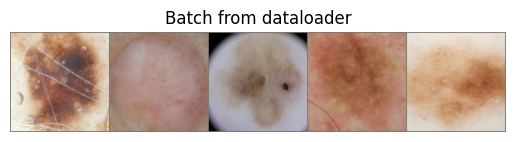

1 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

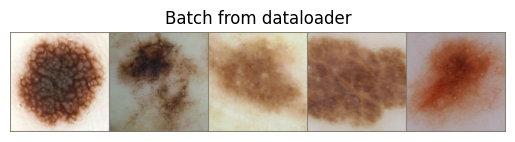

In [37]:
# Iterate over the dataloader and visualize batches
for i_batch, sample_batched in enumerate(train_isic_dataloader):
    print(i_batch, sample_batched[2])
    show_batch(sample_batched)

    # Show only the data of the 3rd batch and stop.
    if i_batch == 1:
        break

## Image Feature Extraction

In [38]:
def extract_image_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataloader.dataset)

    output_shape = (7,7,512) # Keep dimensionality of outputs (layer 4)

    # Calculate the total number of features
    num_features = np.prod(output_shape)

    features = np.zeros((num_samples, *output_shape), dtype=np.float32)
    sample_idx = 0

    with torch.no_grad():
        for sample in dataloader:
            # Get images
            inputs = sample[0].to(device).float()

            # Forward pass
            outputs = model(inputs)

            outputs_reshaped = outputs.reshape(outputs.size(0), *output_shape)

            # Store features
            batch_size = inputs.size(0)
            # features[sample_idx:sample_idx + batch_size, :] = outputs_flat.cpu().numpy()
            features[sample_idx:sample_idx + batch_size, :] = outputs_reshaped.cpu().numpy()
            sample_idx += batch_size

    return torch.tensor(features, device=device)

In [39]:
# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

## VQA Model Creation

In [40]:
class VQAModel(nn.Module):
    def __init__(self, resnet, vlm, tokenizer):
        super(VQAModel, self).__init__()

        # Pre-trained ResNet model
        self.resnet = resnet
        # Vision Language Model
        self.vlm = vlm
        # Tokenizer
        self.tokenizer = tokenizer
        # Freeze parameters of the ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, image_features, question, labels_idxs=None, training=False):

        # image_features -> array with visual features for the specific image (7x7x512)
        # question -> individual question within the image batch
        # labels_idx -> tensor with shape (0, ..., num_labels-1)
        # training; boolean to determine the mode (train/evaluation)

        # Prepare image inputs -> (batch_size, visual_seq_length, visual_embedding_dim)
        flattened_embedding = image_features.view(-1, 512) # (49x512)
        visual_embeds = flattened_embedding.unsqueeze(0) # (1x49x512)

        # Token type and attention masks -> (batch_size, visual_seq_length)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float, device=device)

        # Tokenize question
        tokenized_question = self.tokenizer(question,
                                            return_token_type_ids=True,
                                            return_attention_mask=True,
                                            add_special_tokens=True,
                                            return_tensors='pt')

        # Input for the VLM model (refer to VisualBert to understand the shapes)
        input_dict = {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
            "input_ids": tokenized_question['input_ids'].to(device),
            "token_type_ids": tokenized_question['token_type_ids'].to(device),
            "attention_mask": tokenized_question['attention_mask'].to(device),
        }

        # Training mode: track gradients
        if training:

            output = self.vlm(**input_dict, labels=labels_idxs)
            logits = output.logits
            loss = output.loss
            attentions = output.attentions

            del output

        # Evaluation mode: no gradients
        else:
            with torch.no_grad():
                output = self.vlm(**input_dict, labels=labels_idxs)
                logits = output.logits
                loss = output.loss
                attentions = output.attentions

        # # Check for memory usage
        # print_gpu_memory()

        return logits, loss, attentions

### Define LLM & Tokenizer

In [61]:
# Pre-trained base case for VQA provided in documentation
# tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
# bertModel = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Modify the visual embedding config so that size of the features matches
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa",
                                                 visual_embedding_dim=512,
                                                 num_labels=answers_ids_tensor.shape[0],
                                                 output_attentions=True)
visualBert = VisualBertForQuestionAnswering(configuration)

## Training Loop

In [62]:
# Create the VQA Model and pass it to the GPU
vqa_model = VQAModel(resnet, visualBert, tokenizer)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqa_model.to(device)

VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [64]:
# Define hyperparameters
learning_rate = 5e-5
num_epochs = 10

In [65]:
# Define optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, vqa_model.parameters()), lr=learning_rate)

In [66]:
# Extract all image features for the dataloaders
with torch.no_grad():
    # Train
    image_features_isic = extract_image_features(vqa_model.resnet, train_isic_dataloader)
    image_features_pizarro = extract_image_features(vqa_model.resnet, train_pizarro_dataloader)
    # Test
    image_features_isic_test = extract_image_features(vqa_model.resnet, test_isic_dataloader)
    image_features_pizarro_test = extract_image_features(vqa_model.resnet, test_pizarro_dataloader)

In [67]:
# Train
image_features_dataloaders = [image_features_isic, image_features_pizarro]
dataloaders = [train_isic_dataloader, train_pizarro_dataloader]
# Test
image_features_dataloaders_test = [image_features_isic_test, image_features_pizarro_test]
dataloaders_test = [test_isic_dataloader, test_pizarro_dataloader]

### Backward pass per question

In [48]:
# def train(model, dataloaders, image_features_dataloaders, num_epochs, optimizer, id2label, label2id):

#     # Set the model in training mode
#     model.train()

#     # Loss function
#     lossCriteria = nn.CrossEntropyLoss()

#     # Start training
#     for epoch in range(num_epochs):
#         total_loss = 0.0
#         num_batches = 0

#         #text_results = []

#         # Train for each dataloader
#         for data_idx in range(len(dataloaders)):

#             # Select dataloader and image features
#             dataloader = dataloaders[data_idx]
#             image_features = image_features_dataloaders[data_idx]

#             print(f'Dataset number: {data_idx + 1}')
#             print()

#             for images, masks, questions, answers in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

#                 # Track batch loss
#                 batch_loss = 0.0

#                 # Transpose questions and answers
#                 questions = np.transpose(questions)
#                 answers = np.transpose(answers)
#                 # Store shape for iteration
#                 num_images, num_questions_per_image = np.shape(questions)

#                 # Iterate over all questions for each image
#                 for image_idx in range(num_images):
#                   for question_idx in range(num_questions_per_image):

#                     # Avoid using previous gradients
#                     optimizer.zero_grad()

#                     #Forward pass
#                     outputs, _, _ = model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

#                     # Prediction + Ground truth (ID)
#                     #outputs = outputs.unsqueeze(0)
#                     target_index = label2id[answers[image_idx, question_idx]]
#                     target = torch.tensor([target_index], device=device)

#                     # Compute classification loss
#                     loss = lossCriteria(outputs, target)

#                     # Backpropagation
#                     loss.backward()
#                     optimizer.step()

#                     batch_loss += loss.item() / (num_images * num_questions_per_image)

#                     # Remove unnecessary tensors from memory
#                     del loss

#                 # Print batch loss
#                 print(f"Batch Loss: {batch_loss}")

#                 # Accumulate the total loss and num of batches
#                 total_loss += batch_loss
#                 num_batches += 1

#         # Average training loss for the epoch
#         avg_loss = total_loss / num_batches
#         print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

#         # Save trained model after each epoch
#         torch.save(vqa_model.state_dict(), os.path.join('/content/drive/MyDrive/TFG Juan Villanueva/', f'trained_vqa_model2_crossEntropy_epoch{epoch+1}.pth'))

### Backward pass per image (all questions)

In [68]:
def train(model, dataloaders, dataloaders_test, image_features_dataloaders, image_features_dataloaders_test, num_epochs, optimizer, id2label, label2id):

    # Set the model in training mode
    model.train()

    # Loss function
    lossCriteria = nn.CrossEntropyLoss()

    # Epochs loss
    train_epoch_losses = []
    test_epoch_losses = []

    # Start training
    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0

        # Train for each dataloader
        for data_idx in range(len(dataloaders)):

            # Select dataloader and image features
            dataloader = dataloaders[data_idx]
            image_features = image_features_dataloaders[data_idx]

            print(f'Dataset number: {data_idx + 1}')
            print()

            for images, masks, questions, answers in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

                # Track batch loss
                batch_loss = 0.0

                # Transpose questions and answers
                questions = np.transpose(questions)
                answers = np.transpose(answers)
                # Store shape for iteration
                num_images, num_questions_per_image = np.shape(questions)

                # Iterate over all questions for each image
                for image_idx in range(num_images):

                  # Avoid using previous gradients
                  optimizer.zero_grad()

                  # Store questions loss
                  image_losses = []

                  for question_idx in range(num_questions_per_image):

                    #Forward pass
                    outputs, _, _ = model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

                    # Prediction + Ground truth (ID)
                    target_index = label2id[answers[image_idx, question_idx]]
                    target = torch.tensor([target_index], device=device)

                    # Compute classification loss for the question and store it
                    loss = lossCriteria(outputs, target)
                    image_losses.append(loss)


                  # Aggregate losses for all questions within the same image
                  total_image_loss = torch.stack(image_losses).sum() / num_questions_per_image

                  # Add to batch loss
                  batch_loss += total_image_loss.item() / num_images

                  # Backpropagation
                  total_image_loss.backward()
                  optimizer.step()

                  del total_image_loss, image_losses

                # Print batch loss
                print(f"Batch Loss: {batch_loss}")

                # Accumulate the total loss and num of batches
                total_loss += batch_loss
                num_batches += 1

        # Average training loss for the epoch
        avg_loss = total_loss / num_batches
        train_epoch_losses.append(avg_loss)

        # Average test loss for the epoch
        _, avg_test_loss = test(model, dataloaders_test, image_features_dataloaders_test, id2label, label2id)
        test_epoch_losses.append(avg_test_loss)

        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_loss}")
        print(f"Epoch {epoch + 1}, Average Testing Loss: {avg_test_loss}")

        # Save trained model after each epoch
        torch.save(vqa_model.state_dict(), os.path.join('/content/drive/MyDrive/TFG Juan Villanueva/', f'trained_vqa_model4_imageLoss_epoch{epoch+1}.pth'))

    return train_epoch_losses, test_epoch_losses

### Test function (no gradients)

In [69]:
def test(model, dataloaders, image_features_dataloaders, id2label, label2id):
    # Set the model in evaluation mode
    model.eval()

    # List to store results (by dataset)
    results = [[] for _ in range(len(dataloaders))]

    lossCriteria = nn.CrossEntropyLoss()

    total_loss = 0.0
    num_batches = 0

    # Iterate over datasets
    for data_idx in range(len(dataloaders)):
        dataloader = dataloaders[data_idx]
        image_features = image_features_dataloaders[data_idx]

        print(f'Testing dataset number: {data_idx + 1}\n')

        for images, masks, questions, answers in tqdm(dataloader, desc=f'Testing dataset {data_idx + 1}', unit='batch'):

            batch_results = []
            batch_idx = 0
            batch_loss = 0.0

            # Transpose questions and answers
            questions = np.transpose(questions)
            answers = np.transpose(answers)

            num_images, num_questions_per_image = np.shape(questions)

            # Iterate over all questions for each image
            for image_idx in range(num_images):

                total_image_loss = 0.0

                for question_idx in range(num_questions_per_image):

                    # Forward pass
                    with torch.no_grad():
                        outputs, _, _ = model(image_features[image_idx], questions[image_idx, question_idx], answers_ids_tensor, training=False)

                    # Get predicted label
                    probabilities = torch.softmax(outputs, dim=-1)
                    pred_idx = torch.argmax(probabilities, dim=-1)
                    pred_label = id2label[pred_idx.item()]

                    # Get ground truth label
                    true_label = answers[image_idx, question_idx]
                    target_index = label2id[true_label]
                    target = torch.tensor([target_index], device=device)

                    # Compute loss and store it
                    loss = lossCriteria(outputs, target)

                    # Add to average image loss
                    total_image_loss += loss.item() / num_questions_per_image

                    del loss

                    # # Convert attention tensors to lists
                    # attentions_list = [layer.tolist() for layer in attentions]

                    # Store results
                    batch_results.append({
                        "Batch ID": batch_idx,
                        "Image ID": image_idx,
                        "Question": questions[image_idx, question_idx],
                        "Ground Truth": true_label,
                        "Prediction": pred_label
                        #"Attention": attentions_list  # 12x1x12x57x57 (Layer x Num Obs. x Attention Head x Input Features x Input Features)
                    })

                batch_loss += total_image_loss / num_images

            # Loss contribution of the batch for the total loss
            total_loss += batch_loss
            num_batches +=1

            # Store batch results
            results[data_idx].append(batch_results)

            # Increment batch index
            batch_idx += 1

    avg_loss = total_loss / num_batches

    return results, avg_loss

### Initialize training

In [70]:
train_epoch_losses, test_epoch_losses = train(vqa_model, dataloaders, dataloaders_test, image_features_dataloaders, image_features_dataloaders_test, num_epochs, optimizer, id2label, label2id)

Dataset number: 1



Epoch 1/10:   1%|▏         | 1/71 [00:12<14:56, 12.81s/batch]

Batch Loss: 3.7902688503265383


Epoch 1/10:   3%|▎         | 2/71 [00:24<14:11, 12.33s/batch]

Batch Loss: 3.520777654647827


Epoch 1/10:   4%|▍         | 3/71 [00:36<13:44, 12.12s/batch]

Batch Loss: 3.013130283355713


Epoch 1/10:   6%|▌         | 4/71 [00:49<13:48, 12.37s/batch]

Batch Loss: 2.7953125953674314


Epoch 1/10:   7%|▋         | 5/71 [01:01<13:17, 12.09s/batch]

Batch Loss: 2.737355089187622


Epoch 1/10:   8%|▊         | 6/71 [01:13<13:08, 12.13s/batch]

Batch Loss: 2.609561491012573


Epoch 1/10:  10%|▉         | 7/71 [01:25<12:49, 12.02s/batch]

Batch Loss: 2.698985004425049


Epoch 1/10:  11%|█▏        | 8/71 [01:37<12:39, 12.05s/batch]

Batch Loss: 2.377043867111206


Epoch 1/10:  13%|█▎        | 9/71 [01:49<12:30, 12.10s/batch]

Batch Loss: 2.347525691986084


Epoch 1/10:  14%|█▍        | 10/71 [02:01<12:17, 12.09s/batch]

Batch Loss: 2.5482450723648076


Epoch 1/10:  15%|█▌        | 11/71 [02:13<12:11, 12.19s/batch]

Batch Loss: 1.9866650342941283


Epoch 1/10:  17%|█▋        | 12/71 [02:26<12:05, 12.30s/batch]

Batch Loss: 1.7162193536758423


Epoch 1/10:  18%|█▊        | 13/71 [02:38<11:53, 12.29s/batch]

Batch Loss: 1.143913531303406


Epoch 1/10:  20%|█▉        | 14/71 [02:50<11:40, 12.29s/batch]

Batch Loss: 1.0132853507995607


Epoch 1/10:  21%|██        | 15/71 [03:02<11:23, 12.21s/batch]

Batch Loss: 1.2089200794696808


Epoch 1/10:  23%|██▎       | 16/71 [03:15<11:10, 12.19s/batch]

Batch Loss: 1.2340829491615295


Epoch 1/10:  24%|██▍       | 17/71 [03:27<11:04, 12.31s/batch]

Batch Loss: 1.0492493391036988


Epoch 1/10:  25%|██▌       | 18/71 [03:40<10:57, 12.40s/batch]

Batch Loss: 1.1040686964988708


Epoch 1/10:  27%|██▋       | 19/71 [03:52<10:41, 12.33s/batch]

Batch Loss: 0.9350522279739379


Epoch 1/10:  28%|██▊       | 20/71 [04:04<10:22, 12.21s/batch]

Batch Loss: 0.8102489292621613


Epoch 1/10:  30%|██▉       | 21/71 [04:16<10:12, 12.25s/batch]

Batch Loss: 1.2027882277965545


Epoch 1/10:  31%|███       | 22/71 [04:29<10:01, 12.28s/batch]

Batch Loss: 0.8394838243722914


Epoch 1/10:  32%|███▏      | 23/71 [04:41<09:46, 12.23s/batch]

Batch Loss: 0.6716022074222565


Epoch 1/10:  34%|███▍      | 24/71 [04:53<09:31, 12.15s/batch]

Batch Loss: 0.7501399755477904


Epoch 1/10:  35%|███▌      | 25/71 [05:05<09:20, 12.19s/batch]

Batch Loss: 0.6857897162437439


Epoch 1/10:  37%|███▋      | 26/71 [05:17<09:12, 12.28s/batch]

Batch Loss: 1.1840163230895995


Epoch 1/10:  38%|███▊      | 27/71 [05:29<08:54, 12.16s/batch]

Batch Loss: 0.5718922257423401


Epoch 1/10:  39%|███▉      | 28/71 [05:42<08:45, 12.23s/batch]

Batch Loss: 0.608043497800827


Epoch 1/10:  41%|████      | 29/71 [05:54<08:30, 12.15s/batch]

Batch Loss: 0.5003115266561509


Epoch 1/10:  42%|████▏     | 30/71 [06:06<08:16, 12.12s/batch]

Batch Loss: 0.5473500132560729


Epoch 1/10:  44%|████▎     | 31/71 [06:18<08:04, 12.12s/batch]

Batch Loss: 0.8750537097454071


Epoch 1/10:  45%|████▌     | 32/71 [06:30<07:57, 12.24s/batch]

Batch Loss: 0.35154010951519016


Epoch 1/10:  46%|████▋     | 33/71 [06:43<07:44, 12.23s/batch]

Batch Loss: 0.6095076411962509


Epoch 1/10:  48%|████▊     | 34/71 [06:55<07:34, 12.28s/batch]

Batch Loss: 0.40616001188755035


Epoch 1/10:  49%|████▉     | 35/71 [07:07<07:21, 12.25s/batch]

Batch Loss: 0.6980782344937324


Epoch 1/10:  51%|█████     | 36/71 [07:20<07:12, 12.36s/batch]

Batch Loss: 1.262034356594086


Epoch 1/10:  52%|█████▏    | 37/71 [07:33<07:04, 12.48s/batch]

Batch Loss: 0.9004016697406769


Epoch 1/10:  54%|█████▎    | 38/71 [07:45<06:50, 12.45s/batch]

Batch Loss: 0.758217078447342


Epoch 1/10:  55%|█████▍    | 39/71 [07:57<06:33, 12.30s/batch]

Batch Loss: 0.47046852409839635


Epoch 1/10:  56%|█████▋    | 40/71 [08:09<06:21, 12.29s/batch]

Batch Loss: 0.7900967359542846


Epoch 1/10:  58%|█████▊    | 41/71 [08:21<06:07, 12.24s/batch]

Batch Loss: 0.886232253909111


Epoch 1/10:  59%|█████▉    | 42/71 [08:33<05:52, 12.15s/batch]

Batch Loss: 1.010357463359833


Epoch 1/10:  61%|██████    | 43/71 [08:45<05:40, 12.17s/batch]

Batch Loss: 0.5548112213611602


Epoch 1/10:  62%|██████▏   | 44/71 [08:58<05:30, 12.25s/batch]

Batch Loss: 0.6376301854848861


Epoch 1/10:  63%|██████▎   | 45/71 [09:10<05:21, 12.36s/batch]

Batch Loss: 0.6064194202423095


Epoch 1/10:  65%|██████▍   | 46/71 [09:23<05:11, 12.47s/batch]

Batch Loss: 1.3651736497879028


Epoch 1/10:  66%|██████▌   | 47/71 [09:36<04:58, 12.43s/batch]

Batch Loss: 0.8644553899765015


Epoch 1/10:  68%|██████▊   | 48/71 [09:48<04:47, 12.49s/batch]

Batch Loss: 0.9696656584739685


Epoch 1/10:  69%|██████▉   | 49/71 [10:01<04:35, 12.52s/batch]

Batch Loss: 0.931667011976242


Epoch 1/10:  70%|███████   | 50/71 [10:14<04:24, 12.61s/batch]

Batch Loss: 0.7931106984615326


Epoch 1/10:  72%|███████▏  | 51/71 [10:28<04:23, 13.18s/batch]

Batch Loss: 0.8171877622604371


Epoch 1/10:  73%|███████▎  | 52/71 [10:41<04:09, 13.12s/batch]

Batch Loss: 0.45599780082702634


Epoch 1/10:  75%|███████▍  | 53/71 [10:53<03:51, 12.86s/batch]

Batch Loss: 0.6409734964370727


Epoch 1/10:  76%|███████▌  | 54/71 [11:06<03:37, 12.77s/batch]

Batch Loss: 1.2794905424118042


Epoch 1/10:  77%|███████▋  | 55/71 [11:18<03:23, 12.71s/batch]

Batch Loss: 0.8258552372455596


Epoch 1/10:  79%|███████▉  | 56/71 [11:31<03:08, 12.58s/batch]

Batch Loss: 1.0514912128448488


Epoch 1/10:  80%|████████  | 57/71 [11:43<02:53, 12.40s/batch]

Batch Loss: 0.5924716532230377


Epoch 1/10:  82%|████████▏ | 58/71 [11:56<02:43, 12.57s/batch]

Batch Loss: 0.6714780747890473


Epoch 1/10:  83%|████████▎ | 59/71 [12:08<02:30, 12.53s/batch]

Batch Loss: 0.8799751520156861


Epoch 1/10:  85%|████████▍ | 60/71 [12:21<02:17, 12.51s/batch]

Batch Loss: 0.39254886209964757


Epoch 1/10:  86%|████████▌ | 61/71 [12:33<02:03, 12.36s/batch]

Batch Loss: 0.9944119215011596


Epoch 1/10:  87%|████████▋ | 62/71 [12:45<01:51, 12.35s/batch]

Batch Loss: 0.6054138839244843


Epoch 1/10:  89%|████████▊ | 63/71 [12:57<01:38, 12.34s/batch]

Batch Loss: 0.9715740144252777


Epoch 1/10:  90%|█████████ | 64/71 [13:09<01:25, 12.20s/batch]

Batch Loss: 0.7560473799705505


Epoch 1/10:  92%|█████████▏| 65/71 [13:21<01:12, 12.17s/batch]

Batch Loss: 0.7529163479804992


Epoch 1/10:  93%|█████████▎| 66/71 [13:35<01:03, 12.66s/batch]

Batch Loss: 0.5067378520965576


Epoch 1/10:  94%|█████████▍| 67/71 [13:47<00:50, 12.52s/batch]

Batch Loss: 0.40713470876216884


Epoch 1/10:  96%|█████████▌| 68/71 [14:00<00:37, 12.47s/batch]

Batch Loss: 0.5640305131673813


Epoch 1/10:  97%|█████████▋| 69/71 [14:13<00:25, 12.66s/batch]

Batch Loss: 0.9582512438297272


Epoch 1/10:  99%|█████████▊| 70/71 [14:25<00:12, 12.67s/batch]

Batch Loss: 0.7082742273807525


Epoch 1/10: 100%|██████████| 71/71 [14:30<00:00, 12.26s/batch]


Batch Loss: 0.8372220993041992
Dataset number: 2



Epoch 1/10:   1%|▏         | 1/80 [00:17<23:26, 17.80s/batch]

Batch Loss: 3.1273441314697266


Epoch 1/10:   2%|▎         | 2/80 [00:35<22:51, 17.58s/batch]

Batch Loss: 2.3015049457550045


Epoch 1/10:   4%|▍         | 3/80 [00:52<22:27, 17.50s/batch]

Batch Loss: 2.0796215772628788


Epoch 1/10:   5%|▌         | 4/80 [01:10<22:12, 17.53s/batch]

Batch Loss: 1.837091898918152


Epoch 1/10:   6%|▋         | 5/80 [01:27<21:48, 17.45s/batch]

Batch Loss: 1.4843021392822267


Epoch 1/10:   8%|▊         | 6/80 [01:44<21:27, 17.39s/batch]

Batch Loss: 1.6122473955154422


Epoch 1/10:   9%|▉         | 7/80 [02:02<21:07, 17.37s/batch]

Batch Loss: 1.6522897243499757


Epoch 1/10:  10%|█         | 8/80 [02:19<20:45, 17.30s/batch]

Batch Loss: 1.7522362232208253


Epoch 1/10:  11%|█▏        | 9/80 [02:36<20:25, 17.25s/batch]

Batch Loss: 1.6367743730545046


Epoch 1/10:  12%|█▎        | 10/80 [02:53<20:08, 17.27s/batch]

Batch Loss: 1.44276282787323


Epoch 1/10:  14%|█▍        | 11/80 [03:10<19:50, 17.25s/batch]

Batch Loss: 1.1114609241485596


Epoch 1/10:  15%|█▌        | 12/80 [03:28<19:29, 17.20s/batch]

Batch Loss: 1.2211870193481444


Epoch 1/10:  16%|█▋        | 13/80 [03:45<19:13, 17.21s/batch]

Batch Loss: 1.275813603401184


Epoch 1/10:  18%|█▊        | 14/80 [04:02<18:55, 17.21s/batch]

Batch Loss: 1.2215973496437074


Epoch 1/10:  19%|█▉        | 15/80 [04:19<18:43, 17.29s/batch]

Batch Loss: 1.1878835320472718


Epoch 1/10:  20%|██        | 16/80 [04:37<18:26, 17.28s/batch]

Batch Loss: 1.151769185066223


Epoch 1/10:  21%|██▏       | 17/80 [04:54<18:05, 17.23s/batch]

Batch Loss: 1.5151209354400634


Epoch 1/10:  22%|██▎       | 18/80 [05:11<17:46, 17.20s/batch]

Batch Loss: 1.3995890021324158


Epoch 1/10:  24%|██▍       | 19/80 [05:28<17:31, 17.24s/batch]

Batch Loss: 1.0059709548950195


Epoch 1/10:  25%|██▌       | 20/80 [05:45<17:12, 17.21s/batch]

Batch Loss: 1.1888169527053833


Epoch 1/10:  26%|██▋       | 21/80 [06:03<16:56, 17.23s/batch]

Batch Loss: 1.2114145517349244


Epoch 1/10:  28%|██▊       | 22/80 [06:20<16:42, 17.28s/batch]

Batch Loss: 1.1305409193038942


Epoch 1/10:  29%|██▉       | 23/80 [06:37<16:22, 17.24s/batch]

Batch Loss: 0.9311835527420044


Epoch 1/10:  30%|███       | 24/80 [06:54<16:02, 17.19s/batch]

Batch Loss: 1.0749445676803588


Epoch 1/10:  31%|███▏      | 25/80 [07:11<15:44, 17.17s/batch]

Batch Loss: 1.2408170819282534


Epoch 1/10:  32%|███▎      | 26/80 [07:28<15:25, 17.13s/batch]

Batch Loss: 1.0782678723335266


Epoch 1/10:  34%|███▍      | 27/80 [07:46<15:06, 17.11s/batch]

Batch Loss: 0.9851202368736267


Epoch 1/10:  35%|███▌      | 28/80 [08:03<14:51, 17.15s/batch]

Batch Loss: 1.1295674681663512


Epoch 1/10:  36%|███▋      | 29/80 [08:20<14:34, 17.15s/batch]

Batch Loss: 1.1048407673835754


Epoch 1/10:  38%|███▊      | 30/80 [08:37<14:17, 17.15s/batch]

Batch Loss: 1.2284126281738281


Epoch 1/10:  39%|███▉      | 31/80 [08:54<13:59, 17.14s/batch]

Batch Loss: 1.428879427909851


Epoch 1/10:  40%|████      | 32/80 [09:11<13:42, 17.13s/batch]

Batch Loss: 1.109783685207367


Epoch 1/10:  41%|████▏     | 33/80 [09:29<13:30, 17.24s/batch]

Batch Loss: 1.020205545425415


Epoch 1/10:  42%|████▎     | 34/80 [09:46<13:11, 17.21s/batch]

Batch Loss: 1.158963692188263


Epoch 1/10:  44%|████▍     | 35/80 [10:03<12:53, 17.19s/batch]

Batch Loss: 1.2095759749412536


Epoch 1/10:  45%|████▌     | 36/80 [10:21<12:40, 17.29s/batch]

Batch Loss: 1.1212668895721436


Epoch 1/10:  46%|████▋     | 37/80 [10:38<12:22, 17.26s/batch]

Batch Loss: 1.1440024256706238


Epoch 1/10:  48%|████▊     | 38/80 [10:55<12:02, 17.20s/batch]

Batch Loss: 1.4372782945632936


Epoch 1/10:  49%|████▉     | 39/80 [11:12<11:45, 17.21s/batch]

Batch Loss: 1.0865244746208191


Epoch 1/10:  50%|█████     | 40/80 [11:29<11:27, 17.20s/batch]

Batch Loss: 1.0437567710876463


Epoch 1/10:  51%|█████▏    | 41/80 [11:46<11:09, 17.16s/batch]

Batch Loss: 1.197573220729828


Epoch 1/10:  52%|█████▎    | 42/80 [12:04<10:52, 17.18s/batch]

Batch Loss: 1.149785804748535


Epoch 1/10:  54%|█████▍    | 43/80 [12:21<10:35, 17.17s/batch]

Batch Loss: 1.0587821364402772


Epoch 1/10:  55%|█████▌    | 44/80 [12:38<10:16, 17.12s/batch]

Batch Loss: 1.0395263671875001


Epoch 1/10:  56%|█████▋    | 45/80 [12:55<09:59, 17.12s/batch]

Batch Loss: 1.2219376921653748


Epoch 1/10:  57%|█████▊    | 46/80 [13:12<09:40, 17.06s/batch]

Batch Loss: 1.0937449097633363


Epoch 1/10:  59%|█████▉    | 47/80 [13:29<09:21, 17.03s/batch]

Batch Loss: 1.187122714519501


Epoch 1/10:  60%|██████    | 48/80 [13:46<09:06, 17.09s/batch]

Batch Loss: 1.2126970410346984


Epoch 1/10:  61%|██████▏   | 49/80 [14:03<08:49, 17.07s/batch]

Batch Loss: 1.0628609299659728


Epoch 1/10:  62%|██████▎   | 50/80 [14:20<08:34, 17.14s/batch]

Batch Loss: 1.0504425406455993


Epoch 1/10:  64%|██████▍   | 51/80 [14:37<08:15, 17.08s/batch]

Batch Loss: 0.887800145149231


Epoch 1/10:  65%|██████▌   | 52/80 [14:54<07:57, 17.06s/batch]

Batch Loss: 0.924385142326355


Epoch 1/10:  66%|██████▋   | 53/80 [15:11<07:40, 17.07s/batch]

Batch Loss: 0.9738606095314026


Epoch 1/10:  68%|██████▊   | 54/80 [15:29<07:25, 17.13s/batch]

Batch Loss: 1.233138370513916


Epoch 1/10:  69%|██████▉   | 55/80 [15:46<07:07, 17.11s/batch]

Batch Loss: 0.9519983291625976


Epoch 1/10:  70%|███████   | 56/80 [16:03<06:50, 17.10s/batch]

Batch Loss: 1.028339183330536


Epoch 1/10:  71%|███████▏  | 57/80 [16:20<06:34, 17.17s/batch]

Batch Loss: 1.1759204745292662


Epoch 1/10:  72%|███████▎  | 58/80 [16:38<06:19, 17.25s/batch]

Batch Loss: 1.2254839420318602


Epoch 1/10:  74%|███████▍  | 59/80 [16:55<06:02, 17.25s/batch]

Batch Loss: 0.9404233694076538


Epoch 1/10:  75%|███████▌  | 60/80 [17:12<05:46, 17.34s/batch]

Batch Loss: 1.320107865333557


Epoch 1/10:  76%|███████▋  | 61/80 [17:30<05:29, 17.36s/batch]

Batch Loss: 1.0518601655960085


Epoch 1/10:  78%|███████▊  | 62/80 [17:47<05:12, 17.37s/batch]

Batch Loss: 1.0050973892211914


Epoch 1/10:  79%|███████▉  | 63/80 [18:05<04:55, 17.40s/batch]

Batch Loss: 1.0988824367523193


Epoch 1/10:  80%|████████  | 64/80 [18:22<04:36, 17.30s/batch]

Batch Loss: 0.9537847518920899


Epoch 1/10:  81%|████████▏ | 65/80 [18:39<04:19, 17.32s/batch]

Batch Loss: 0.9367087721824645


Epoch 1/10:  82%|████████▎ | 66/80 [18:56<04:00, 17.20s/batch]

Batch Loss: 1.1679878115653992


Epoch 1/10:  84%|████████▍ | 67/80 [19:13<03:43, 17.22s/batch]

Batch Loss: 0.8379239559173584


Epoch 1/10:  85%|████████▌ | 68/80 [19:31<03:27, 17.26s/batch]

Batch Loss: 1.2677023887634276


Epoch 1/10:  86%|████████▋ | 69/80 [19:48<03:08, 17.18s/batch]

Batch Loss: 0.9598183393478393


Epoch 1/10:  88%|████████▊ | 70/80 [20:05<02:51, 17.16s/batch]

Batch Loss: 1.0120050072669984


Epoch 1/10:  89%|████████▉ | 71/80 [20:22<02:34, 17.20s/batch]

Batch Loss: 0.8622780680656434


Epoch 1/10:  90%|█████████ | 72/80 [20:39<02:17, 17.17s/batch]

Batch Loss: 1.0237041115760803


Epoch 1/10:  91%|█████████▏| 73/80 [20:56<01:59, 17.13s/batch]

Batch Loss: 0.9791332721710205


Epoch 1/10:  92%|█████████▎| 74/80 [21:13<01:42, 17.09s/batch]

Batch Loss: 1.0399255156517029


Epoch 1/10:  94%|█████████▍| 75/80 [21:30<01:25, 17.17s/batch]

Batch Loss: 1.2316127896308897


Epoch 1/10:  95%|█████████▌| 76/80 [21:48<01:08, 17.14s/batch]

Batch Loss: 0.8845389008522033


Epoch 1/10:  96%|█████████▋| 77/80 [22:05<00:51, 17.17s/batch]

Batch Loss: 1.093780255317688


Epoch 1/10:  98%|█████████▊| 78/80 [22:22<00:34, 17.30s/batch]

Batch Loss: 0.9665575981140136


Epoch 1/10:  99%|█████████▉| 79/80 [22:40<00:17, 17.33s/batch]

Batch Loss: 0.738319480419159


Epoch 1/10: 100%|██████████| 80/80 [22:57<00:00, 17.22s/batch]


Batch Loss: 1.1876596689224244
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:23<00:00,  4.66s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:03<00:00,  6.17s/batch]


Epoch 1, Average Training Loss: 1.1650850108029045
Epoch 1, Average Testing Loss: 1.0458890693121552
Dataset number: 1



Epoch 2/10:   1%|▏         | 1/71 [00:11<13:46, 11.81s/batch]

Batch Loss: 0.8255061030387879


Epoch 2/10:   3%|▎         | 2/71 [00:23<13:17, 11.56s/batch]

Batch Loss: 0.48490770459175103


Epoch 2/10:   4%|▍         | 3/71 [00:34<13:01, 11.50s/batch]

Batch Loss: 0.3539931446313858


Epoch 2/10:   6%|▌         | 4/71 [00:45<12:45, 11.43s/batch]

Batch Loss: 0.5894696831703186


Epoch 2/10:   7%|▋         | 5/71 [00:57<12:38, 11.49s/batch]

Batch Loss: 0.5367139637470245


Epoch 2/10:   8%|▊         | 6/71 [01:08<12:23, 11.43s/batch]

Batch Loss: 0.6984925448894501


Epoch 2/10:  10%|▉         | 7/71 [01:20<12:19, 11.55s/batch]

Batch Loss: 0.64991854429245


Epoch 2/10:  11%|█▏        | 8/71 [01:32<12:07, 11.54s/batch]

Batch Loss: 0.9465043842792512


Epoch 2/10:  13%|█▎        | 9/71 [01:43<11:50, 11.46s/batch]

Batch Loss: 0.741169047355652


Epoch 2/10:  14%|█▍        | 10/71 [01:55<11:41, 11.50s/batch]

Batch Loss: 0.965444552898407


Epoch 2/10:  15%|█▌        | 11/71 [02:06<11:31, 11.52s/batch]

Batch Loss: 0.8012422025203705


Epoch 2/10:  17%|█▋        | 12/71 [02:18<11:22, 11.57s/batch]

Batch Loss: 0.8181930541992187


Epoch 2/10:  18%|█▊        | 13/71 [02:29<11:02, 11.43s/batch]

Batch Loss: 0.5354275286197663


Epoch 2/10:  20%|█▉        | 14/71 [02:41<11:00, 11.59s/batch]

Batch Loss: 0.6771559119224548


Epoch 2/10:  21%|██        | 15/71 [02:53<10:55, 11.71s/batch]

Batch Loss: 0.44851922392845156


Epoch 2/10:  23%|██▎       | 16/71 [03:04<10:41, 11.66s/batch]

Batch Loss: 1.102555823326111


Epoch 2/10:  24%|██▍       | 17/71 [03:16<10:26, 11.60s/batch]

Batch Loss: 0.42324767112731937


Epoch 2/10:  25%|██▌       | 18/71 [03:27<10:10, 11.53s/batch]

Batch Loss: 0.44180986285209656


Epoch 2/10:  27%|██▋       | 19/71 [03:39<10:04, 11.63s/batch]

Batch Loss: 0.47395196855068206


Epoch 2/10:  28%|██▊       | 20/71 [03:51<10:02, 11.82s/batch]

Batch Loss: 0.6015395313501358


Epoch 2/10:  30%|██▉       | 21/71 [04:03<09:54, 11.89s/batch]

Batch Loss: 0.6534530580043793


Epoch 2/10:  31%|███       | 22/71 [04:15<09:33, 11.71s/batch]

Batch Loss: 0.4669935286045075


Epoch 2/10:  32%|███▏      | 23/71 [04:26<09:14, 11.56s/batch]

Batch Loss: 0.8347496390342712


Epoch 2/10:  34%|███▍      | 24/71 [04:38<09:13, 11.78s/batch]

Batch Loss: 0.8394333779811859


Epoch 2/10:  35%|███▌      | 25/71 [04:50<08:57, 11.68s/batch]

Batch Loss: 0.7355378627777099


Epoch 2/10:  37%|███▋      | 26/71 [05:01<08:42, 11.61s/batch]

Batch Loss: 0.6183878660202027


Epoch 2/10:  38%|███▊      | 27/71 [05:13<08:31, 11.62s/batch]

Batch Loss: 0.3504756480455399


Epoch 2/10:  39%|███▉      | 28/71 [05:27<08:50, 12.33s/batch]

Batch Loss: 0.9369580835103988


Epoch 2/10:  41%|████      | 29/71 [05:38<08:28, 12.10s/batch]

Batch Loss: 1.0010335385799407


Epoch 2/10:  42%|████▏     | 30/71 [05:50<08:10, 11.97s/batch]

Batch Loss: 0.6364499807357789


Epoch 2/10:  44%|████▎     | 31/71 [06:02<07:56, 11.91s/batch]

Batch Loss: 0.6904770374298096


Epoch 2/10:  45%|████▌     | 32/71 [06:13<07:42, 11.85s/batch]

Batch Loss: 0.4343415856361389


Epoch 2/10:  46%|████▋     | 33/71 [06:25<07:25, 11.72s/batch]

Batch Loss: 0.7492220789194107


Epoch 2/10:  48%|████▊     | 34/71 [06:36<07:09, 11.61s/batch]

Batch Loss: 0.7577013850212097


Epoch 2/10:  49%|████▉     | 35/71 [06:47<06:53, 11.50s/batch]

Batch Loss: 0.8432935535907744


Epoch 2/10:  51%|█████     | 36/71 [06:59<06:40, 11.44s/batch]

Batch Loss: 0.5956469655036927


Epoch 2/10:  52%|█████▏    | 37/71 [07:10<06:28, 11.43s/batch]

Batch Loss: 0.9794199168682098


Epoch 2/10:  54%|█████▎    | 38/71 [07:23<06:27, 11.75s/batch]

Batch Loss: 0.7502057313919068


Epoch 2/10:  55%|█████▍    | 39/71 [07:35<06:21, 11.91s/batch]

Batch Loss: 0.6700684905052186


Epoch 2/10:  56%|█████▋    | 40/71 [07:46<06:03, 11.73s/batch]

Batch Loss: 0.5346474111080171


Epoch 2/10:  58%|█████▊    | 41/71 [07:58<05:50, 11.67s/batch]

Batch Loss: 0.5186823576688766


Epoch 2/10:  59%|█████▉    | 42/71 [08:09<05:37, 11.64s/batch]

Batch Loss: 0.7434629619121552


Epoch 2/10:  61%|██████    | 43/71 [08:20<05:21, 11.49s/batch]

Batch Loss: 0.6674331903457641


Epoch 2/10:  62%|██████▏   | 44/71 [08:32<05:08, 11.42s/batch]

Batch Loss: 0.515749329328537


Epoch 2/10:  63%|██████▎   | 45/71 [08:43<04:59, 11.50s/batch]

Batch Loss: 0.5767864227294922


Epoch 2/10:  65%|██████▍   | 46/71 [08:55<04:45, 11.42s/batch]

Batch Loss: 0.4856098294258117


Epoch 2/10:  66%|██████▌   | 47/71 [09:07<04:38, 11.60s/batch]

Batch Loss: 0.46520823538303374


Epoch 2/10:  68%|██████▊   | 48/71 [09:18<04:27, 11.63s/batch]

Batch Loss: 0.51772218644619


Epoch 2/10:  69%|██████▉   | 49/71 [09:30<04:15, 11.60s/batch]

Batch Loss: 0.37346944212913513


Epoch 2/10:  70%|███████   | 50/71 [09:41<04:02, 11.54s/batch]

Batch Loss: 0.9950739324092865


Epoch 2/10:  72%|███████▏  | 51/71 [09:53<03:49, 11.50s/batch]

Batch Loss: 0.7108891189098357


Epoch 2/10:  73%|███████▎  | 52/71 [10:04<03:36, 11.40s/batch]

Batch Loss: 0.5681561887264253


Epoch 2/10:  75%|███████▍  | 53/71 [10:16<03:27, 11.53s/batch]

Batch Loss: 0.5664888560771942


Epoch 2/10:  76%|███████▌  | 54/71 [10:27<03:16, 11.55s/batch]

Batch Loss: 0.41846062541007994


Epoch 2/10:  77%|███████▋  | 55/71 [10:39<03:07, 11.73s/batch]

Batch Loss: 0.9740921854972839


Epoch 2/10:  79%|███████▉  | 56/71 [10:52<03:01, 12.09s/batch]

Batch Loss: 0.6038083732128143


Epoch 2/10:  80%|████████  | 57/71 [11:04<02:46, 11.92s/batch]

Batch Loss: 0.49700992107391356


Epoch 2/10:  82%|████████▏ | 58/71 [11:16<02:36, 12.07s/batch]

Batch Loss: 0.6889674007892609


Epoch 2/10:  83%|████████▎ | 59/71 [11:28<02:24, 12.07s/batch]

Batch Loss: 0.3909635603427887


Epoch 2/10:  85%|████████▍ | 60/71 [11:40<02:10, 11.91s/batch]

Batch Loss: 0.5488985300064086


Epoch 2/10:  86%|████████▌ | 61/71 [11:51<01:57, 11.72s/batch]

Batch Loss: 0.7190261840820312


Epoch 2/10:  87%|████████▋ | 62/71 [12:03<01:46, 11.84s/batch]

Batch Loss: 0.8414480239152908


Epoch 2/10:  89%|████████▊ | 63/71 [12:14<01:33, 11.65s/batch]

Batch Loss: 0.6053406268358231


Epoch 2/10:  90%|█████████ | 64/71 [12:26<01:21, 11.61s/batch]

Batch Loss: 0.49073477089405065


Epoch 2/10:  92%|█████████▏| 65/71 [12:37<01:08, 11.45s/batch]

Batch Loss: 0.5291760772466659


Epoch 2/10:  93%|█████████▎| 66/71 [12:49<00:57, 11.52s/batch]

Batch Loss: 0.40304093360900883


Epoch 2/10:  94%|█████████▍| 67/71 [13:00<00:46, 11.56s/batch]

Batch Loss: 0.6258944571018219


Epoch 2/10:  96%|█████████▌| 68/71 [13:12<00:34, 11.65s/batch]

Batch Loss: 0.5859614551067353


Epoch 2/10:  97%|█████████▋| 69/71 [13:24<00:23, 11.60s/batch]

Batch Loss: 0.6091987371444703


Epoch 2/10:  99%|█████████▊| 70/71 [13:35<00:11, 11.42s/batch]

Batch Loss: 0.6208565980195999


Epoch 2/10: 100%|██████████| 71/71 [13:39<00:00, 11.55s/batch]


Batch Loss: 0.9000060856342316
Dataset number: 2



Epoch 2/10:   1%|▏         | 1/80 [00:16<21:21, 16.22s/batch]

Batch Loss: 1.2501832842826843


Epoch 2/10:   2%|▎         | 2/80 [00:32<20:53, 16.07s/batch]

Batch Loss: 1.0169184923171997


Epoch 2/10:   4%|▍         | 3/80 [00:48<20:40, 16.11s/batch]

Batch Loss: 1.0706429839134217


Epoch 2/10:   5%|▌         | 4/80 [01:04<20:20, 16.06s/batch]

Batch Loss: 1.162488579750061


Epoch 2/10:   6%|▋         | 5/80 [01:20<20:00, 16.01s/batch]

Batch Loss: 1.12554349899292


Epoch 2/10:   8%|▊         | 6/80 [01:36<19:49, 16.08s/batch]

Batch Loss: 0.8426068663597107


Epoch 2/10:   9%|▉         | 7/80 [01:52<19:32, 16.06s/batch]

Batch Loss: 1.0018966555595399


Epoch 2/10:  10%|█         | 8/80 [02:08<19:15, 16.05s/batch]

Batch Loss: 1.0723515272140502


Epoch 2/10:  11%|█▏        | 9/80 [02:24<18:58, 16.03s/batch]

Batch Loss: 1.085262703895569


Epoch 2/10:  12%|█▎        | 10/80 [02:40<18:40, 16.01s/batch]

Batch Loss: 1.143390738964081


Epoch 2/10:  14%|█▍        | 11/80 [02:56<18:30, 16.10s/batch]

Batch Loss: 0.9496675133705139


Epoch 2/10:  15%|█▌        | 12/80 [03:12<18:12, 16.07s/batch]

Batch Loss: 1.0696362376213073


Epoch 2/10:  16%|█▋        | 13/80 [03:28<17:54, 16.04s/batch]

Batch Loss: 1.1999241948127746


Epoch 2/10:  18%|█▊        | 14/80 [03:44<17:42, 16.10s/batch]

Batch Loss: 0.9662085056304932


Epoch 2/10:  19%|█▉        | 15/80 [04:01<17:26, 16.10s/batch]

Batch Loss: 1.2719264388084413


Epoch 2/10:  20%|██        | 16/80 [04:17<17:07, 16.05s/batch]

Batch Loss: 0.9987910389900209


Epoch 2/10:  21%|██▏       | 17/80 [04:32<16:49, 16.02s/batch]

Batch Loss: 1.1103169560432433


Epoch 2/10:  22%|██▎       | 18/80 [04:49<16:38, 16.10s/batch]

Batch Loss: 0.997846496105194


Epoch 2/10:  24%|██▍       | 19/80 [05:05<16:18, 16.05s/batch]

Batch Loss: 1.1539552807807922


Epoch 2/10:  25%|██▌       | 20/80 [05:21<16:00, 16.00s/batch]

Batch Loss: 1.0239059209823609


Epoch 2/10:  26%|██▋       | 21/80 [05:37<15:45, 16.03s/batch]

Batch Loss: 1.0514578104019165


Epoch 2/10:  28%|██▊       | 22/80 [05:53<15:29, 16.02s/batch]

Batch Loss: 0.9288013577461244


Epoch 2/10:  29%|██▉       | 23/80 [06:09<15:12, 16.01s/batch]

Batch Loss: 0.9462481498718263


Epoch 2/10:  30%|███       | 24/80 [06:25<14:58, 16.05s/batch]

Batch Loss: 0.8235716581344605


Epoch 2/10:  31%|███▏      | 25/80 [06:41<14:43, 16.06s/batch]

Batch Loss: 1.3685601234436036


Epoch 2/10:  32%|███▎      | 26/80 [06:57<14:28, 16.09s/batch]

Batch Loss: 1.0199124336242678


Epoch 2/10:  34%|███▍      | 27/80 [07:13<14:11, 16.06s/batch]

Batch Loss: 1.2402554273605346


Epoch 2/10:  35%|███▌      | 28/80 [07:29<13:52, 16.00s/batch]

Batch Loss: 1.0660327792167663


Epoch 2/10:  36%|███▋      | 29/80 [07:45<13:38, 16.06s/batch]

Batch Loss: 1.0535715103149415


Epoch 2/10:  38%|███▊      | 30/80 [08:01<13:23, 16.07s/batch]

Batch Loss: 1.1871991634368897


Epoch 2/10:  39%|███▉      | 31/80 [08:17<13:05, 16.03s/batch]

Batch Loss: 0.904522693157196


Epoch 2/10:  40%|████      | 32/80 [08:33<12:48, 16.01s/batch]

Batch Loss: 1.107439398765564


Epoch 2/10:  41%|████▏     | 33/80 [08:49<12:34, 16.05s/batch]

Batch Loss: 1.018505644798279


Epoch 2/10:  42%|████▎     | 34/80 [09:05<12:19, 16.07s/batch]

Batch Loss: 1.0548875212669373


Epoch 2/10:  44%|████▍     | 35/80 [09:21<12:01, 16.04s/batch]

Batch Loss: 0.9931401014328004


Epoch 2/10:  45%|████▌     | 36/80 [09:37<11:46, 16.07s/batch]

Batch Loss: 0.9660656452178955


Epoch 2/10:  46%|████▋     | 37/80 [09:53<11:29, 16.03s/batch]

Batch Loss: 0.8775190591812133


Epoch 2/10:  48%|████▊     | 38/80 [10:09<11:12, 16.02s/batch]

Batch Loss: 1.0423608303070069


Epoch 2/10:  49%|████▉     | 39/80 [10:25<10:57, 16.05s/batch]

Batch Loss: 0.8465509414672852


Epoch 2/10:  50%|█████     | 40/80 [10:41<10:40, 16.01s/batch]

Batch Loss: 0.9633724093437195


Epoch 2/10:  51%|█████▏    | 41/80 [10:57<10:24, 16.01s/batch]

Batch Loss: 0.9275051474571229


Epoch 2/10:  52%|█████▎    | 42/80 [11:14<10:09, 16.03s/batch]

Batch Loss: 0.9558147788047792


Epoch 2/10:  54%|█████▍    | 43/80 [11:29<09:52, 16.00s/batch]

Batch Loss: 0.9188039302825928


Epoch 2/10:  55%|█████▌    | 44/80 [11:46<09:38, 16.06s/batch]

Batch Loss: 1.1321423172950744


Epoch 2/10:  56%|█████▋    | 45/80 [12:02<09:22, 16.06s/batch]

Batch Loss: 0.9000006318092346


Epoch 2/10:  57%|█████▊    | 46/80 [12:18<09:06, 16.07s/batch]

Batch Loss: 1.1991009712219238


Epoch 2/10:  59%|█████▉    | 47/80 [12:34<08:47, 15.99s/batch]

Batch Loss: 1.119865393638611


Epoch 2/10:  60%|██████    | 48/80 [12:50<08:31, 15.98s/batch]

Batch Loss: 1.3460243701934815


Epoch 2/10:  61%|██████▏   | 49/80 [13:06<08:15, 15.98s/batch]

Batch Loss: 1.1380126237869264


Epoch 2/10:  62%|██████▎   | 50/80 [13:22<08:00, 16.01s/batch]

Batch Loss: 1.0620693922042845


Epoch 2/10:  64%|██████▍   | 51/80 [13:38<07:44, 16.01s/batch]

Batch Loss: 1.0709441900253296


Epoch 2/10:  65%|██████▌   | 52/80 [13:54<07:29, 16.04s/batch]

Batch Loss: 1.053211498260498


Epoch 2/10:  66%|██████▋   | 53/80 [14:10<07:14, 16.08s/batch]

Batch Loss: 0.9269953012466432


Epoch 2/10:  68%|██████▊   | 54/80 [14:26<06:56, 16.04s/batch]

Batch Loss: 1.0575623750686647


Epoch 2/10:  69%|██████▉   | 55/80 [14:42<06:41, 16.04s/batch]

Batch Loss: 1.0751036286354063


Epoch 2/10:  70%|███████   | 56/80 [14:58<06:25, 16.07s/batch]

Batch Loss: 1.0414097785949707


Epoch 2/10:  71%|███████▏  | 57/80 [15:14<06:09, 16.04s/batch]

Batch Loss: 0.9364331364631653


Epoch 2/10:  72%|███████▎  | 58/80 [15:30<05:51, 15.98s/batch]

Batch Loss: 0.8970815658569337


Epoch 2/10:  74%|███████▍  | 59/80 [15:46<05:37, 16.07s/batch]

Batch Loss: 0.984706437587738


Epoch 2/10:  75%|███████▌  | 60/80 [16:02<05:20, 16.05s/batch]

Batch Loss: 0.9317502975463867


Epoch 2/10:  76%|███████▋  | 61/80 [16:18<05:04, 16.01s/batch]

Batch Loss: 0.9738955020904541


Epoch 2/10:  78%|███████▊  | 62/80 [16:34<04:48, 16.02s/batch]

Batch Loss: 0.9632840991020202


Epoch 2/10:  79%|███████▉  | 63/80 [16:50<04:32, 16.02s/batch]

Batch Loss: 1.2178719162940979


Epoch 2/10:  80%|████████  | 64/80 [17:06<04:16, 16.05s/batch]

Batch Loss: 0.8475470185279846


Epoch 2/10:  81%|████████▏ | 65/80 [17:22<04:00, 16.03s/batch]

Batch Loss: 0.9009100079536438


Epoch 2/10:  82%|████████▎ | 66/80 [17:38<03:43, 15.96s/batch]

Batch Loss: 0.9614074468612671


Epoch 2/10:  84%|████████▍ | 67/80 [17:54<03:28, 16.00s/batch]

Batch Loss: 1.0604880332946776


Epoch 2/10:  85%|████████▌ | 68/80 [18:10<03:11, 15.99s/batch]

Batch Loss: 1.07974374294281


Epoch 2/10:  86%|████████▋ | 69/80 [18:26<02:55, 15.99s/batch]

Batch Loss: 0.9344523310661316


Epoch 2/10:  88%|████████▊ | 70/80 [18:42<02:39, 15.95s/batch]

Batch Loss: 0.9063894152641296


Epoch 2/10:  89%|████████▉ | 71/80 [18:58<02:24, 16.02s/batch]

Batch Loss: 1.1043423771858216


Epoch 2/10:  90%|█████████ | 72/80 [19:14<02:08, 16.03s/batch]

Batch Loss: 1.0175939440727233


Epoch 2/10:  91%|█████████▏| 73/80 [19:30<01:51, 15.97s/batch]

Batch Loss: 0.9634663224220276


Epoch 2/10:  92%|█████████▎| 74/80 [19:47<01:36, 16.15s/batch]

Batch Loss: 1.0774361968040465


Epoch 2/10:  94%|█████████▍| 75/80 [20:03<01:20, 16.14s/batch]

Batch Loss: 1.1468591213226318


Epoch 2/10:  95%|█████████▌| 76/80 [20:19<01:04, 16.14s/batch]

Batch Loss: 0.7951720476150512


Epoch 2/10:  96%|█████████▋| 77/80 [20:35<00:48, 16.05s/batch]

Batch Loss: 1.2844614744186402


Epoch 2/10:  98%|█████████▊| 78/80 [20:51<00:32, 16.01s/batch]

Batch Loss: 1.0399575710296631


Epoch 2/10:  99%|█████████▉| 79/80 [21:07<00:16, 16.04s/batch]

Batch Loss: 1.139314556121826


Epoch 2/10: 100%|██████████| 80/80 [21:23<00:00, 16.04s/batch]


Batch Loss: 1.0190712809562683
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:23<00:00,  4.66s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:02<00:00,  6.14s/batch]


Epoch 2, Average Training Loss: 0.8545265995508785
Epoch 2, Average Testing Loss: 0.9845914021732698
Dataset number: 1



Epoch 3/10:   1%|▏         | 1/71 [00:11<13:34, 11.64s/batch]

Batch Loss: 0.757647132873535


Epoch 3/10:   3%|▎         | 2/71 [00:25<14:56, 12.99s/batch]

Batch Loss: 0.7841211736202239


Epoch 3/10:   4%|▍         | 3/71 [00:36<13:53, 12.26s/batch]

Batch Loss: 0.8058497726917266


Epoch 3/10:   6%|▌         | 4/71 [00:48<13:17, 11.91s/batch]

Batch Loss: 0.413462108373642


Epoch 3/10:   7%|▋         | 5/71 [01:00<13:04, 11.88s/batch]

Batch Loss: 0.5840672522783279


Epoch 3/10:   8%|▊         | 6/71 [01:11<12:44, 11.76s/batch]

Batch Loss: 0.597852584719658


Epoch 3/10:  10%|▉         | 7/71 [01:23<12:38, 11.85s/batch]

Batch Loss: 0.5534847110509873


Epoch 3/10:  11%|█▏        | 8/71 [01:34<12:13, 11.64s/batch]

Batch Loss: 0.49971317648887636


Epoch 3/10:  13%|█▎        | 9/71 [01:45<11:50, 11.46s/batch]

Batch Loss: 0.4398151248693466


Epoch 3/10:  14%|█▍        | 10/71 [01:57<11:33, 11.36s/batch]

Batch Loss: 0.6190208554267883


Epoch 3/10:  15%|█▌        | 11/71 [02:08<11:23, 11.39s/batch]

Batch Loss: 0.7789309531450271


Epoch 3/10:  17%|█▋        | 12/71 [02:20<11:15, 11.46s/batch]

Batch Loss: 0.5889125883579255


Epoch 3/10:  18%|█▊        | 13/71 [02:31<11:00, 11.38s/batch]

Batch Loss: 0.7214858055114747


Epoch 3/10:  20%|█▉        | 14/71 [02:43<11:09, 11.75s/batch]

Batch Loss: 0.6916938304901123


Epoch 3/10:  21%|██        | 15/71 [02:55<10:54, 11.69s/batch]

Batch Loss: 0.47797522544860843


Epoch 3/10:  23%|██▎       | 16/71 [03:08<10:58, 11.98s/batch]

Batch Loss: 0.4724999964237213


Epoch 3/10:  24%|██▍       | 17/71 [03:19<10:36, 11.78s/batch]

Batch Loss: 0.8386749804019927


Epoch 3/10:  25%|██▌       | 18/71 [03:31<10:21, 11.73s/batch]

Batch Loss: 0.5897712290287017


Epoch 3/10:  27%|██▋       | 19/71 [03:43<10:14, 11.83s/batch]

Batch Loss: 0.4905788868665695


Epoch 3/10:  28%|██▊       | 20/71 [03:54<09:58, 11.74s/batch]

Batch Loss: 0.9755723059177398


Epoch 3/10:  30%|██▉       | 21/71 [04:06<09:42, 11.65s/batch]

Batch Loss: 0.6727585911750793


Epoch 3/10:  31%|███       | 22/71 [04:18<09:42, 11.88s/batch]

Batch Loss: 0.8874844491481781


Epoch 3/10:  32%|███▏      | 23/71 [04:30<09:25, 11.79s/batch]

Batch Loss: 0.47671695351600646


Epoch 3/10:  34%|███▍      | 24/71 [04:41<09:04, 11.59s/batch]

Batch Loss: 0.7689126312732697


Epoch 3/10:  35%|███▌      | 25/71 [04:52<08:47, 11.48s/batch]

Batch Loss: 0.5980063080787659


Epoch 3/10:  37%|███▋      | 26/71 [05:04<08:46, 11.70s/batch]

Batch Loss: 0.6035649120807647


Epoch 3/10:  38%|███▊      | 27/71 [05:17<08:43, 11.91s/batch]

Batch Loss: 0.8947181820869445


Epoch 3/10:  39%|███▉      | 28/71 [05:28<08:28, 11.83s/batch]

Batch Loss: 0.6143236100673676


Epoch 3/10:  41%|████      | 29/71 [05:40<08:11, 11.71s/batch]

Batch Loss: 0.564587152004242


Epoch 3/10:  42%|████▏     | 30/71 [05:51<07:57, 11.65s/batch]

Batch Loss: 0.6597263872623444


Epoch 3/10:  44%|████▎     | 31/71 [06:03<07:45, 11.63s/batch]

Batch Loss: 0.6527229249477386


Epoch 3/10:  45%|████▌     | 32/71 [06:15<07:38, 11.75s/batch]

Batch Loss: 0.47844590544700627


Epoch 3/10:  46%|████▋     | 33/71 [06:27<07:27, 11.78s/batch]

Batch Loss: 0.7711643874645233


Epoch 3/10:  48%|████▊     | 34/71 [06:38<07:07, 11.55s/batch]

Batch Loss: 0.7300445318222046


Epoch 3/10:  49%|████▉     | 35/71 [06:49<06:51, 11.42s/batch]

Batch Loss: 1.007901394367218


Epoch 3/10:  51%|█████     | 36/71 [07:00<06:41, 11.46s/batch]

Batch Loss: 0.5898927569389343


Epoch 3/10:  52%|█████▏    | 37/71 [07:12<06:30, 11.48s/batch]

Batch Loss: 0.6002637624740601


Epoch 3/10:  54%|█████▎    | 38/71 [07:23<06:14, 11.36s/batch]

Batch Loss: 0.7311428755521774


Epoch 3/10:  55%|█████▍    | 39/71 [07:34<06:04, 11.39s/batch]

Batch Loss: 0.4932820796966552


Epoch 3/10:  56%|█████▋    | 40/71 [07:46<05:56, 11.49s/batch]

Batch Loss: 0.34874169826507573


Epoch 3/10:  58%|█████▊    | 41/71 [07:58<05:51, 11.71s/batch]

Batch Loss: 0.6535114794969559


Epoch 3/10:  59%|█████▉    | 42/71 [08:10<05:35, 11.57s/batch]

Batch Loss: 0.7528412491083145


Epoch 3/10:  61%|██████    | 43/71 [08:21<05:20, 11.44s/batch]

Batch Loss: 0.49219210147857667


Epoch 3/10:  62%|██████▏   | 44/71 [08:33<05:12, 11.58s/batch]

Batch Loss: 0.6960725843906403


Epoch 3/10:  63%|██████▎   | 45/71 [08:45<05:03, 11.67s/batch]

Batch Loss: 0.5825548648834229


Epoch 3/10:  65%|██████▍   | 46/71 [08:56<04:52, 11.70s/batch]

Batch Loss: 0.5796812176704407


Epoch 3/10:  66%|██████▌   | 47/71 [09:08<04:40, 11.68s/batch]

Batch Loss: 0.7944839924573899


Epoch 3/10:  68%|██████▊   | 48/71 [09:19<04:27, 11.61s/batch]

Batch Loss: 1.0023941338062285


Epoch 3/10:  69%|██████▉   | 49/71 [09:31<04:15, 11.60s/batch]

Batch Loss: 0.4590487957000733


Epoch 3/10:  70%|███████   | 50/71 [09:42<04:01, 11.49s/batch]

Batch Loss: 0.6299165785312653


Epoch 3/10:  72%|███████▏  | 51/71 [09:54<03:51, 11.59s/batch]

Batch Loss: 0.4130562722682953


Epoch 3/10:  73%|███████▎  | 52/71 [10:05<03:38, 11.48s/batch]

Batch Loss: 0.5952340364456177


Epoch 3/10:  75%|███████▍  | 53/71 [10:17<03:25, 11.43s/batch]

Batch Loss: 0.34093576967716216


Epoch 3/10:  76%|███████▌  | 54/71 [10:28<03:16, 11.58s/batch]

Batch Loss: 0.7371845334768294


Epoch 3/10:  77%|███████▋  | 55/71 [10:40<03:05, 11.61s/batch]

Batch Loss: 0.21973170936107636


Epoch 3/10:  79%|███████▉  | 56/71 [10:51<02:52, 11.47s/batch]

Batch Loss: 0.5358412235975266


Epoch 3/10:  80%|████████  | 57/71 [11:04<02:44, 11.73s/batch]

Batch Loss: 0.44826295673847194


Epoch 3/10:  82%|████████▏ | 58/71 [11:15<02:32, 11.74s/batch]

Batch Loss: 0.4953523740172386


Epoch 3/10:  83%|████████▎ | 59/71 [11:27<02:19, 11.63s/batch]

Batch Loss: 0.6243864178657531


Epoch 3/10:  85%|████████▍ | 60/71 [11:38<02:07, 11.58s/batch]

Batch Loss: 0.6828786432743073


Epoch 3/10:  86%|████████▌ | 61/71 [11:50<01:55, 11.59s/batch]

Batch Loss: 0.753785890340805


Epoch 3/10:  87%|████████▋ | 62/71 [12:01<01:43, 11.48s/batch]

Batch Loss: 0.5410898923873901


Epoch 3/10:  89%|████████▊ | 63/71 [12:12<01:31, 11.45s/batch]

Batch Loss: 0.6221349239349364


Epoch 3/10:  90%|█████████ | 64/71 [12:24<01:20, 11.54s/batch]

Batch Loss: 0.6655654847621918


Epoch 3/10:  92%|█████████▏| 65/71 [12:36<01:10, 11.73s/batch]

Batch Loss: 0.776496696472168


Epoch 3/10:  93%|█████████▎| 66/71 [12:48<00:59, 11.82s/batch]

Batch Loss: 0.5952139854431152


Epoch 3/10:  94%|█████████▍| 67/71 [13:00<00:47, 11.76s/batch]

Batch Loss: 0.6486276090145111


Epoch 3/10:  96%|█████████▌| 68/71 [13:12<00:35, 11.84s/batch]

Batch Loss: 0.7061878204345704


Epoch 3/10:  97%|█████████▋| 69/71 [13:24<00:23, 11.85s/batch]

Batch Loss: 0.6280820608139037


Epoch 3/10:  99%|█████████▊| 70/71 [13:36<00:11, 11.78s/batch]

Batch Loss: 0.5216473758220673


Epoch 3/10: 100%|██████████| 71/71 [13:40<00:00, 11.56s/batch]


Batch Loss: 0.5911923497915268
Dataset number: 2



Epoch 3/10:   1%|▏         | 1/80 [00:15<20:52, 15.86s/batch]

Batch Loss: 1.2862235069274903


Epoch 3/10:   2%|▎         | 2/80 [00:32<20:54, 16.08s/batch]

Batch Loss: 1.1662383556365967


Epoch 3/10:   4%|▍         | 3/80 [00:48<20:34, 16.03s/batch]

Batch Loss: 1.0384386420249938


Epoch 3/10:   5%|▌         | 4/80 [01:03<20:12, 15.95s/batch]

Batch Loss: 0.7800357818603516


Epoch 3/10:   6%|▋         | 5/80 [01:20<20:01, 16.02s/batch]

Batch Loss: 0.9265813231468201


Epoch 3/10:   8%|▊         | 6/80 [01:36<19:48, 16.06s/batch]

Batch Loss: 0.8148644924163818


Epoch 3/10:   9%|▉         | 7/80 [01:52<19:31, 16.05s/batch]

Batch Loss: 1.0494762897491454


Epoch 3/10:  10%|█         | 8/80 [02:08<19:16, 16.06s/batch]

Batch Loss: 1.1146369576454163


Epoch 3/10:  11%|█▏        | 9/80 [02:24<18:57, 16.02s/batch]

Batch Loss: 0.7933749675750732


Epoch 3/10:  12%|█▎        | 10/80 [02:40<18:45, 16.08s/batch]

Batch Loss: 0.9705140233039856


Epoch 3/10:  14%|█▍        | 11/80 [02:56<18:33, 16.14s/batch]

Batch Loss: 1.2534592986106874


Epoch 3/10:  15%|█▌        | 12/80 [03:12<18:11, 16.05s/batch]

Batch Loss: 0.9648380160331727


Epoch 3/10:  16%|█▋        | 13/80 [03:28<17:58, 16.09s/batch]

Batch Loss: 0.9627997040748597


Epoch 3/10:  18%|█▊        | 14/80 [03:44<17:39, 16.05s/batch]

Batch Loss: 0.9858097910881042


Epoch 3/10:  19%|█▉        | 15/80 [04:00<17:20, 16.00s/batch]

Batch Loss: 1.1360307812690733


Epoch 3/10:  20%|██        | 16/80 [04:16<17:11, 16.12s/batch]

Batch Loss: 0.8877951383590699


Epoch 3/10:  21%|██▏       | 17/80 [04:33<16:53, 16.09s/batch]

Batch Loss: 0.9119842529296875


Epoch 3/10:  22%|██▎       | 18/80 [04:48<16:33, 16.02s/batch]

Batch Loss: 1.3036618590354916


Epoch 3/10:  24%|██▍       | 19/80 [05:04<16:17, 16.03s/batch]

Batch Loss: 1.2129928469657898


Epoch 3/10:  25%|██▌       | 20/80 [05:20<16:00, 16.00s/batch]

Batch Loss: 1.0311667323112488


Epoch 3/10:  26%|██▋       | 21/80 [05:36<15:44, 16.01s/batch]

Batch Loss: 0.9885977268218995


Epoch 3/10:  28%|██▊       | 22/80 [05:52<15:30, 16.04s/batch]

Batch Loss: 0.8658944725990295


Epoch 3/10:  29%|██▉       | 23/80 [06:08<15:12, 16.00s/batch]

Batch Loss: 0.9417372584342958


Epoch 3/10:  30%|███       | 24/80 [06:24<14:53, 15.96s/batch]

Batch Loss: 0.8458393454551696


Epoch 3/10:  31%|███▏      | 25/80 [06:41<14:56, 16.30s/batch]

Batch Loss: 1.1112202048301696


Epoch 3/10:  32%|███▎      | 26/80 [06:57<14:34, 16.20s/batch]

Batch Loss: 1.0976099252700806


Epoch 3/10:  34%|███▍      | 27/80 [07:13<14:16, 16.16s/batch]

Batch Loss: 0.8868584394454957


Epoch 3/10:  35%|███▌      | 28/80 [07:29<13:58, 16.13s/batch]

Batch Loss: 1.0148755311965942


Epoch 3/10:  36%|███▋      | 29/80 [07:46<13:41, 16.11s/batch]

Batch Loss: 1.0670684337615968


Epoch 3/10:  38%|███▊      | 30/80 [08:01<13:21, 16.03s/batch]

Batch Loss: 1.124530291557312


Epoch 3/10:  39%|███▉      | 31/80 [08:17<13:06, 16.06s/batch]

Batch Loss: 1.0647353649139404


Epoch 3/10:  40%|████      | 32/80 [08:33<12:49, 16.02s/batch]

Batch Loss: 1.1107351064682005


Epoch 3/10:  41%|████▏     | 33/80 [08:50<12:34, 16.05s/batch]

Batch Loss: 1.0509057998657227


Epoch 3/10:  42%|████▎     | 34/80 [09:06<12:21, 16.13s/batch]

Batch Loss: 0.970216190814972


Epoch 3/10:  44%|████▍     | 35/80 [09:22<12:05, 16.13s/batch]

Batch Loss: 1.1076030135154724


Epoch 3/10:  45%|████▌     | 36/80 [09:38<11:47, 16.08s/batch]

Batch Loss: 0.9881644725799561


Epoch 3/10:  46%|████▋     | 37/80 [09:54<11:31, 16.09s/batch]

Batch Loss: 1.180721890926361


Epoch 3/10:  48%|████▊     | 38/80 [10:10<11:14, 16.06s/batch]

Batch Loss: 0.9708262801170351


Epoch 3/10:  49%|████▉     | 39/80 [10:26<10:55, 15.99s/batch]

Batch Loss: 1.167183744907379


Epoch 3/10:  50%|█████     | 40/80 [10:42<10:41, 16.04s/batch]

Batch Loss: 1.0565176367759705


Epoch 3/10:  51%|█████▏    | 41/80 [10:58<10:24, 16.02s/batch]

Batch Loss: 1.010946273803711


Epoch 3/10:  52%|█████▎    | 42/80 [11:14<10:07, 15.98s/batch]

Batch Loss: 0.9529520034790039


Epoch 3/10:  54%|█████▍    | 43/80 [11:30<09:52, 16.02s/batch]

Batch Loss: 1.2195669651031493


Epoch 3/10:  55%|█████▌    | 44/80 [11:46<09:39, 16.09s/batch]

Batch Loss: 0.9803910851478577


Epoch 3/10:  56%|█████▋    | 45/80 [12:02<09:21, 16.04s/batch]

Batch Loss: 1.0955580115318297


Epoch 3/10:  57%|█████▊    | 46/80 [12:18<09:05, 16.03s/batch]

Batch Loss: 0.8222583174705506


Epoch 3/10:  59%|█████▉    | 47/80 [12:34<08:47, 15.98s/batch]

Batch Loss: 1.170080626010895


Epoch 3/10:  60%|██████    | 48/80 [12:50<08:33, 16.04s/batch]

Batch Loss: 0.9700524687767029


Epoch 3/10:  61%|██████▏   | 49/80 [13:06<08:15, 16.00s/batch]

Batch Loss: 0.9620453953742982


Epoch 3/10:  62%|██████▎   | 50/80 [13:22<07:58, 15.94s/batch]

Batch Loss: 1.1777772188186646


Epoch 3/10:  64%|██████▍   | 51/80 [13:38<07:44, 16.03s/batch]

Batch Loss: 0.9105291843414306


Epoch 3/10:  65%|██████▌   | 52/80 [13:54<07:28, 16.01s/batch]

Batch Loss: 1.0766610980033875


Epoch 3/10:  66%|██████▋   | 53/80 [14:10<07:12, 16.01s/batch]

Batch Loss: 1.0368536353111266


Epoch 3/10:  68%|██████▊   | 54/80 [14:26<06:56, 16.02s/batch]

Batch Loss: 0.9447180509567261


Epoch 3/10:  69%|██████▉   | 55/80 [14:42<06:41, 16.04s/batch]

Batch Loss: 0.8882626056671143


Epoch 3/10:  70%|███████   | 56/80 [14:58<06:24, 16.01s/batch]

Batch Loss: 1.0094080805778503


Epoch 3/10:  71%|███████▏  | 57/80 [15:14<06:07, 16.00s/batch]

Batch Loss: 0.8986653089523317


Epoch 3/10:  72%|███████▎  | 58/80 [15:30<05:52, 16.01s/batch]

Batch Loss: 1.016340720653534


Epoch 3/10:  74%|███████▍  | 59/80 [15:46<05:35, 15.98s/batch]

Batch Loss: 0.8721889853477479


Epoch 3/10:  75%|███████▌  | 60/80 [16:02<05:19, 15.96s/batch]

Batch Loss: 1.0488470196723938


Epoch 3/10:  76%|███████▋  | 61/80 [16:18<05:04, 16.00s/batch]

Batch Loss: 1.1972593307495116


Epoch 3/10:  78%|███████▊  | 62/80 [16:34<04:47, 15.97s/batch]

Batch Loss: 0.8638928174972534


Epoch 3/10:  79%|███████▉  | 63/80 [16:50<04:31, 15.96s/batch]

Batch Loss: 0.8113399744033812


Epoch 3/10:  80%|████████  | 64/80 [17:06<04:16, 16.01s/batch]

Batch Loss: 0.9260015606880188


Epoch 3/10:  81%|████████▏ | 65/80 [17:22<03:59, 15.96s/batch]

Batch Loss: 1.2146638631820679


Epoch 3/10:  82%|████████▎ | 66/80 [17:38<03:44, 16.03s/batch]

Batch Loss: 0.9223572134971618


Epoch 3/10:  84%|████████▍ | 67/80 [17:54<03:28, 16.05s/batch]

Batch Loss: 1.0213441610336305


Epoch 3/10:  85%|████████▌ | 68/80 [18:10<03:11, 15.97s/batch]

Batch Loss: 1.1594831228256226


Epoch 3/10:  86%|████████▋ | 69/80 [18:26<02:55, 15.99s/batch]

Batch Loss: 0.8569078683853149


Epoch 3/10:  88%|████████▊ | 70/80 [18:42<02:40, 16.08s/batch]

Batch Loss: 1.1252531051635741


Epoch 3/10:  89%|████████▉ | 71/80 [18:58<02:24, 16.06s/batch]

Batch Loss: 0.8626430153846741


Epoch 3/10:  90%|█████████ | 72/80 [19:15<02:08, 16.09s/batch]

Batch Loss: 1.052367901802063


Epoch 3/10:  91%|█████████▏| 73/80 [19:31<01:52, 16.06s/batch]

Batch Loss: 0.9766403079032898


Epoch 3/10:  92%|█████████▎| 74/80 [19:47<01:36, 16.09s/batch]

Batch Loss: 1.0826476097106932


Epoch 3/10:  94%|█████████▍| 75/80 [20:03<01:20, 16.09s/batch]

Batch Loss: 0.8517576694488525


Epoch 3/10:  95%|█████████▌| 76/80 [20:19<01:04, 16.03s/batch]

Batch Loss: 0.8108576416969299


Epoch 3/10:  96%|█████████▋| 77/80 [20:35<00:48, 16.07s/batch]

Batch Loss: 1.2570233702659608


Epoch 3/10:  98%|█████████▊| 78/80 [20:51<00:32, 16.16s/batch]

Batch Loss: 1.1447238683700562


Epoch 3/10:  99%|█████████▉| 79/80 [21:07<00:16, 16.15s/batch]

Batch Loss: 1.1230637311935425


Epoch 3/10: 100%|██████████| 80/80 [21:23<00:00, 16.05s/batch]


Batch Loss: 0.943646514415741
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:25<00:00,  4.73s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:03<00:00,  6.18s/batch]


Epoch 3, Average Training Loss: 0.834979190761285
Epoch 3, Average Testing Loss: 0.9848034851162522
Dataset number: 1



Epoch 4/10:   1%|▏         | 1/71 [00:11<13:02, 11.18s/batch]

Batch Loss: 0.7118472456932068


Epoch 4/10:   3%|▎         | 2/71 [00:22<13:08, 11.43s/batch]

Batch Loss: 0.4867299318313599


Epoch 4/10:   4%|▍         | 3/71 [00:36<14:08, 12.48s/batch]

Batch Loss: 0.7019231498241425


Epoch 4/10:   6%|▌         | 4/71 [00:48<13:34, 12.16s/batch]

Batch Loss: 0.5624007672071457


Epoch 4/10:   7%|▋         | 5/71 [00:59<13:13, 12.02s/batch]

Batch Loss: 0.4129899173974991


Epoch 4/10:   8%|▊         | 6/71 [01:11<12:49, 11.84s/batch]

Batch Loss: 0.4461849302053451


Epoch 4/10:  10%|▉         | 7/71 [01:22<12:23, 11.62s/batch]

Batch Loss: 0.6293454468250275


Epoch 4/10:  11%|█▏        | 8/71 [01:33<12:06, 11.53s/batch]

Batch Loss: 0.8412546664476395


Epoch 4/10:  13%|█▎        | 9/71 [01:45<11:51, 11.48s/batch]

Batch Loss: 0.8943621337413789


Epoch 4/10:  14%|█▍        | 10/71 [01:56<11:38, 11.45s/batch]

Batch Loss: 0.4908323347568512


Epoch 4/10:  15%|█▌        | 11/71 [02:09<11:47, 11.78s/batch]

Batch Loss: 0.5408790409564972


Epoch 4/10:  17%|█▋        | 12/71 [02:21<11:36, 11.80s/batch]

Batch Loss: 0.9286729872226716


Epoch 4/10:  18%|█▊        | 13/71 [02:32<11:16, 11.66s/batch]

Batch Loss: 0.8888816833496094


Epoch 4/10:  20%|█▉        | 14/71 [02:43<11:01, 11.61s/batch]

Batch Loss: 0.5499200701713561


Epoch 4/10:  21%|██        | 15/71 [02:55<10:50, 11.62s/batch]

Batch Loss: 0.42845491170883176


Epoch 4/10:  23%|██▎       | 16/71 [03:07<10:42, 11.68s/batch]

Batch Loss: 0.5541429996490479


Epoch 4/10:  24%|██▍       | 17/71 [03:18<10:25, 11.59s/batch]

Batch Loss: 0.626252293586731


Epoch 4/10:  25%|██▌       | 18/71 [03:30<10:19, 11.69s/batch]

Batch Loss: 0.6030453383922577


Epoch 4/10:  27%|██▋       | 19/71 [03:42<10:10, 11.75s/batch]

Batch Loss: 0.8728075712919234


Epoch 4/10:  28%|██▊       | 20/71 [03:53<09:52, 11.61s/batch]

Batch Loss: 0.5232748508453369


Epoch 4/10:  30%|██▉       | 21/71 [04:05<09:42, 11.66s/batch]

Batch Loss: 0.6083809554576873


Epoch 4/10:  31%|███       | 22/71 [04:17<09:31, 11.66s/batch]

Batch Loss: 0.5696252167224884


Epoch 4/10:  32%|███▏      | 23/71 [04:28<09:13, 11.52s/batch]

Batch Loss: 0.4485967367887497


Epoch 4/10:  34%|███▍      | 24/71 [04:40<09:01, 11.53s/batch]

Batch Loss: 0.47144938409328463


Epoch 4/10:  35%|███▌      | 25/71 [04:51<08:51, 11.55s/batch]

Batch Loss: 0.7560104191303254


Epoch 4/10:  37%|███▋      | 26/71 [05:03<08:41, 11.58s/batch]

Batch Loss: 0.6817826241254806


Epoch 4/10:  38%|███▊      | 27/71 [05:15<08:39, 11.81s/batch]

Batch Loss: 0.661892694234848


Epoch 4/10:  39%|███▉      | 28/71 [05:27<08:29, 11.85s/batch]

Batch Loss: 0.4171747565269471


Epoch 4/10:  41%|████      | 29/71 [05:38<08:10, 11.69s/batch]

Batch Loss: 0.9113610982894897


Epoch 4/10:  42%|████▏     | 30/71 [05:51<08:06, 11.86s/batch]

Batch Loss: 0.6037469327449799


Epoch 4/10:  44%|████▎     | 31/71 [06:03<07:54, 11.85s/batch]

Batch Loss: 0.4808793544769287


Epoch 4/10:  45%|████▌     | 32/71 [06:14<07:37, 11.72s/batch]

Batch Loss: 0.7768541336059571


Epoch 4/10:  46%|████▋     | 33/71 [06:25<07:19, 11.57s/batch]

Batch Loss: 0.9083751440048218


Epoch 4/10:  48%|████▊     | 34/71 [06:37<07:16, 11.81s/batch]

Batch Loss: 0.6375195264816285


Epoch 4/10:  49%|████▉     | 35/71 [06:49<07:04, 11.78s/batch]

Batch Loss: 0.689917516708374


Epoch 4/10:  51%|█████     | 36/71 [07:01<06:47, 11.63s/batch]

Batch Loss: 0.5088899552822114


Epoch 4/10:  52%|█████▏    | 37/71 [07:12<06:31, 11.50s/batch]

Batch Loss: 0.5281646251678467


Epoch 4/10:  54%|█████▎    | 38/71 [07:23<06:21, 11.57s/batch]

Batch Loss: 0.5278493702411652


Epoch 4/10:  55%|█████▍    | 39/71 [07:35<06:14, 11.72s/batch]

Batch Loss: 1.0627657175064087


Epoch 4/10:  56%|█████▋    | 40/71 [07:51<06:36, 12.78s/batch]

Batch Loss: 0.7637627154588699


Epoch 4/10:  58%|█████▊    | 41/71 [08:02<06:09, 12.31s/batch]

Batch Loss: 0.5083154499530792


Epoch 4/10:  59%|█████▉    | 42/71 [08:14<05:53, 12.20s/batch]

Batch Loss: 0.49136844277381897


Epoch 4/10:  61%|██████    | 43/71 [08:25<05:34, 11.94s/batch]

Batch Loss: 0.42997030913829803


Epoch 4/10:  62%|██████▏   | 44/71 [08:37<05:20, 11.88s/batch]

Batch Loss: 0.507817167043686


Epoch 4/10:  63%|██████▎   | 45/71 [08:49<05:06, 11.80s/batch]

Batch Loss: 0.5181453168392182


Epoch 4/10:  65%|██████▍   | 46/71 [09:00<04:53, 11.75s/batch]

Batch Loss: 0.8780311703681946


Epoch 4/10:  66%|██████▌   | 47/71 [09:12<04:41, 11.73s/batch]

Batch Loss: 0.6790734946727752


Epoch 4/10:  68%|██████▊   | 48/71 [09:23<04:28, 11.65s/batch]

Batch Loss: 0.44599772095680235


Epoch 4/10:  69%|██████▉   | 49/71 [09:35<04:16, 11.66s/batch]

Batch Loss: 0.9631036162376404


Epoch 4/10:  70%|███████   | 50/71 [09:46<04:02, 11.57s/batch]

Batch Loss: 0.6297467142343521


Epoch 4/10:  72%|███████▏  | 51/71 [09:58<03:51, 11.59s/batch]

Batch Loss: 0.8667807221412659


Epoch 4/10:  73%|███████▎  | 52/71 [10:09<03:38, 11.49s/batch]

Batch Loss: 0.5398945927619934


Epoch 4/10:  75%|███████▍  | 53/71 [10:21<03:27, 11.51s/batch]

Batch Loss: 0.5629060506820678


Epoch 4/10:  76%|███████▌  | 54/71 [10:32<03:15, 11.51s/batch]

Batch Loss: 0.465023198723793


Epoch 4/10:  77%|███████▋  | 55/71 [10:45<03:08, 11.77s/batch]

Batch Loss: 0.5959784775972365


Epoch 4/10:  79%|███████▉  | 56/71 [10:57<02:58, 11.91s/batch]

Batch Loss: 0.4965206652879715


Epoch 4/10:  80%|████████  | 57/71 [11:08<02:44, 11.72s/batch]

Batch Loss: 0.5728921830654145


Epoch 4/10:  82%|████████▏ | 58/71 [11:20<02:32, 11.72s/batch]

Batch Loss: 0.3315425992012024


Epoch 4/10:  83%|████████▎ | 59/71 [11:31<02:19, 11.60s/batch]

Batch Loss: 0.46240546405315397


Epoch 4/10:  85%|████████▍ | 60/71 [11:43<02:06, 11.51s/batch]

Batch Loss: 0.27679693698883057


Epoch 4/10:  86%|████████▌ | 61/71 [11:54<01:54, 11.42s/batch]

Batch Loss: 0.9145115971565245


Epoch 4/10:  87%|████████▋ | 62/71 [12:06<01:44, 11.60s/batch]

Batch Loss: 0.6925943791866301


Epoch 4/10:  89%|████████▊ | 63/71 [12:17<01:32, 11.52s/batch]

Batch Loss: 0.5342453271150589


Epoch 4/10:  90%|█████████ | 64/71 [12:29<01:20, 11.52s/batch]

Batch Loss: 0.7417071342468262


Epoch 4/10:  92%|█████████▏| 65/71 [12:41<01:10, 11.69s/batch]

Batch Loss: 0.9038419723510741


Epoch 4/10:  93%|█████████▎| 66/71 [12:53<00:59, 11.90s/batch]

Batch Loss: 0.45290570259094237


Epoch 4/10:  94%|█████████▍| 67/71 [13:04<00:46, 11.69s/batch]

Batch Loss: 0.5891005277633666


Epoch 4/10:  96%|█████████▌| 68/71 [13:15<00:34, 11.51s/batch]

Batch Loss: 0.5848657846450805


Epoch 4/10:  97%|█████████▋| 69/71 [13:27<00:23, 11.53s/batch]

Batch Loss: 0.540215826034546


Epoch 4/10:  99%|█████████▊| 70/71 [13:39<00:11, 11.52s/batch]

Batch Loss: 0.8305128872394563


Epoch 4/10: 100%|██████████| 71/71 [13:43<00:00, 11.60s/batch]


Batch Loss: 0.8725552260875702
Dataset number: 2



Epoch 4/10:   1%|▏         | 1/80 [00:16<21:23, 16.25s/batch]

Batch Loss: 1.1108421206474306


Epoch 4/10:   2%|▎         | 2/80 [00:32<20:53, 16.08s/batch]

Batch Loss: 1.0340790629386902


Epoch 4/10:   4%|▍         | 3/80 [00:48<20:30, 15.98s/batch]

Batch Loss: 0.8674507141113281


Epoch 4/10:   5%|▌         | 4/80 [01:03<20:11, 15.94s/batch]

Batch Loss: 1.0280686974525453


Epoch 4/10:   6%|▋         | 5/80 [01:20<20:01, 16.01s/batch]

Batch Loss: 1.02343008518219


Epoch 4/10:   8%|▊         | 6/80 [01:36<19:52, 16.11s/batch]

Batch Loss: 1.0681840896606445


Epoch 4/10:   9%|▉         | 7/80 [01:52<19:32, 16.06s/batch]

Batch Loss: 0.9130289316177367


Epoch 4/10:  10%|█         | 8/80 [02:08<19:15, 16.05s/batch]

Batch Loss: 0.7884164571762086


Epoch 4/10:  11%|█▏        | 9/80 [02:24<18:56, 16.01s/batch]

Batch Loss: 0.9572442889213563


Epoch 4/10:  12%|█▎        | 10/80 [02:40<18:36, 15.96s/batch]

Batch Loss: 1.0129643321037292


Epoch 4/10:  14%|█▍        | 11/80 [02:56<18:22, 15.98s/batch]

Batch Loss: 0.9540461778640748


Epoch 4/10:  15%|█▌        | 12/80 [03:12<18:03, 15.94s/batch]

Batch Loss: 0.9121884346008301


Epoch 4/10:  16%|█▋        | 13/80 [03:28<17:52, 16.00s/batch]

Batch Loss: 1.1664889812469483


Epoch 4/10:  18%|█▊        | 14/80 [03:43<17:31, 15.93s/batch]

Batch Loss: 0.8266491174697876


Epoch 4/10:  19%|█▉        | 15/80 [04:00<17:33, 16.20s/batch]

Batch Loss: 1.1496932983398438


Epoch 4/10:  20%|██        | 16/80 [04:16<17:13, 16.15s/batch]

Batch Loss: 1.1360041141510009


Epoch 4/10:  21%|██▏       | 17/80 [04:32<16:52, 16.07s/batch]

Batch Loss: 0.9443977236747743


Epoch 4/10:  22%|██▎       | 18/80 [04:48<16:31, 15.99s/batch]

Batch Loss: 0.9616905689239502


Epoch 4/10:  24%|██▍       | 19/80 [05:04<16:15, 16.00s/batch]

Batch Loss: 1.0119218587875365


Epoch 4/10:  25%|██▌       | 20/80 [05:20<16:00, 16.02s/batch]

Batch Loss: 1.0174309134483337


Epoch 4/10:  26%|██▋       | 21/80 [05:36<15:43, 15.99s/batch]

Batch Loss: 1.104006588459015


Epoch 4/10:  28%|██▊       | 22/80 [05:52<15:23, 15.92s/batch]

Batch Loss: 1.000745451450348


Epoch 4/10:  29%|██▉       | 23/80 [06:08<15:10, 15.97s/batch]

Batch Loss: 1.170230007171631


Epoch 4/10:  30%|███       | 24/80 [06:24<14:55, 15.99s/batch]

Batch Loss: 0.8669810771942138


Epoch 4/10:  31%|███▏      | 25/80 [06:40<14:42, 16.04s/batch]

Batch Loss: 1.1823437094688416


Epoch 4/10:  32%|███▎      | 26/80 [06:56<14:26, 16.04s/batch]

Batch Loss: 0.9817625522613526


Epoch 4/10:  34%|███▍      | 27/80 [07:12<14:08, 16.00s/batch]

Batch Loss: 1.0182191491127015


Epoch 4/10:  35%|███▌      | 28/80 [07:28<13:54, 16.05s/batch]

Batch Loss: 1.2326480269432067


Epoch 4/10:  36%|███▋      | 29/80 [07:44<13:36, 16.01s/batch]

Batch Loss: 0.9083971977233887


Epoch 4/10:  38%|███▊      | 30/80 [08:00<13:19, 16.00s/batch]

Batch Loss: 1.2657871961593625


Epoch 4/10:  39%|███▉      | 31/80 [08:16<13:06, 16.05s/batch]

Batch Loss: 1.0405908465385436


Epoch 4/10:  40%|████      | 32/80 [08:32<12:49, 16.04s/batch]

Batch Loss: 1.045566475391388


Epoch 4/10:  41%|████▏     | 33/80 [08:48<12:34, 16.06s/batch]

Batch Loss: 0.978611981868744


Epoch 4/10:  42%|████▎     | 34/80 [09:04<12:19, 16.08s/batch]

Batch Loss: 1.015979290008545


Epoch 4/10:  44%|████▍     | 35/80 [09:21<12:03, 16.09s/batch]

Batch Loss: 0.9678566098213196


Epoch 4/10:  45%|████▌     | 36/80 [09:36<11:45, 16.03s/batch]

Batch Loss: 0.8446292281150818


Epoch 4/10:  46%|████▋     | 37/80 [09:52<11:27, 15.98s/batch]

Batch Loss: 1.1279284596443178


Epoch 4/10:  48%|████▊     | 38/80 [10:08<11:10, 15.96s/batch]

Batch Loss: 0.9361349821090698


Epoch 4/10:  49%|████▉     | 39/80 [10:24<10:53, 15.95s/batch]

Batch Loss: 0.9615578889846802


Epoch 4/10:  50%|█████     | 40/80 [10:40<10:37, 15.95s/batch]

Batch Loss: 1.1443563103675842


Epoch 4/10:  51%|█████▏    | 41/80 [10:56<10:20, 15.91s/batch]

Batch Loss: 0.9153545737266541


Epoch 4/10:  52%|█████▎    | 42/80 [11:12<10:04, 15.90s/batch]

Batch Loss: 0.9456124782562255


Epoch 4/10:  54%|█████▍    | 43/80 [11:28<09:51, 15.99s/batch]

Batch Loss: 1.1524999141693113


Epoch 4/10:  55%|█████▌    | 44/80 [11:44<09:36, 16.01s/batch]

Batch Loss: 0.8562823534011841


Epoch 4/10:  56%|█████▋    | 45/80 [12:00<09:20, 16.00s/batch]

Batch Loss: 1.0129465460777283


Epoch 4/10:  57%|█████▊    | 46/80 [12:16<09:05, 16.04s/batch]

Batch Loss: 0.8855815649032595


Epoch 4/10:  59%|█████▉    | 47/80 [12:32<08:48, 16.03s/batch]

Batch Loss: 1.0805814504623412


Epoch 4/10:  60%|██████    | 48/80 [12:48<08:31, 16.00s/batch]

Batch Loss: 1.04576895236969


Epoch 4/10:  61%|██████▏   | 49/80 [13:04<08:15, 15.99s/batch]

Batch Loss: 0.9821137547492981


Epoch 4/10:  62%|██████▎   | 50/80 [13:20<07:59, 15.97s/batch]

Batch Loss: 1.0331105589866638


Epoch 4/10:  64%|██████▍   | 51/80 [13:36<07:44, 16.01s/batch]

Batch Loss: 0.831837034225464


Epoch 4/10:  65%|██████▌   | 52/80 [13:52<07:25, 15.91s/batch]

Batch Loss: 0.918499755859375


Epoch 4/10:  66%|██████▋   | 53/80 [14:08<07:09, 15.91s/batch]

Batch Loss: 1.2240185379981996


Epoch 4/10:  68%|██████▊   | 54/80 [14:24<06:54, 15.93s/batch]

Batch Loss: 0.8547066450119019


Epoch 4/10:  69%|██████▉   | 55/80 [14:40<06:38, 15.94s/batch]

Batch Loss: 1.1153679609298706


Epoch 4/10:  70%|███████   | 56/80 [14:55<06:21, 15.88s/batch]

Batch Loss: 0.8959684014320373


Epoch 4/10:  71%|███████▏  | 57/80 [15:12<06:08, 16.03s/batch]

Batch Loss: 1.0519777894020081


Epoch 4/10:  72%|███████▎  | 58/80 [15:28<05:52, 16.04s/batch]

Batch Loss: 0.7832331776618958


Epoch 4/10:  74%|███████▍  | 59/80 [15:44<05:34, 15.94s/batch]

Batch Loss: 1.2540131211280823


Epoch 4/10:  75%|███████▌  | 60/80 [15:59<05:17, 15.89s/batch]

Batch Loss: 1.0816126346588135


Epoch 4/10:  76%|███████▋  | 61/80 [16:15<05:02, 15.90s/batch]

Batch Loss: 0.9198355436325074


Epoch 4/10:  78%|███████▊  | 62/80 [16:31<04:46, 15.89s/batch]

Batch Loss: 1.0074990510940551


Epoch 4/10:  79%|███████▉  | 63/80 [16:47<04:29, 15.88s/batch]

Batch Loss: 1.0686466932296752


Epoch 4/10:  80%|████████  | 64/80 [17:03<04:14, 15.92s/batch]

Batch Loss: 1.1110494136810303


Epoch 4/10:  81%|████████▏ | 65/80 [17:19<03:58, 15.89s/batch]

Batch Loss: 0.8924118518829345


Epoch 4/10:  82%|████████▎ | 66/80 [17:35<03:42, 15.87s/batch]

Batch Loss: 1.3145281553268433


Epoch 4/10:  84%|████████▍ | 67/80 [17:50<03:26, 15.88s/batch]

Batch Loss: 1.0269761562347413


Epoch 4/10:  85%|████████▌ | 68/80 [18:06<03:10, 15.85s/batch]

Batch Loss: 1.011086642742157


Epoch 4/10:  86%|████████▋ | 69/80 [18:22<02:55, 15.94s/batch]

Batch Loss: 1.0297396421432496


Epoch 4/10:  88%|████████▊ | 70/80 [18:38<02:39, 15.92s/batch]

Batch Loss: 0.9795302152633667


Epoch 4/10:  89%|████████▉ | 71/80 [18:54<02:23, 15.90s/batch]

Batch Loss: 0.9674734115600587


Epoch 4/10:  90%|█████████ | 72/80 [19:10<02:07, 15.91s/batch]

Batch Loss: 1.2162503957748412


Epoch 4/10:  91%|█████████▏| 73/80 [19:26<01:51, 15.95s/batch]

Batch Loss: 1.166796612739563


Epoch 4/10:  92%|█████████▎| 74/80 [19:42<01:35, 15.91s/batch]

Batch Loss: 0.8934972047805787


Epoch 4/10:  94%|█████████▍| 75/80 [19:58<01:19, 15.91s/batch]

Batch Loss: 0.9261804223060607


Epoch 4/10:  95%|█████████▌| 76/80 [20:14<01:04, 16.00s/batch]

Batch Loss: 0.8780652642250062


Epoch 4/10:  96%|█████████▋| 77/80 [20:30<00:48, 16.01s/batch]

Batch Loss: 0.8280846357345581


Epoch 4/10:  98%|█████████▊| 78/80 [20:46<00:32, 16.05s/batch]

Batch Loss: 1.0160786747932433


Epoch 4/10:  99%|█████████▉| 79/80 [21:03<00:16, 16.15s/batch]

Batch Loss: 1.1749930739402772


Epoch 4/10: 100%|██████████| 80/80 [21:19<00:00, 15.99s/batch]


Batch Loss: 0.9271756887435914
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:24<00:00,  4.72s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:03<00:00,  6.18s/batch]


Epoch 4, Average Training Loss: 0.8314179255472902
Epoch 4, Average Testing Loss: 0.8466701123121235
Dataset number: 1



Epoch 5/10:   1%|▏         | 1/71 [00:11<13:45, 11.80s/batch]

Batch Loss: 0.7959752559661865


Epoch 5/10:   3%|▎         | 2/71 [00:23<13:31, 11.76s/batch]

Batch Loss: 0.743521910905838


Epoch 5/10:   4%|▍         | 3/71 [00:34<13:00, 11.48s/batch]

Batch Loss: 0.456029599905014


Epoch 5/10:   6%|▌         | 4/71 [00:46<12:45, 11.43s/batch]

Batch Loss: 0.5482789337635039


Epoch 5/10:   7%|▋         | 5/71 [00:58<12:52, 11.71s/batch]

Batch Loss: 0.8854719638824463


Epoch 5/10:   8%|▊         | 6/71 [01:09<12:39, 11.68s/batch]

Batch Loss: 0.7047436833381652


Epoch 5/10:  10%|▉         | 7/71 [01:21<12:16, 11.50s/batch]

Batch Loss: 0.3759503126144409


Epoch 5/10:  11%|█▏        | 8/71 [01:32<12:04, 11.50s/batch]

Batch Loss: 0.7190731406211853


Epoch 5/10:  13%|█▎        | 9/71 [01:44<11:53, 11.51s/batch]

Batch Loss: 0.8835331737995147


Epoch 5/10:  14%|█▍        | 10/71 [01:55<11:43, 11.53s/batch]

Batch Loss: 0.6334424495697022


Epoch 5/10:  15%|█▌        | 11/71 [02:07<11:32, 11.55s/batch]

Batch Loss: 0.8551910877227783


Epoch 5/10:  17%|█▋        | 12/71 [02:18<11:16, 11.46s/batch]

Batch Loss: 0.6987845182418824


Epoch 5/10:  18%|█▊        | 13/71 [02:29<10:59, 11.37s/batch]

Batch Loss: 0.5165665149688721


Epoch 5/10:  20%|█▉        | 14/71 [02:41<10:55, 11.51s/batch]

Batch Loss: 0.5662912130355835


Epoch 5/10:  21%|██        | 15/71 [02:53<10:50, 11.62s/batch]

Batch Loss: 0.5485990107059479


Epoch 5/10:  23%|██▎       | 16/71 [03:04<10:30, 11.46s/batch]

Batch Loss: 0.5044167011976242


Epoch 5/10:  24%|██▍       | 17/71 [03:15<10:20, 11.50s/batch]

Batch Loss: 0.5358784198760986


Epoch 5/10:  25%|██▌       | 18/71 [03:28<10:26, 11.83s/batch]

Batch Loss: 0.5416146516799927


Epoch 5/10:  27%|██▋       | 19/71 [03:40<10:15, 11.84s/batch]

Batch Loss: 1.0865288853645325


Epoch 5/10:  28%|██▊       | 20/71 [03:52<09:59, 11.76s/batch]

Batch Loss: 0.48905205726623535


Epoch 5/10:  30%|██▉       | 21/71 [04:04<09:54, 11.89s/batch]

Batch Loss: 0.49267148971557617


Epoch 5/10:  31%|███       | 22/71 [04:15<09:35, 11.74s/batch]

Batch Loss: 0.6623030662536621


Epoch 5/10:  32%|███▏      | 23/71 [04:26<09:16, 11.59s/batch]

Batch Loss: 0.2825937807559967


Epoch 5/10:  34%|███▍      | 24/71 [04:38<09:02, 11.54s/batch]

Batch Loss: 0.9584079653024673


Epoch 5/10:  35%|███▌      | 25/71 [04:49<08:46, 11.43s/batch]

Batch Loss: 0.4365200251340866


Epoch 5/10:  37%|███▋      | 26/71 [05:00<08:28, 11.30s/batch]

Batch Loss: 0.49660720527172086


Epoch 5/10:  38%|███▊      | 27/71 [05:13<08:33, 11.67s/batch]

Batch Loss: 0.7099848926067351


Epoch 5/10:  39%|███▉      | 28/71 [05:25<08:29, 11.85s/batch]

Batch Loss: 0.46314503252506256


Epoch 5/10:  41%|████      | 29/71 [05:36<08:13, 11.74s/batch]

Batch Loss: 0.77973855137825


Epoch 5/10:  42%|████▏     | 30/71 [05:48<07:58, 11.67s/batch]

Batch Loss: 0.7028841882944107


Epoch 5/10:  44%|████▎     | 31/71 [06:02<08:20, 12.51s/batch]

Batch Loss: 0.6323640584945679


Epoch 5/10:  45%|████▌     | 32/71 [06:14<07:57, 12.24s/batch]

Batch Loss: 0.6554943501949311


Epoch 5/10:  46%|████▋     | 33/71 [06:25<07:36, 12.02s/batch]

Batch Loss: 0.8369378507137298


Epoch 5/10:  48%|████▊     | 34/71 [06:37<07:17, 11.83s/batch]

Batch Loss: 0.7263532876968384


Epoch 5/10:  49%|████▉     | 35/71 [06:48<07:02, 11.72s/batch]

Batch Loss: 0.4221116244792938


Epoch 5/10:  51%|█████     | 36/71 [06:59<06:45, 11.58s/batch]

Batch Loss: 0.6378335565328598


Epoch 5/10:  52%|█████▏    | 37/71 [07:11<06:31, 11.52s/batch]

Batch Loss: 0.4287629991769791


Epoch 5/10:  54%|█████▎    | 38/71 [07:22<06:16, 11.42s/batch]

Batch Loss: 0.5422387152910233


Epoch 5/10:  55%|█████▍    | 39/71 [07:34<06:06, 11.45s/batch]

Batch Loss: 0.5329708158969879


Epoch 5/10:  56%|█████▋    | 40/71 [07:45<05:53, 11.42s/batch]

Batch Loss: 0.4297684341669083


Epoch 5/10:  58%|█████▊    | 41/71 [07:57<05:53, 11.77s/batch]

Batch Loss: 0.7118870973587037


Epoch 5/10:  59%|█████▉    | 42/71 [08:09<05:36, 11.61s/batch]

Batch Loss: 0.4107822328805923


Epoch 5/10:  61%|██████    | 43/71 [08:20<05:22, 11.53s/batch]

Batch Loss: 0.5398501783609391


Epoch 5/10:  62%|██████▏   | 44/71 [08:31<05:09, 11.46s/batch]

Batch Loss: 0.8085307806730271


Epoch 5/10:  63%|██████▎   | 45/71 [08:42<04:54, 11.33s/batch]

Batch Loss: 0.9217409968376161


Epoch 5/10:  65%|██████▍   | 46/71 [08:54<04:42, 11.29s/batch]

Batch Loss: 0.5769022732973098


Epoch 5/10:  66%|██████▌   | 47/71 [09:05<04:31, 11.31s/batch]

Batch Loss: 0.5615235388278961


Epoch 5/10:  68%|██████▊   | 48/71 [09:17<04:23, 11.47s/batch]

Batch Loss: 0.49213925898075106


Epoch 5/10:  69%|██████▉   | 49/71 [09:28<04:10, 11.39s/batch]

Batch Loss: 0.6216570913791657


Epoch 5/10:  70%|███████   | 50/71 [09:39<03:57, 11.33s/batch]

Batch Loss: 0.3650228917598724


Epoch 5/10:  72%|███████▏  | 51/71 [09:51<03:48, 11.41s/batch]

Batch Loss: 0.6033595651388168


Epoch 5/10:  73%|███████▎  | 52/71 [10:02<03:37, 11.44s/batch]

Batch Loss: 0.7035951912403107


Epoch 5/10:  75%|███████▍  | 53/71 [10:14<03:27, 11.54s/batch]

Batch Loss: 0.6700414210557938


Epoch 5/10:  76%|███████▌  | 54/71 [10:26<03:15, 11.52s/batch]

Batch Loss: 0.7289289474487304


Epoch 5/10:  77%|███████▋  | 55/71 [10:37<03:03, 11.47s/batch]

Batch Loss: 0.5579052031040191


Epoch 5/10:  79%|███████▉  | 56/71 [10:49<02:55, 11.73s/batch]

Batch Loss: 0.5497825145721436


Epoch 5/10:  80%|████████  | 57/71 [11:01<02:43, 11.69s/batch]

Batch Loss: 0.4739611387252808


Epoch 5/10:  82%|████████▏ | 58/71 [11:13<02:32, 11.74s/batch]

Batch Loss: 0.5987711369991302


Epoch 5/10:  83%|████████▎ | 59/71 [11:24<02:20, 11.73s/batch]

Batch Loss: 0.5460045576095581


Epoch 5/10:  85%|████████▍ | 60/71 [11:36<02:07, 11.61s/batch]

Batch Loss: 0.657146406173706


Epoch 5/10:  86%|████████▌ | 61/71 [11:47<01:56, 11.63s/batch]

Batch Loss: 0.5208827674388885


Epoch 5/10:  87%|████████▋ | 62/71 [11:59<01:45, 11.74s/batch]

Batch Loss: 0.3478377610445023


Epoch 5/10:  89%|████████▊ | 63/71 [12:11<01:32, 11.58s/batch]

Batch Loss: 0.5387683093547821


Epoch 5/10:  90%|█████████ | 64/71 [12:22<01:21, 11.67s/batch]

Batch Loss: 0.6458402812480926


Epoch 5/10:  92%|█████████▏| 65/71 [12:33<01:08, 11.48s/batch]

Batch Loss: 0.5004719316959382


Epoch 5/10:  93%|█████████▎| 66/71 [12:46<00:59, 11.82s/batch]

Batch Loss: 0.5040611028671265


Epoch 5/10:  94%|█████████▍| 67/71 [12:58<00:47, 11.96s/batch]

Batch Loss: 0.4297544777393342


Epoch 5/10:  96%|█████████▌| 68/71 [13:10<00:35, 11.84s/batch]

Batch Loss: 0.7944238096475601


Epoch 5/10:  97%|█████████▋| 69/71 [13:21<00:23, 11.70s/batch]

Batch Loss: 0.6630734890699387


Epoch 5/10:  99%|█████████▊| 70/71 [13:33<00:11, 11.60s/batch]

Batch Loss: 0.8351134300231935


Epoch 5/10: 100%|██████████| 71/71 [13:37<00:00, 11.52s/batch]


Batch Loss: 1.3581459522247314
Dataset number: 2



Epoch 5/10:   1%|▏         | 1/80 [00:16<21:14, 16.13s/batch]

Batch Loss: 1.0869099020957949


Epoch 5/10:   2%|▎         | 2/80 [00:32<20:53, 16.07s/batch]

Batch Loss: 1.0135382771492003


Epoch 5/10:   4%|▍         | 3/80 [00:48<20:37, 16.07s/batch]

Batch Loss: 0.9722816586494445


Epoch 5/10:   5%|▌         | 4/80 [01:04<20:24, 16.11s/batch]

Batch Loss: 1.306651473045349


Epoch 5/10:   6%|▋         | 5/80 [01:20<20:02, 16.04s/batch]

Batch Loss: 1.0449491500854493


Epoch 5/10:   8%|▊         | 6/80 [01:36<19:41, 15.96s/batch]

Batch Loss: 1.0292958617210388


Epoch 5/10:   9%|▉         | 7/80 [01:52<19:26, 15.97s/batch]

Batch Loss: 0.922205638885498


Epoch 5/10:  10%|█         | 8/80 [02:07<19:05, 15.91s/batch]

Batch Loss: 1.2563433527946475


Epoch 5/10:  11%|█▏        | 9/80 [02:23<18:46, 15.87s/batch]

Batch Loss: 1.060634481906891


Epoch 5/10:  12%|█▎        | 10/80 [02:39<18:32, 15.90s/batch]

Batch Loss: 1.061453938484192


Epoch 5/10:  14%|█▍        | 11/80 [02:55<18:17, 15.91s/batch]

Batch Loss: 0.8985036849975586


Epoch 5/10:  15%|█▌        | 12/80 [03:11<18:03, 15.93s/batch]

Batch Loss: 0.8543064713478088


Epoch 5/10:  16%|█▋        | 13/80 [03:27<17:46, 15.91s/batch]

Batch Loss: 1.1763961791992188


Epoch 5/10:  18%|█▊        | 14/80 [03:43<17:29, 15.89s/batch]

Batch Loss: 0.7853031635284424


Epoch 5/10:  19%|█▉        | 15/80 [03:59<17:14, 15.92s/batch]

Batch Loss: 1.0641764521598818


Epoch 5/10:  20%|██        | 16/80 [04:15<16:57, 15.90s/batch]

Batch Loss: 0.9154302597045898


Epoch 5/10:  21%|██▏       | 17/80 [04:31<16:44, 15.94s/batch]

Batch Loss: 1.0278429985046387


Epoch 5/10:  22%|██▎       | 18/80 [04:47<16:30, 15.97s/batch]

Batch Loss: 0.992209279537201


Epoch 5/10:  24%|██▍       | 19/80 [05:03<16:11, 15.93s/batch]

Batch Loss: 0.9586461544036865


Epoch 5/10:  25%|██▌       | 20/80 [05:19<15:56, 15.95s/batch]

Batch Loss: 0.9035298705101014


Epoch 5/10:  26%|██▋       | 21/80 [05:34<15:41, 15.96s/batch]

Batch Loss: 0.8832538843154909


Epoch 5/10:  28%|██▊       | 22/80 [05:51<15:27, 15.99s/batch]

Batch Loss: 0.9348248362541199


Epoch 5/10:  29%|██▉       | 23/80 [06:06<15:09, 15.96s/batch]

Batch Loss: 1.037495768070221


Epoch 5/10:  30%|███       | 24/80 [06:23<14:55, 15.99s/batch]

Batch Loss: 1.049803936481476


Epoch 5/10:  31%|███▏      | 25/80 [06:39<14:43, 16.07s/batch]

Batch Loss: 1.0533861637115478


Epoch 5/10:  32%|███▎      | 26/80 [06:55<14:24, 16.00s/batch]

Batch Loss: 0.9819401025772094


Epoch 5/10:  34%|███▍      | 27/80 [07:10<14:04, 15.93s/batch]

Batch Loss: 1.0592356681823731


Epoch 5/10:  35%|███▌      | 28/80 [07:27<13:54, 16.05s/batch]

Batch Loss: 1.0605669617652893


Epoch 5/10:  36%|███▋      | 29/80 [07:43<13:43, 16.15s/batch]

Batch Loss: 1.0446775674819946


Epoch 5/10:  38%|███▊      | 30/80 [08:00<13:33, 16.27s/batch]

Batch Loss: 0.8595142483711242


Epoch 5/10:  39%|███▉      | 31/80 [08:16<13:17, 16.27s/batch]

Batch Loss: 1.0457541942596436


Epoch 5/10:  40%|████      | 32/80 [08:32<13:02, 16.30s/batch]

Batch Loss: 1.0324969291687012


Epoch 5/10:  41%|████▏     | 33/80 [08:49<12:46, 16.30s/batch]

Batch Loss: 1.047579574584961


Epoch 5/10:  42%|████▎     | 34/80 [09:04<12:23, 16.17s/batch]

Batch Loss: 1.0487868070602417


Epoch 5/10:  44%|████▍     | 35/80 [09:20<12:05, 16.12s/batch]

Batch Loss: 0.9861228942871094


Epoch 5/10:  45%|████▌     | 36/80 [09:37<11:50, 16.14s/batch]

Batch Loss: 0.9191047430038453


Epoch 5/10:  46%|████▋     | 37/80 [09:53<11:31, 16.09s/batch]

Batch Loss: 1.1172632575035095


Epoch 5/10:  48%|████▊     | 38/80 [10:09<11:13, 16.04s/batch]

Batch Loss: 0.8866094708442689


Epoch 5/10:  49%|████▉     | 39/80 [10:25<11:00, 16.11s/batch]

Batch Loss: 1.0120299220085145


Epoch 5/10:  50%|█████     | 40/80 [10:41<10:50, 16.27s/batch]

Batch Loss: 1.0194531440734862


Epoch 5/10:  51%|█████▏    | 41/80 [10:58<10:36, 16.31s/batch]

Batch Loss: 1.0772780656814576


Epoch 5/10:  52%|█████▎    | 42/80 [11:14<10:21, 16.35s/batch]

Batch Loss: 1.146634840965271


Epoch 5/10:  54%|█████▍    | 43/80 [11:31<10:07, 16.43s/batch]

Batch Loss: 1.0650518894195558


Epoch 5/10:  55%|█████▌    | 44/80 [11:47<09:51, 16.43s/batch]

Batch Loss: 1.0813876867294312


Epoch 5/10:  56%|█████▋    | 45/80 [12:03<09:32, 16.35s/batch]

Batch Loss: 1.1554868817329407


Epoch 5/10:  57%|█████▊    | 46/80 [12:19<09:11, 16.22s/batch]

Batch Loss: 0.9637356162071228


Epoch 5/10:  59%|█████▉    | 47/80 [12:35<08:52, 16.14s/batch]

Batch Loss: 1.030305278301239


Epoch 5/10:  60%|██████    | 48/80 [12:52<08:37, 16.16s/batch]

Batch Loss: 0.8620327591896056


Epoch 5/10:  61%|██████▏   | 49/80 [13:08<08:23, 16.23s/batch]

Batch Loss: 0.8378802776336671


Epoch 5/10:  62%|██████▎   | 50/80 [13:25<08:11, 16.38s/batch]

Batch Loss: 0.9365903615951537


Epoch 5/10:  64%|██████▍   | 51/80 [13:41<07:54, 16.38s/batch]

Batch Loss: 1.0975194811820983


Epoch 5/10:  65%|██████▌   | 52/80 [13:57<07:38, 16.36s/batch]

Batch Loss: 0.8410122513771057


Epoch 5/10:  66%|██████▋   | 53/80 [14:14<07:24, 16.47s/batch]

Batch Loss: 0.7193281412124632


Epoch 5/10:  68%|██████▊   | 54/80 [14:31<07:07, 16.46s/batch]

Batch Loss: 0.8007546544075013


Epoch 5/10:  69%|██████▉   | 55/80 [14:46<06:47, 16.31s/batch]

Batch Loss: 0.9298508524894714


Epoch 5/10:  70%|███████   | 56/80 [15:02<06:28, 16.18s/batch]

Batch Loss: 1.204944944381714


Epoch 5/10:  71%|███████▏  | 57/80 [15:18<06:11, 16.16s/batch]

Batch Loss: 0.9683595299720765


Epoch 5/10:  72%|███████▎  | 58/80 [15:34<05:53, 16.07s/batch]

Batch Loss: 1.1492786526679994


Epoch 5/10:  74%|███████▍  | 59/80 [15:50<05:35, 16.00s/batch]

Batch Loss: 0.8939626097679139


Epoch 5/10:  75%|███████▌  | 60/80 [16:06<05:19, 15.99s/batch]

Batch Loss: 0.8870521426200868


Epoch 5/10:  76%|███████▋  | 61/80 [16:22<05:03, 15.98s/batch]

Batch Loss: 0.9432795763015747


Epoch 5/10:  78%|███████▊  | 62/80 [16:38<04:47, 15.97s/batch]

Batch Loss: 1.0461233735084534


Epoch 5/10:  79%|███████▉  | 63/80 [16:54<04:31, 15.99s/batch]

Batch Loss: 1.1323109388351442


Epoch 5/10:  80%|████████  | 64/80 [17:10<04:15, 15.96s/batch]

Batch Loss: 1.113120174407959


Epoch 5/10:  81%|████████▏ | 65/80 [17:26<03:59, 15.97s/batch]

Batch Loss: 0.9609918355941772


Epoch 5/10:  82%|████████▎ | 66/80 [17:42<03:43, 15.97s/batch]

Batch Loss: 0.9748581171035766


Epoch 5/10:  84%|████████▍ | 67/80 [17:58<03:27, 15.95s/batch]

Batch Loss: 0.9537332773208618


Epoch 5/10:  85%|████████▌ | 68/80 [18:14<03:11, 15.97s/batch]

Batch Loss: 1.344158184528351


Epoch 5/10:  86%|████████▋ | 69/80 [18:30<02:55, 15.95s/batch]

Batch Loss: 1.135205864906311


Epoch 5/10:  88%|████████▊ | 70/80 [18:46<02:39, 15.90s/batch]

Batch Loss: 0.9267097592353821


Epoch 5/10:  89%|████████▉ | 71/80 [19:01<02:22, 15.88s/batch]

Batch Loss: 0.9304385185241698


Epoch 5/10:  90%|█████████ | 72/80 [19:17<02:07, 15.92s/batch]

Batch Loss: 0.9290690898895264


Epoch 5/10:  91%|█████████▏| 73/80 [19:33<01:51, 15.89s/batch]

Batch Loss: 0.8048349618911742


Epoch 5/10:  92%|█████████▎| 74/80 [19:49<01:35, 15.87s/batch]

Batch Loss: 1.0258785724639892


Epoch 5/10:  94%|█████████▍| 75/80 [20:05<01:19, 15.91s/batch]

Batch Loss: 0.8838961958885194


Epoch 5/10:  95%|█████████▌| 76/80 [20:21<01:03, 15.87s/batch]

Batch Loss: 0.9402363896369934


Epoch 5/10:  96%|█████████▋| 77/80 [20:37<00:47, 15.89s/batch]

Batch Loss: 1.0643985152244566


Epoch 5/10:  98%|█████████▊| 78/80 [20:53<00:31, 15.92s/batch]

Batch Loss: 0.9901257038116456


Epoch 5/10:  99%|█████████▉| 79/80 [21:08<00:15, 15.86s/batch]

Batch Loss: 1.0060775399208068


Epoch 5/10: 100%|██████████| 80/80 [21:24<00:00, 16.06s/batch]


Batch Loss: 0.9523762464523315
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:23<00:00,  4.63s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:02<00:00,  6.14s/batch]


Epoch 5, Average Training Loss: 0.8230021138064908
Epoch 5, Average Testing Loss: 0.8494323621005124
Dataset number: 1



Epoch 6/10:   1%|▏         | 1/71 [00:12<14:07, 12.11s/batch]

Batch Loss: 0.9104376316070557


Epoch 6/10:   3%|▎         | 2/71 [00:23<13:26, 11.68s/batch]

Batch Loss: 0.843058055639267


Epoch 6/10:   4%|▍         | 3/71 [00:35<13:13, 11.67s/batch]

Batch Loss: 0.6119871497154236


Epoch 6/10:   6%|▌         | 4/71 [00:46<12:53, 11.54s/batch]

Batch Loss: 0.620626699924469


Epoch 6/10:   7%|▋         | 5/71 [00:57<12:40, 11.52s/batch]

Batch Loss: 0.44297551512718203


Epoch 6/10:   8%|▊         | 6/71 [01:10<12:40, 11.70s/batch]

Batch Loss: 0.7716862708330154


Epoch 6/10:  10%|▉         | 7/71 [01:21<12:27, 11.69s/batch]

Batch Loss: 0.6362039625644684


Epoch 6/10:  11%|█▏        | 8/71 [01:33<12:14, 11.66s/batch]

Batch Loss: 0.7090464353561401


Epoch 6/10:  13%|█▎        | 9/71 [01:44<11:54, 11.53s/batch]

Batch Loss: 0.5508735358715057


Epoch 6/10:  14%|█▍        | 10/71 [01:55<11:38, 11.46s/batch]

Batch Loss: 0.5966275304555893


Epoch 6/10:  15%|█▌        | 11/71 [02:07<11:28, 11.47s/batch]

Batch Loss: 0.5467578649520873


Epoch 6/10:  17%|█▋        | 12/71 [02:18<11:18, 11.50s/batch]

Batch Loss: 0.4719622135162354


Epoch 6/10:  18%|█▊        | 13/71 [02:30<11:02, 11.42s/batch]

Batch Loss: 0.3744449526071548


Epoch 6/10:  20%|█▉        | 14/71 [02:41<10:53, 11.47s/batch]

Batch Loss: 0.5207200944423676


Epoch 6/10:  21%|██        | 15/71 [02:53<10:42, 11.46s/batch]

Batch Loss: 0.8971441447734833


Epoch 6/10:  23%|██▎       | 16/71 [03:04<10:29, 11.45s/batch]

Batch Loss: 0.4863296180963516


Epoch 6/10:  24%|██▍       | 17/71 [03:15<10:13, 11.36s/batch]

Batch Loss: 0.659281188249588


Epoch 6/10:  25%|██▌       | 18/71 [03:26<09:58, 11.30s/batch]

Batch Loss: 0.999365645647049


Epoch 6/10:  27%|██▋       | 19/71 [03:38<09:58, 11.50s/batch]

Batch Loss: 0.6628005087375641


Epoch 6/10:  28%|██▊       | 20/71 [03:49<09:39, 11.36s/batch]

Batch Loss: 0.43652427196502686


Epoch 6/10:  30%|██▉       | 21/71 [04:01<09:30, 11.40s/batch]

Batch Loss: 0.7274524807929993


Epoch 6/10:  31%|███       | 22/71 [04:12<09:19, 11.41s/batch]

Batch Loss: 0.6125590980052947


Epoch 6/10:  32%|███▏      | 23/71 [04:24<09:09, 11.44s/batch]

Batch Loss: 0.4373020589351654


Epoch 6/10:  34%|███▍      | 24/71 [04:35<08:54, 11.38s/batch]

Batch Loss: 0.6049769520759583


Epoch 6/10:  35%|███▌      | 25/71 [04:47<08:53, 11.61s/batch]

Batch Loss: 0.39753406345844267


Epoch 6/10:  37%|███▋      | 26/71 [04:59<08:40, 11.57s/batch]

Batch Loss: 0.40953885614871977


Epoch 6/10:  38%|███▊      | 27/71 [05:12<08:45, 11.95s/batch]

Batch Loss: 1.123582938313484


Epoch 6/10:  39%|███▉      | 28/71 [05:24<08:36, 12.00s/batch]

Batch Loss: 0.8494660198688507


Epoch 6/10:  41%|████      | 29/71 [05:35<08:20, 11.91s/batch]

Batch Loss: 0.5964835435152054


Epoch 6/10:  42%|████▏     | 30/71 [05:47<08:00, 11.73s/batch]

Batch Loss: 0.7215304434299469


Epoch 6/10:  44%|████▎     | 31/71 [05:58<07:42, 11.55s/batch]

Batch Loss: 0.6130656898021698


Epoch 6/10:  45%|████▌     | 32/71 [06:09<07:24, 11.41s/batch]

Batch Loss: 0.6936668753623962


Epoch 6/10:  46%|████▋     | 33/71 [06:21<07:16, 11.47s/batch]

Batch Loss: 0.8555360317230225


Epoch 6/10:  48%|████▊     | 34/71 [06:32<07:02, 11.43s/batch]

Batch Loss: 0.7457592248916625


Epoch 6/10:  49%|████▉     | 35/71 [06:43<06:52, 11.46s/batch]

Batch Loss: 0.5864762544631958


Epoch 6/10:  51%|█████     | 36/71 [06:55<06:39, 11.40s/batch]

Batch Loss: 0.5201822519302368


Epoch 6/10:  52%|█████▏    | 37/71 [07:08<06:51, 12.09s/batch]

Batch Loss: 0.6062559187412262


Epoch 6/10:  54%|█████▎    | 38/71 [07:20<06:36, 12.02s/batch]

Batch Loss: 0.8578434884548186


Epoch 6/10:  55%|█████▍    | 39/71 [07:32<06:23, 11.98s/batch]

Batch Loss: 0.5527109265327453


Epoch 6/10:  56%|█████▋    | 40/71 [07:43<06:05, 11.80s/batch]

Batch Loss: 0.5362418353557586


Epoch 6/10:  58%|█████▊    | 41/71 [07:55<05:52, 11.75s/batch]

Batch Loss: 0.8506923407316208


Epoch 6/10:  59%|█████▉    | 42/71 [08:08<05:49, 12.05s/batch]

Batch Loss: 0.6602705329656601


Epoch 6/10:  61%|██████    | 43/71 [08:20<05:35, 11.98s/batch]

Batch Loss: 0.3531170636415482


Epoch 6/10:  62%|██████▏   | 44/71 [08:31<05:20, 11.89s/batch]

Batch Loss: 0.5200100421905518


Epoch 6/10:  63%|██████▎   | 45/71 [08:43<05:05, 11.77s/batch]

Batch Loss: 0.9425727665424347


Epoch 6/10:  65%|██████▍   | 46/71 [08:54<04:51, 11.67s/batch]

Batch Loss: 0.6295138537883759


Epoch 6/10:  66%|██████▌   | 47/71 [09:06<04:38, 11.62s/batch]

Batch Loss: 0.44065600633621216


Epoch 6/10:  68%|██████▊   | 48/71 [09:18<04:29, 11.72s/batch]

Batch Loss: 0.5191699385643005


Epoch 6/10:  69%|██████▉   | 49/71 [09:29<04:13, 11.53s/batch]

Batch Loss: 0.5599299132823944


Epoch 6/10:  70%|███████   | 50/71 [09:40<04:02, 11.56s/batch]

Batch Loss: 0.6280400276184083


Epoch 6/10:  72%|███████▏  | 51/71 [09:52<03:49, 11.46s/batch]

Batch Loss: 0.6678086876869203


Epoch 6/10:  73%|███████▎  | 52/71 [10:03<03:36, 11.38s/batch]

Batch Loss: 0.5697136521339417


Epoch 6/10:  75%|███████▍  | 53/71 [10:14<03:24, 11.34s/batch]

Batch Loss: 0.3997375726699829


Epoch 6/10:  76%|███████▌  | 54/71 [10:25<03:12, 11.34s/batch]

Batch Loss: 0.43223518729209903


Epoch 6/10:  77%|███████▋  | 55/71 [10:37<03:01, 11.32s/batch]

Batch Loss: 0.6988422632217407


Epoch 6/10:  79%|███████▉  | 56/71 [10:48<02:50, 11.35s/batch]

Batch Loss: 0.5521890759468078


Epoch 6/10:  80%|████████  | 57/71 [10:59<02:38, 11.34s/batch]

Batch Loss: 0.7721309065818787


Epoch 6/10:  82%|████████▏ | 58/71 [11:11<02:27, 11.35s/batch]

Batch Loss: 0.6891744494438172


Epoch 6/10:  83%|████████▎ | 59/71 [11:23<02:18, 11.55s/batch]

Batch Loss: 0.5011049807071686


Epoch 6/10:  85%|████████▍ | 60/71 [11:35<02:09, 11.77s/batch]

Batch Loss: 0.7728744328022004


Epoch 6/10:  86%|████████▌ | 61/71 [11:48<02:00, 12.02s/batch]

Batch Loss: 0.5237918376922607


Epoch 6/10:  87%|████████▋ | 62/71 [11:59<01:46, 11.85s/batch]

Batch Loss: 0.38602094650268554


Epoch 6/10:  89%|████████▊ | 63/71 [12:10<01:32, 11.61s/batch]

Batch Loss: 0.3948869317770004


Epoch 6/10:  90%|█████████ | 64/71 [12:22<01:21, 11.63s/batch]

Batch Loss: 0.5709146887063979


Epoch 6/10:  92%|█████████▏| 65/71 [12:33<01:09, 11.52s/batch]

Batch Loss: 0.7471569597721099


Epoch 6/10:  93%|█████████▎| 66/71 [12:45<00:58, 11.72s/batch]

Batch Loss: 0.49296001195907596


Epoch 6/10:  94%|█████████▍| 67/71 [12:57<00:47, 11.75s/batch]

Batch Loss: 0.5258184790611268


Epoch 6/10:  96%|█████████▌| 68/71 [13:09<00:35, 11.72s/batch]

Batch Loss: 0.5435912698507309


Epoch 6/10:  97%|█████████▋| 69/71 [13:20<00:23, 11.68s/batch]

Batch Loss: 0.5015547990798951


Epoch 6/10:  99%|█████████▊| 70/71 [13:32<00:11, 11.55s/batch]

Batch Loss: 0.3368251204490662


Epoch 6/10: 100%|██████████| 71/71 [13:36<00:00, 11.50s/batch]


Batch Loss: 0.24223703891038895
Dataset number: 2



Epoch 6/10:   1%|▏         | 1/80 [00:16<21:17, 16.17s/batch]

Batch Loss: 0.9317144870758057


Epoch 6/10:   2%|▎         | 2/80 [00:32<20:52, 16.06s/batch]

Batch Loss: 0.9647707700729369


Epoch 6/10:   4%|▍         | 3/80 [00:47<20:28, 15.95s/batch]

Batch Loss: 0.9714582562446594


Epoch 6/10:   5%|▌         | 4/80 [01:04<20:17, 16.02s/batch]

Batch Loss: 1.4490500688552856


Epoch 6/10:   6%|▋         | 5/80 [01:20<20:09, 16.13s/batch]

Batch Loss: 1.4537724494934081


Epoch 6/10:   8%|▊         | 6/80 [01:36<20:02, 16.25s/batch]

Batch Loss: 0.8720479011535645


Epoch 6/10:   9%|▉         | 7/80 [01:53<19:48, 16.28s/batch]

Batch Loss: 1.191612422466278


Epoch 6/10:  10%|█         | 8/80 [02:09<19:37, 16.36s/batch]

Batch Loss: 1.0285106778144837


Epoch 6/10:  11%|█▏        | 9/80 [02:25<19:14, 16.26s/batch]

Batch Loss: 1.0008907318115234


Epoch 6/10:  12%|█▎        | 10/80 [02:41<18:49, 16.14s/batch]

Batch Loss: 1.0828136801719666


Epoch 6/10:  14%|█▍        | 11/80 [02:57<18:25, 16.03s/batch]

Batch Loss: 1.0285967111587526


Epoch 6/10:  15%|█▌        | 12/80 [03:13<18:10, 16.04s/batch]

Batch Loss: 0.8230539441108704


Epoch 6/10:  16%|█▋        | 13/80 [03:29<17:51, 15.99s/batch]

Batch Loss: 1.0989425659179688


Epoch 6/10:  18%|█▊        | 14/80 [03:45<17:30, 15.92s/batch]

Batch Loss: 1.0280961871147156


Epoch 6/10:  19%|█▉        | 15/80 [04:01<17:18, 15.98s/batch]

Batch Loss: 1.0042937874794007


Epoch 6/10:  20%|██        | 16/80 [04:17<17:03, 15.99s/batch]

Batch Loss: 1.0566798090934755


Epoch 6/10:  21%|██▏       | 17/80 [04:33<16:45, 15.96s/batch]

Batch Loss: 1.0593820333480835


Epoch 6/10:  22%|██▎       | 18/80 [04:49<16:28, 15.94s/batch]

Batch Loss: 0.8487141013145447


Epoch 6/10:  24%|██▍       | 19/80 [05:04<16:11, 15.92s/batch]

Batch Loss: 0.9528676629066466


Epoch 6/10:  25%|██▌       | 20/80 [05:20<15:53, 15.89s/batch]

Batch Loss: 1.0672745227813722


Epoch 6/10:  26%|██▋       | 21/80 [05:36<15:38, 15.91s/batch]

Batch Loss: 1.179484522342682


Epoch 6/10:  28%|██▊       | 22/80 [05:52<15:19, 15.86s/batch]

Batch Loss: 0.9387633919715882


Epoch 6/10:  29%|██▉       | 23/80 [06:08<15:04, 15.87s/batch]

Batch Loss: 1.160059630870819


Epoch 6/10:  30%|███       | 24/80 [06:24<14:52, 15.93s/batch]

Batch Loss: 0.9890547752380372


Epoch 6/10:  31%|███▏      | 25/80 [06:40<14:35, 15.93s/batch]

Batch Loss: 0.9505125284194947


Epoch 6/10:  32%|███▎      | 26/80 [06:56<14:19, 15.92s/batch]

Batch Loss: 1.1352749824523927


Epoch 6/10:  34%|███▍      | 27/80 [07:12<14:06, 15.97s/batch]

Batch Loss: 1.0161731123924256


Epoch 6/10:  35%|███▌      | 28/80 [07:28<13:46, 15.90s/batch]

Batch Loss: 1.0819172859191895


Epoch 6/10:  36%|███▋      | 29/80 [07:44<13:32, 15.93s/batch]

Batch Loss: 1.0045499682426453


Epoch 6/10:  38%|███▊      | 30/80 [07:59<13:15, 15.90s/batch]

Batch Loss: 1.1596899390220643


Epoch 6/10:  39%|███▉      | 31/80 [08:15<12:58, 15.88s/batch]

Batch Loss: 1.0216152548789978


Epoch 6/10:  40%|████      | 32/80 [08:31<12:40, 15.85s/batch]

Batch Loss: 1.18930424451828


Epoch 6/10:  41%|████▏     | 33/80 [08:47<12:26, 15.88s/batch]

Batch Loss: 0.8668060541152953


Epoch 6/10:  42%|████▎     | 34/80 [09:03<12:08, 15.84s/batch]

Batch Loss: 0.954325294494629


Epoch 6/10:  44%|████▍     | 35/80 [09:19<11:53, 15.85s/batch]

Batch Loss: 0.9846288442611694


Epoch 6/10:  45%|████▌     | 36/80 [09:35<11:39, 15.89s/batch]

Batch Loss: 1.1256563186645507


Epoch 6/10:  46%|████▋     | 37/80 [09:50<11:21, 15.84s/batch]

Batch Loss: 0.7517878532409668


Epoch 6/10:  48%|████▊     | 38/80 [10:06<11:05, 15.86s/batch]

Batch Loss: 0.9424921989440918


Epoch 6/10:  49%|████▉     | 39/80 [10:22<10:51, 15.88s/batch]

Batch Loss: 0.9108088374137879


Epoch 6/10:  50%|█████     | 40/80 [10:38<10:34, 15.87s/batch]

Batch Loss: 1.0066109418869018


Epoch 6/10:  51%|█████▏    | 41/80 [10:54<10:18, 15.85s/batch]

Batch Loss: 0.9748639464378357


Epoch 6/10:  52%|█████▎    | 42/80 [11:10<10:04, 15.91s/batch]

Batch Loss: 0.9215646028518677


Epoch 6/10:  54%|█████▍    | 43/80 [11:26<09:48, 15.91s/batch]

Batch Loss: 1.0875754594802858


Epoch 6/10:  55%|█████▌    | 44/80 [11:42<09:33, 15.93s/batch]

Batch Loss: 0.8644849538803101


Epoch 6/10:  56%|█████▋    | 45/80 [11:57<09:15, 15.88s/batch]

Batch Loss: 1.0466475248336793


Epoch 6/10:  57%|█████▊    | 46/80 [12:13<08:58, 15.83s/batch]

Batch Loss: 0.9423248291015626


Epoch 6/10:  59%|█████▉    | 47/80 [12:29<08:45, 15.92s/batch]

Batch Loss: 1.0379194378852843


Epoch 6/10:  60%|██████    | 48/80 [12:45<08:29, 15.93s/batch]

Batch Loss: 0.9788718700408935


Epoch 6/10:  61%|██████▏   | 49/80 [13:01<08:13, 15.91s/batch]

Batch Loss: 0.9823569774627685


Epoch 6/10:  62%|██████▎   | 50/80 [13:17<07:57, 15.93s/batch]

Batch Loss: 0.9265419960021973


Epoch 6/10:  64%|██████▍   | 51/80 [13:33<07:40, 15.88s/batch]

Batch Loss: 0.8775980234146118


Epoch 6/10:  65%|██████▌   | 52/80 [13:49<07:23, 15.85s/batch]

Batch Loss: 1.0114627003669738


Epoch 6/10:  66%|██████▋   | 53/80 [14:05<07:08, 15.87s/batch]

Batch Loss: 0.9677436947822571


Epoch 6/10:  68%|██████▊   | 54/80 [14:21<06:54, 15.93s/batch]

Batch Loss: 0.9066538929939271


Epoch 6/10:  69%|██████▉   | 55/80 [14:36<06:37, 15.89s/batch]

Batch Loss: 0.9361695051193236


Epoch 6/10:  70%|███████   | 56/80 [14:52<06:20, 15.85s/batch]

Batch Loss: 0.9211188197135927


Epoch 6/10:  71%|███████▏  | 57/80 [15:08<06:04, 15.87s/batch]

Batch Loss: 1.0270873665809632


Epoch 6/10:  72%|███████▎  | 58/80 [15:24<05:50, 15.92s/batch]

Batch Loss: 0.9555164217948914


Epoch 6/10:  74%|███████▍  | 59/80 [15:40<05:34, 15.91s/batch]

Batch Loss: 0.8708827495574951


Epoch 6/10:  75%|███████▌  | 60/80 [15:56<05:18, 15.93s/batch]

Batch Loss: 0.8562594413757323


Epoch 6/10:  76%|███████▋  | 61/80 [16:12<05:02, 15.91s/batch]

Batch Loss: 0.9754311084747314


Epoch 6/10:  78%|███████▊  | 62/80 [16:28<04:47, 15.94s/batch]

Batch Loss: 1.075427508354187


Epoch 6/10:  79%|███████▉  | 63/80 [16:44<04:30, 15.90s/batch]

Batch Loss: 0.8484930396080018


Epoch 6/10:  80%|████████  | 64/80 [17:00<04:14, 15.89s/batch]

Batch Loss: 1.1260929465293885


Epoch 6/10:  81%|████████▏ | 65/80 [17:16<03:59, 15.96s/batch]

Batch Loss: 1.1460262417793274


Epoch 6/10:  82%|████████▎ | 66/80 [17:32<03:42, 15.93s/batch]

Batch Loss: 1.3018089175224303


Epoch 6/10:  84%|████████▍ | 67/80 [17:47<03:26, 15.90s/batch]

Batch Loss: 0.9234217643737793


Epoch 6/10:  85%|████████▌ | 68/80 [18:03<03:11, 15.96s/batch]

Batch Loss: 0.8851353406906127


Epoch 6/10:  86%|████████▋ | 69/80 [18:19<02:55, 15.96s/batch]

Batch Loss: 1.0495898485183717


Epoch 6/10:  88%|████████▊ | 70/80 [18:35<02:39, 15.95s/batch]

Batch Loss: 0.9649262547492982


Epoch 6/10:  89%|████████▉ | 71/80 [18:51<02:23, 15.93s/batch]

Batch Loss: 1.1762413382530212


Epoch 6/10:  90%|█████████ | 72/80 [19:07<02:07, 15.95s/batch]

Batch Loss: 0.947726058959961


Epoch 6/10:  91%|█████████▏| 73/80 [19:23<01:51, 15.95s/batch]

Batch Loss: 0.8955685019493103


Epoch 6/10:  92%|█████████▎| 74/80 [19:39<01:35, 15.93s/batch]

Batch Loss: 0.9888078689575195


Epoch 6/10:  94%|█████████▍| 75/80 [19:55<01:19, 15.94s/batch]

Batch Loss: 1.0733432173728943


Epoch 6/10:  95%|█████████▌| 76/80 [20:11<01:03, 15.92s/batch]

Batch Loss: 0.799686074256897


Epoch 6/10:  96%|█████████▋| 77/80 [20:27<00:47, 15.99s/batch]

Batch Loss: 1.0242149114608765


Epoch 6/10:  98%|█████████▊| 78/80 [20:43<00:31, 15.94s/batch]

Batch Loss: 0.905515444278717


Epoch 6/10:  99%|█████████▉| 79/80 [20:59<00:15, 15.89s/batch]

Batch Loss: 0.8438960909843445


Epoch 6/10: 100%|██████████| 80/80 [21:15<00:00, 15.94s/batch]


Batch Loss: 0.8335346341133117
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:23<00:00,  4.64s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:02<00:00,  6.12s/batch]


Epoch 6, Average Training Loss: 0.8171201993002005
Epoch 6, Average Testing Loss: 0.8373915863403141
Dataset number: 1



Epoch 7/10:   1%|▏         | 1/71 [00:11<13:51, 11.88s/batch]

Batch Loss: 0.5181041300296784


Epoch 7/10:   3%|▎         | 2/71 [00:23<13:29, 11.73s/batch]

Batch Loss: 0.45812660455703735


Epoch 7/10:   4%|▍         | 3/71 [00:36<13:42, 12.09s/batch]

Batch Loss: 0.9679904222488404


Epoch 7/10:   6%|▌         | 4/71 [00:47<13:14, 11.86s/batch]

Batch Loss: 0.752819961309433


Epoch 7/10:   7%|▋         | 5/71 [00:58<12:42, 11.56s/batch]

Batch Loss: 0.6018757104873658


Epoch 7/10:   8%|▊         | 6/71 [01:10<12:49, 11.84s/batch]

Batch Loss: 0.4703820765018463


Epoch 7/10:  10%|▉         | 7/71 [01:22<12:26, 11.67s/batch]

Batch Loss: 0.454606544971466


Epoch 7/10:  11%|█▏        | 8/71 [01:33<12:03, 11.48s/batch]

Batch Loss: 0.6307751893997192


Epoch 7/10:  13%|█▎        | 9/71 [01:45<11:57, 11.57s/batch]

Batch Loss: 0.5606748223304748


Epoch 7/10:  14%|█▍        | 10/71 [01:56<11:50, 11.65s/batch]

Batch Loss: 0.7568943738937377


Epoch 7/10:  15%|█▌        | 11/71 [02:08<11:41, 11.69s/batch]

Batch Loss: 0.47005550861358647


Epoch 7/10:  17%|█▋        | 12/71 [02:20<11:25, 11.61s/batch]

Batch Loss: 0.5527637839317322


Epoch 7/10:  18%|█▊        | 13/71 [02:31<11:09, 11.53s/batch]

Batch Loss: 0.6650381803512573


Epoch 7/10:  20%|█▉        | 14/71 [02:43<10:57, 11.54s/batch]

Batch Loss: 0.5839227318763733


Epoch 7/10:  21%|██        | 15/71 [02:54<10:40, 11.43s/batch]

Batch Loss: 0.45277553200721743


Epoch 7/10:  23%|██▎       | 16/71 [03:07<11:05, 12.10s/batch]

Batch Loss: 1.0365960955619813


Epoch 7/10:  24%|██▍       | 17/71 [03:19<10:45, 11.95s/batch]

Batch Loss: 0.5014248967170716


Epoch 7/10:  25%|██▌       | 18/71 [03:30<10:23, 11.77s/batch]

Batch Loss: 0.4338954031467438


Epoch 7/10:  27%|██▋       | 19/71 [03:42<10:16, 11.85s/batch]

Batch Loss: 0.5536981225013733


Epoch 7/10:  28%|██▊       | 20/71 [03:54<09:57, 11.72s/batch]

Batch Loss: 0.5169903576374053


Epoch 7/10:  30%|██▉       | 21/71 [04:05<09:39, 11.59s/batch]

Batch Loss: 0.7949700534343719


Epoch 7/10:  31%|███       | 22/71 [04:16<09:24, 11.53s/batch]

Batch Loss: 0.8889058828353881


Epoch 7/10:  32%|███▏      | 23/71 [04:28<09:06, 11.39s/batch]

Batch Loss: 0.8696990370750427


Epoch 7/10:  34%|███▍      | 24/71 [04:39<09:02, 11.55s/batch]

Batch Loss: 0.48315641283988947


Epoch 7/10:  35%|███▌      | 25/71 [04:51<08:51, 11.56s/batch]

Batch Loss: 0.32763038873672484


Epoch 7/10:  37%|███▋      | 26/71 [05:02<08:38, 11.52s/batch]

Batch Loss: 0.47595126330852505


Epoch 7/10:  38%|███▊      | 27/71 [05:14<08:21, 11.41s/batch]

Batch Loss: 0.6079509407281876


Epoch 7/10:  39%|███▉      | 28/71 [05:25<08:06, 11.32s/batch]

Batch Loss: 0.4736666321754455


Epoch 7/10:  41%|████      | 29/71 [05:36<07:58, 11.39s/batch]

Batch Loss: 0.8441626012325287


Epoch 7/10:  42%|████▏     | 30/71 [05:48<07:53, 11.56s/batch]

Batch Loss: 0.5670187681913377


Epoch 7/10:  44%|████▎     | 31/71 [05:59<07:37, 11.44s/batch]

Batch Loss: 0.4623167306184769


Epoch 7/10:  45%|████▌     | 32/71 [06:11<07:23, 11.38s/batch]

Batch Loss: 0.6191230893135071


Epoch 7/10:  46%|████▋     | 33/71 [06:22<07:17, 11.51s/batch]

Batch Loss: 0.6314916670322418


Epoch 7/10:  48%|████▊     | 34/71 [06:35<07:21, 11.93s/batch]

Batch Loss: 0.6345125019550324


Epoch 7/10:  49%|████▉     | 35/71 [06:48<07:20, 12.24s/batch]

Batch Loss: 0.8273463606834411


Epoch 7/10:  51%|█████     | 36/71 [06:59<06:56, 11.90s/batch]

Batch Loss: 0.9574102520942688


Epoch 7/10:  52%|█████▏    | 37/71 [07:11<06:42, 11.82s/batch]

Batch Loss: 0.7221766650676728


Epoch 7/10:  54%|█████▎    | 38/71 [07:23<06:26, 11.73s/batch]

Batch Loss: 0.7368769526481628


Epoch 7/10:  55%|█████▍    | 39/71 [07:34<06:10, 11.58s/batch]

Batch Loss: 0.5947786331176759


Epoch 7/10:  56%|█████▋    | 40/71 [07:46<06:02, 11.71s/batch]

Batch Loss: 0.4540730595588684


Epoch 7/10:  58%|█████▊    | 41/71 [07:58<05:54, 11.81s/batch]

Batch Loss: 0.43246383666992183


Epoch 7/10:  59%|█████▉    | 42/71 [08:10<05:44, 11.89s/batch]

Batch Loss: 0.4950175493955612


Epoch 7/10:  61%|██████    | 43/71 [08:22<05:32, 11.86s/batch]

Batch Loss: 0.315181827545166


Epoch 7/10:  62%|██████▏   | 44/71 [08:34<05:22, 11.94s/batch]

Batch Loss: 0.5058267056941986


Epoch 7/10:  63%|██████▎   | 45/71 [08:45<05:06, 11.79s/batch]

Batch Loss: 0.753412339091301


Epoch 7/10:  65%|██████▍   | 46/71 [08:57<04:57, 11.91s/batch]

Batch Loss: 0.28248509764671326


Epoch 7/10:  66%|██████▌   | 47/71 [09:09<04:40, 11.68s/batch]

Batch Loss: 0.687809830904007


Epoch 7/10:  68%|██████▊   | 48/71 [09:20<04:24, 11.51s/batch]

Batch Loss: 0.497149384021759


Epoch 7/10:  69%|██████▉   | 49/71 [09:31<04:11, 11.42s/batch]

Batch Loss: 0.5157697737216949


Epoch 7/10:  70%|███████   | 50/71 [09:42<03:58, 11.36s/batch]

Batch Loss: 0.3640620738267899


Epoch 7/10:  72%|███████▏  | 51/71 [09:53<03:46, 11.34s/batch]

Batch Loss: 0.7370384633541107


Epoch 7/10:  73%|███████▎  | 52/71 [10:05<03:37, 11.47s/batch]

Batch Loss: 0.8460088431835175


Epoch 7/10:  75%|███████▍  | 53/71 [10:17<03:29, 11.62s/batch]

Batch Loss: 0.5893428683280946


Epoch 7/10:  76%|███████▌  | 54/71 [10:29<03:18, 11.69s/batch]

Batch Loss: 0.7029500007629395


Epoch 7/10:  77%|███████▋  | 55/71 [10:40<03:05, 11.57s/batch]

Batch Loss: 0.6138393819332123


Epoch 7/10:  79%|███████▉  | 56/71 [10:52<02:54, 11.63s/batch]

Batch Loss: 0.3665432006120682


Epoch 7/10:  80%|████████  | 57/71 [11:03<02:41, 11.53s/batch]

Batch Loss: 0.5067300766706466


Epoch 7/10:  82%|████████▏ | 58/71 [11:15<02:29, 11.48s/batch]

Batch Loss: 0.5094291806221009


Epoch 7/10:  83%|████████▎ | 59/71 [11:26<02:17, 11.47s/batch]

Batch Loss: 0.9326201736927033


Epoch 7/10:  85%|████████▍ | 60/71 [11:38<02:05, 11.41s/batch]

Batch Loss: 0.9466408550739288


Epoch 7/10:  86%|████████▌ | 61/71 [11:49<01:53, 11.37s/batch]

Batch Loss: 0.7897383868694307


Epoch 7/10:  87%|████████▋ | 62/71 [12:01<01:43, 11.50s/batch]

Batch Loss: 0.5484699070453645


Epoch 7/10:  89%|████████▊ | 63/71 [12:12<01:31, 11.38s/batch]

Batch Loss: 0.4997710824012756


Epoch 7/10:  90%|█████████ | 64/71 [12:23<01:20, 11.46s/batch]

Batch Loss: 0.4799402296543121


Epoch 7/10:  92%|█████████▏| 65/71 [12:34<01:07, 11.32s/batch]

Batch Loss: 0.5172044932842255


Epoch 7/10:  93%|█████████▎| 66/71 [12:45<00:56, 11.26s/batch]

Batch Loss: 0.7052112907171249


Epoch 7/10:  94%|█████████▍| 67/71 [12:57<00:45, 11.29s/batch]

Batch Loss: 0.5806383550167085


Epoch 7/10:  96%|█████████▌| 68/71 [13:08<00:33, 11.32s/batch]

Batch Loss: 0.4265437990427017


Epoch 7/10:  97%|█████████▋| 69/71 [13:20<00:22, 11.43s/batch]

Batch Loss: 0.941312849521637


Epoch 7/10:  99%|█████████▊| 70/71 [13:32<00:11, 11.59s/batch]

Batch Loss: 0.618666872382164


Epoch 7/10: 100%|██████████| 71/71 [13:37<00:00, 11.51s/batch]


Batch Loss: 0.4464714080095291
Dataset number: 2



Epoch 7/10:   1%|▏         | 1/80 [00:15<20:46, 15.78s/batch]

Batch Loss: 1.143373966217041


Epoch 7/10:   2%|▎         | 2/80 [00:31<20:31, 15.79s/batch]

Batch Loss: 1.0640133798122406


Epoch 7/10:   4%|▍         | 3/80 [00:47<20:17, 15.81s/batch]

Batch Loss: 1.0470243096351624


Epoch 7/10:   5%|▌         | 4/80 [01:03<20:06, 15.88s/batch]

Batch Loss: 1.3147070050239562


Epoch 7/10:   6%|▋         | 5/80 [01:19<19:50, 15.87s/batch]

Batch Loss: 1.0319518446922302


Epoch 7/10:   8%|▊         | 6/80 [01:35<19:35, 15.89s/batch]

Batch Loss: 1.0967310309410094


Epoch 7/10:   9%|▉         | 7/80 [01:51<19:21, 15.91s/batch]

Batch Loss: 0.9082510471343994


Epoch 7/10:  10%|█         | 8/80 [02:06<19:02, 15.87s/batch]

Batch Loss: 0.8717811107635498


Epoch 7/10:  11%|█▏        | 9/80 [02:22<18:47, 15.88s/batch]

Batch Loss: 1.0863592147827148


Epoch 7/10:  12%|█▎        | 10/80 [02:38<18:34, 15.92s/batch]

Batch Loss: 1.040639555454254


Epoch 7/10:  14%|█▍        | 11/80 [02:54<18:14, 15.87s/batch]

Batch Loss: 1.1054680347442627


Epoch 7/10:  15%|█▌        | 12/80 [03:10<17:56, 15.83s/batch]

Batch Loss: 1.197836673259735


Epoch 7/10:  16%|█▋        | 13/80 [03:26<17:46, 15.92s/batch]

Batch Loss: 0.9829369187355042


Epoch 7/10:  18%|█▊        | 14/80 [03:42<17:27, 15.88s/batch]

Batch Loss: 0.8152886033058167


Epoch 7/10:  19%|█▉        | 15/80 [03:58<17:10, 15.86s/batch]

Batch Loss: 0.9127707362174988


Epoch 7/10:  20%|██        | 16/80 [04:14<16:57, 15.90s/batch]

Batch Loss: 1.1118261456489562


Epoch 7/10:  21%|██▏       | 17/80 [04:29<16:42, 15.91s/batch]

Batch Loss: 0.93304306268692


Epoch 7/10:  22%|██▎       | 18/80 [04:45<16:27, 15.92s/batch]

Batch Loss: 0.9697901248931884


Epoch 7/10:  24%|██▍       | 19/80 [05:01<16:07, 15.87s/batch]

Batch Loss: 0.8921016454696655


Epoch 7/10:  25%|██▌       | 20/80 [05:17<15:52, 15.87s/batch]

Batch Loss: 1.074134600162506


Epoch 7/10:  26%|██▋       | 21/80 [05:33<15:38, 15.90s/batch]

Batch Loss: 1.1297121524810791


Epoch 7/10:  28%|██▊       | 22/80 [05:49<15:24, 15.94s/batch]

Batch Loss: 0.8731033682823182


Epoch 7/10:  29%|██▉       | 23/80 [06:05<15:06, 15.91s/batch]

Batch Loss: 1.0069899082183837


Epoch 7/10:  30%|███       | 24/80 [06:21<14:51, 15.92s/batch]

Batch Loss: 1.128344762325287


Epoch 7/10:  31%|███▏      | 25/80 [06:37<14:38, 15.98s/batch]

Batch Loss: 0.9828641295433044


Epoch 7/10:  32%|███▎      | 26/80 [06:53<14:21, 15.96s/batch]

Batch Loss: 0.8292742729187011


Epoch 7/10:  34%|███▍      | 27/80 [07:09<14:04, 15.94s/batch]

Batch Loss: 0.832512378692627


Epoch 7/10:  35%|███▌      | 28/80 [07:25<13:56, 16.08s/batch]

Batch Loss: 1.0347317337989808


Epoch 7/10:  36%|███▋      | 29/80 [07:41<13:44, 16.16s/batch]

Batch Loss: 1.127328598499298


Epoch 7/10:  38%|███▊      | 30/80 [07:58<13:31, 16.23s/batch]

Batch Loss: 0.979354965686798


Epoch 7/10:  39%|███▉      | 31/80 [08:14<13:14, 16.21s/batch]

Batch Loss: 1.1900087356567384


Epoch 7/10:  40%|████      | 32/80 [08:31<13:01, 16.28s/batch]

Batch Loss: 0.9732261300086975


Epoch 7/10:  41%|████▏     | 33/80 [08:47<12:43, 16.24s/batch]

Batch Loss: 0.9728185057640075


Epoch 7/10:  42%|████▎     | 34/80 [09:02<12:21, 16.12s/batch]

Batch Loss: 0.9747362971305846


Epoch 7/10:  44%|████▍     | 35/80 [09:18<12:03, 16.08s/batch]

Batch Loss: 0.8982015013694764


Epoch 7/10:  45%|████▌     | 36/80 [09:35<11:49, 16.12s/batch]

Batch Loss: 1.0355014204978943


Epoch 7/10:  46%|████▋     | 37/80 [09:51<11:29, 16.04s/batch]

Batch Loss: 0.9689903855323792


Epoch 7/10:  48%|████▊     | 38/80 [10:06<11:11, 15.98s/batch]

Batch Loss: 0.8848726272583007


Epoch 7/10:  49%|████▉     | 39/80 [10:23<10:57, 16.04s/batch]

Batch Loss: 0.8009658694267273


Epoch 7/10:  50%|█████     | 40/80 [10:39<10:40, 16.02s/batch]

Batch Loss: 1.2102152705192566


Epoch 7/10:  51%|█████▏    | 41/80 [10:54<10:23, 15.99s/batch]

Batch Loss: 1.0162105083465576


Epoch 7/10:  52%|█████▎    | 42/80 [11:10<10:06, 15.97s/batch]

Batch Loss: 0.8933120369911194


Epoch 7/10:  54%|█████▍    | 43/80 [11:27<09:53, 16.04s/batch]

Batch Loss: 0.9848365068435669


Epoch 7/10:  55%|█████▌    | 44/80 [11:43<09:36, 16.01s/batch]

Batch Loss: 0.8935795187950134


Epoch 7/10:  56%|█████▋    | 45/80 [11:58<09:19, 15.97s/batch]

Batch Loss: 0.9151095271110534


Epoch 7/10:  57%|█████▊    | 46/80 [12:15<09:05, 16.04s/batch]

Batch Loss: 0.6724806725978851


Epoch 7/10:  59%|█████▉    | 47/80 [12:31<08:48, 16.03s/batch]

Batch Loss: 1.1168187856674194


Epoch 7/10:  60%|██████    | 48/80 [12:47<08:31, 15.99s/batch]

Batch Loss: 1.0789507389068604


Epoch 7/10:  61%|██████▏   | 49/80 [13:03<08:16, 16.00s/batch]

Batch Loss: 1.0548096776008606


Epoch 7/10:  62%|██████▎   | 50/80 [13:18<07:59, 15.97s/batch]

Batch Loss: 0.8974313497543334


Epoch 7/10:  64%|██████▍   | 51/80 [13:35<07:44, 16.01s/batch]

Batch Loss: 1.1156378746032716


Epoch 7/10:  65%|██████▌   | 52/80 [13:50<07:27, 15.99s/batch]

Batch Loss: 0.9366686105728148


Epoch 7/10:  66%|██████▋   | 53/80 [14:06<07:09, 15.92s/batch]

Batch Loss: 0.7581589579582214


Epoch 7/10:  68%|██████▊   | 54/80 [14:22<06:55, 15.97s/batch]

Batch Loss: 0.7826155543327332


Epoch 7/10:  69%|██████▉   | 55/80 [14:38<06:39, 15.97s/batch]

Batch Loss: 1.0458659410476685


Epoch 7/10:  70%|███████   | 56/80 [14:54<06:22, 15.92s/batch]

Batch Loss: 0.8003855705261231


Epoch 7/10:  71%|███████▏  | 57/80 [15:10<06:07, 15.99s/batch]

Batch Loss: 0.9137374401092528


Epoch 7/10:  72%|███████▎  | 58/80 [15:26<05:51, 15.98s/batch]

Batch Loss: 0.9541525602340699


Epoch 7/10:  74%|███████▍  | 59/80 [15:42<05:35, 15.98s/batch]

Batch Loss: 1.1108158469200133


Epoch 7/10:  75%|███████▌  | 60/80 [15:58<05:18, 15.95s/batch]

Batch Loss: 0.8076424598693847


Epoch 7/10:  76%|███████▋  | 61/80 [16:14<05:03, 15.98s/batch]

Batch Loss: 1.0909436464309692


Epoch 7/10:  78%|███████▊  | 62/80 [16:30<04:47, 15.96s/batch]

Batch Loss: 1.0033105731010437


Epoch 7/10:  79%|███████▉  | 63/80 [16:46<04:30, 15.91s/batch]

Batch Loss: 1.009332013130188


Epoch 7/10:  80%|████████  | 64/80 [17:02<04:15, 15.94s/batch]

Batch Loss: 0.8781226396560669


Epoch 7/10:  81%|████████▏ | 65/80 [17:18<03:58, 15.92s/batch]

Batch Loss: 0.9395037293434142


Epoch 7/10:  82%|████████▎ | 66/80 [17:34<03:43, 15.96s/batch]

Batch Loss: 0.991035282611847


Epoch 7/10:  84%|████████▍ | 67/80 [17:49<03:26, 15.88s/batch]

Batch Loss: 1.315273916721344


Epoch 7/10:  85%|████████▌ | 68/80 [18:05<03:10, 15.87s/batch]

Batch Loss: 0.785118043422699


Epoch 7/10:  86%|████████▋ | 69/80 [18:21<02:54, 15.90s/batch]

Batch Loss: 0.944241714477539


Epoch 7/10:  88%|████████▊ | 70/80 [18:37<02:38, 15.87s/batch]

Batch Loss: 1.011142146587372


Epoch 7/10:  89%|████████▉ | 71/80 [18:53<02:23, 15.92s/batch]

Batch Loss: 1.1121451139450071


Epoch 7/10:  90%|█████████ | 72/80 [19:09<02:07, 15.88s/batch]

Batch Loss: 0.9395959854125977


Epoch 7/10:  91%|█████████▏| 73/80 [19:25<01:51, 15.88s/batch]

Batch Loss: 0.9884745121002197


Epoch 7/10:  92%|█████████▎| 74/80 [19:41<01:35, 15.87s/batch]

Batch Loss: 1.1359656095504762


Epoch 7/10:  94%|█████████▍| 75/80 [19:57<01:19, 15.90s/batch]

Batch Loss: 1.2783209204673767


Epoch 7/10:  95%|█████████▌| 76/80 [20:12<01:03, 15.88s/batch]

Batch Loss: 1.0142212986946106


Epoch 7/10:  96%|█████████▋| 77/80 [20:28<00:47, 15.88s/batch]

Batch Loss: 0.8525616168975829


Epoch 7/10:  98%|█████████▊| 78/80 [20:44<00:31, 15.92s/batch]

Batch Loss: 0.9683743238449096


Epoch 7/10:  99%|█████████▉| 79/80 [21:00<00:15, 15.88s/batch]

Batch Loss: 0.8794071316719055


Epoch 7/10: 100%|██████████| 80/80 [21:16<00:00, 15.96s/batch]


Batch Loss: 1.229465162754059
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:23<00:00,  4.64s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:02<00:00,  6.13s/batch]


Epoch 7, Average Training Loss: 0.812029642517993
Epoch 7, Average Testing Loss: 0.8388414329841598
Dataset number: 1



Epoch 8/10:   1%|▏         | 1/71 [00:14<16:35, 14.22s/batch]

Batch Loss: 0.8451015949249268


Epoch 8/10:   3%|▎         | 2/71 [00:25<14:31, 12.63s/batch]

Batch Loss: 1.0288131713867188


Epoch 8/10:   4%|▍         | 3/71 [00:37<13:45, 12.14s/batch]

Batch Loss: 0.4572775602340698


Epoch 8/10:   6%|▌         | 4/71 [00:48<13:11, 11.82s/batch]

Batch Loss: 0.4920860707759857


Epoch 8/10:   7%|▋         | 5/71 [00:59<12:46, 11.62s/batch]

Batch Loss: 0.7392612636089325


Epoch 8/10:   8%|▊         | 6/71 [01:11<12:30, 11.55s/batch]

Batch Loss: 0.5655347347259521


Epoch 8/10:  10%|▉         | 7/71 [01:22<12:15, 11.50s/batch]

Batch Loss: 0.4903495967388153


Epoch 8/10:  11%|█▏        | 8/71 [01:34<12:02, 11.47s/batch]

Batch Loss: 0.6913252919912338


Epoch 8/10:  13%|█▎        | 9/71 [01:45<11:50, 11.45s/batch]

Batch Loss: 0.4272133320569992


Epoch 8/10:  14%|█▍        | 10/71 [01:56<11:37, 11.43s/batch]

Batch Loss: 0.4866318017244339


Epoch 8/10:  15%|█▌        | 11/71 [02:08<11:26, 11.43s/batch]

Batch Loss: 0.3991451174020767


Epoch 8/10:  17%|█▋        | 12/71 [02:19<11:11, 11.38s/batch]

Batch Loss: 0.5054039776325225


Epoch 8/10:  18%|█▊        | 13/71 [02:31<11:04, 11.45s/batch]

Batch Loss: 0.556813532114029


Epoch 8/10:  20%|█▉        | 14/71 [02:42<10:54, 11.49s/batch]

Batch Loss: 0.4032175123691558


Epoch 8/10:  21%|██        | 15/71 [02:54<10:40, 11.45s/batch]

Batch Loss: 0.6517622768878937


Epoch 8/10:  23%|██▎       | 16/71 [03:05<10:27, 11.41s/batch]

Batch Loss: 0.4842757970094681


Epoch 8/10:  24%|██▍       | 17/71 [03:17<10:19, 11.47s/batch]

Batch Loss: 0.720656269788742


Epoch 8/10:  25%|██▌       | 18/71 [03:28<10:11, 11.54s/batch]

Batch Loss: 0.24200865030288696


Epoch 8/10:  27%|██▋       | 19/71 [03:39<09:52, 11.39s/batch]

Batch Loss: 0.5579016357660294


Epoch 8/10:  28%|██▊       | 20/71 [03:50<09:37, 11.33s/batch]

Batch Loss: 0.27917298674583435


Epoch 8/10:  30%|██▉       | 21/71 [04:02<09:22, 11.25s/batch]

Batch Loss: 0.6492529362440108


Epoch 8/10:  31%|███       | 22/71 [04:14<09:22, 11.48s/batch]

Batch Loss: 0.41124188601970674


Epoch 8/10:  32%|███▏      | 23/71 [04:25<09:14, 11.55s/batch]

Batch Loss: 0.7836998462677002


Epoch 8/10:  34%|███▍      | 24/71 [04:37<09:03, 11.56s/batch]

Batch Loss: 0.5210467517375946


Epoch 8/10:  35%|███▌      | 25/71 [04:49<08:53, 11.60s/batch]

Batch Loss: 0.7953174501657485


Epoch 8/10:  37%|███▋      | 26/71 [05:01<08:46, 11.70s/batch]

Batch Loss: 0.5867908656597136


Epoch 8/10:  38%|███▊      | 27/71 [05:12<08:31, 11.62s/batch]

Batch Loss: 0.6707321763038635


Epoch 8/10:  39%|███▉      | 28/71 [05:23<08:16, 11.55s/batch]

Batch Loss: 0.7559448271989823


Epoch 8/10:  41%|████      | 29/71 [05:37<08:30, 12.15s/batch]

Batch Loss: 0.8163026809692384


Epoch 8/10:  42%|████▏     | 30/71 [05:48<08:09, 11.95s/batch]

Batch Loss: 0.43197973966598513


Epoch 8/10:  44%|████▎     | 31/71 [06:00<07:54, 11.87s/batch]

Batch Loss: 0.6731570482254028


Epoch 8/10:  45%|████▌     | 32/71 [06:12<07:39, 11.77s/batch]

Batch Loss: 0.45805284380912786


Epoch 8/10:  46%|████▋     | 33/71 [06:23<07:24, 11.71s/batch]

Batch Loss: 0.5663846522569655


Epoch 8/10:  48%|████▊     | 34/71 [06:34<07:06, 11.52s/batch]

Batch Loss: 0.5538103818893433


Epoch 8/10:  49%|████▉     | 35/71 [06:45<06:51, 11.43s/batch]

Batch Loss: 0.6501527309417725


Epoch 8/10:  51%|█████     | 36/71 [06:57<06:36, 11.33s/batch]

Batch Loss: 0.5856291472911834


Epoch 8/10:  52%|█████▏    | 37/71 [07:08<06:25, 11.33s/batch]

Batch Loss: 0.6250879436731338


Epoch 8/10:  54%|█████▎    | 38/71 [07:20<06:22, 11.60s/batch]

Batch Loss: 0.4432682156562805


Epoch 8/10:  55%|█████▍    | 39/71 [07:32<06:15, 11.75s/batch]

Batch Loss: 0.754173994064331


Epoch 8/10:  56%|█████▋    | 40/71 [07:44<06:02, 11.71s/batch]

Batch Loss: 0.6905576884746552


Epoch 8/10:  58%|█████▊    | 41/71 [07:55<05:47, 11.59s/batch]

Batch Loss: 0.5272521436214447


Epoch 8/10:  59%|█████▉    | 42/71 [08:06<05:33, 11.51s/batch]

Batch Loss: 0.48030543625354766


Epoch 8/10:  61%|██████    | 43/71 [08:18<05:18, 11.39s/batch]

Batch Loss: 0.5445600390434265


Epoch 8/10:  62%|██████▏   | 44/71 [08:29<05:04, 11.28s/batch]

Batch Loss: 0.7864213228225708


Epoch 8/10:  63%|██████▎   | 45/71 [08:40<04:51, 11.20s/batch]

Batch Loss: 0.8377355366945267


Epoch 8/10:  65%|██████▍   | 46/71 [08:51<04:40, 11.22s/batch]

Batch Loss: 0.7215883910655976


Epoch 8/10:  66%|██████▌   | 47/71 [09:02<04:31, 11.32s/batch]

Batch Loss: 0.48600631952285767


Epoch 8/10:  68%|██████▊   | 48/71 [09:14<04:20, 11.32s/batch]

Batch Loss: 0.761161458492279


Epoch 8/10:  69%|██████▉   | 49/71 [09:26<04:13, 11.51s/batch]

Batch Loss: 0.43551022410392765


Epoch 8/10:  70%|███████   | 50/71 [09:37<04:00, 11.47s/batch]

Batch Loss: 0.6341609239578248


Epoch 8/10:  72%|███████▏  | 51/71 [09:48<03:47, 11.40s/batch]

Batch Loss: 0.5578692615032197


Epoch 8/10:  73%|███████▎  | 52/71 [10:00<03:36, 11.39s/batch]

Batch Loss: 0.48669503331184394


Epoch 8/10:  75%|███████▍  | 53/71 [10:12<03:28, 11.56s/batch]

Batch Loss: 0.675886681675911


Epoch 8/10:  76%|███████▌  | 54/71 [10:23<03:16, 11.55s/batch]

Batch Loss: 0.6065354466438293


Epoch 8/10:  77%|███████▋  | 55/71 [10:35<03:04, 11.50s/batch]

Batch Loss: 0.8924473106861115


Epoch 8/10:  79%|███████▉  | 56/71 [10:46<02:51, 11.45s/batch]

Batch Loss: 1.2606789231300353


Epoch 8/10:  80%|████████  | 57/71 [10:58<02:44, 11.73s/batch]

Batch Loss: 0.5531791567802429


Epoch 8/10:  82%|████████▏ | 58/71 [11:10<02:31, 11.66s/batch]

Batch Loss: 0.7464842617511749


Epoch 8/10:  83%|████████▎ | 59/71 [11:24<02:29, 12.47s/batch]

Batch Loss: 0.8940571546554565


Epoch 8/10:  85%|████████▍ | 60/71 [11:35<02:13, 12.13s/batch]

Batch Loss: 0.6982573807239532


Epoch 8/10:  86%|████████▌ | 61/71 [11:47<01:58, 11.90s/batch]

Batch Loss: 0.5916235208511352


Epoch 8/10:  87%|████████▋ | 62/71 [11:59<01:47, 11.95s/batch]

Batch Loss: 0.6250271975994109


Epoch 8/10:  89%|████████▊ | 63/71 [12:10<01:34, 11.76s/batch]

Batch Loss: 0.3263091444969177


Epoch 8/10:  90%|█████████ | 64/71 [12:22<01:22, 11.77s/batch]

Batch Loss: 0.7457102000713347


Epoch 8/10:  92%|█████████▏| 65/71 [12:33<01:09, 11.61s/batch]

Batch Loss: 0.426335546374321


Epoch 8/10:  93%|█████████▎| 66/71 [12:45<00:58, 11.62s/batch]

Batch Loss: 0.6735570371150971


Epoch 8/10:  94%|█████████▍| 67/71 [12:56<00:46, 11.52s/batch]

Batch Loss: 0.5994338184595108


Epoch 8/10:  96%|█████████▌| 68/71 [13:08<00:34, 11.60s/batch]

Batch Loss: 0.4014414966106415


Epoch 8/10:  97%|█████████▋| 69/71 [13:19<00:22, 11.47s/batch]

Batch Loss: 0.49817577898502347


Epoch 8/10:  99%|█████████▊| 70/71 [13:31<00:11, 11.58s/batch]

Batch Loss: 0.6769100606441498


Epoch 8/10: 100%|██████████| 71/71 [13:35<00:00, 11.49s/batch]


Batch Loss: 0.45972292125225067
Dataset number: 2



Epoch 8/10:   1%|▏         | 1/80 [00:15<20:49, 15.82s/batch]

Batch Loss: 0.9290907979011537


Epoch 8/10:   2%|▎         | 2/80 [00:31<20:48, 16.01s/batch]

Batch Loss: 1.4141634941101073


Epoch 8/10:   4%|▍         | 3/80 [00:48<20:34, 16.03s/batch]

Batch Loss: 0.8337518930435182


Epoch 8/10:   5%|▌         | 4/80 [01:04<20:24, 16.12s/batch]

Batch Loss: 1.0416486263275146


Epoch 8/10:   6%|▋         | 5/80 [01:20<20:12, 16.17s/batch]

Batch Loss: 1.0953310966491698


Epoch 8/10:   8%|▊         | 6/80 [01:36<19:52, 16.11s/batch]

Batch Loss: 1.0005005836486818


Epoch 8/10:   9%|▉         | 7/80 [01:52<19:33, 16.08s/batch]

Batch Loss: 1.211868906021118


Epoch 8/10:  10%|█         | 8/80 [02:08<19:21, 16.13s/batch]

Batch Loss: 1.0162016153335571


Epoch 8/10:  11%|█▏        | 9/80 [02:24<19:02, 16.10s/batch]

Batch Loss: 0.9536445260047913


Epoch 8/10:  12%|█▎        | 10/80 [02:40<18:47, 16.11s/batch]

Batch Loss: 1.0649098873138427


Epoch 8/10:  14%|█▍        | 11/80 [02:56<18:24, 16.01s/batch]

Batch Loss: 1.2622765064239503


Epoch 8/10:  15%|█▌        | 12/80 [03:12<18:05, 15.97s/batch]

Batch Loss: 0.8865731239318848


Epoch 8/10:  16%|█▋        | 13/80 [03:28<17:55, 16.06s/batch]

Batch Loss: 0.8707946300506593


Epoch 8/10:  18%|█▊        | 14/80 [03:44<17:41, 16.08s/batch]

Batch Loss: 1.0019075274467468


Epoch 8/10:  19%|█▉        | 15/80 [04:00<17:20, 16.00s/batch]

Batch Loss: 1.0868079304695129


Epoch 8/10:  20%|██        | 16/80 [04:16<17:07, 16.05s/batch]

Batch Loss: 1.2121025800704956


Epoch 8/10:  21%|██▏       | 17/80 [04:32<16:49, 16.02s/batch]

Batch Loss: 0.9148470759391785


Epoch 8/10:  22%|██▎       | 18/80 [04:48<16:30, 15.97s/batch]

Batch Loss: 0.9056820392608643


Epoch 8/10:  24%|██▍       | 19/80 [05:04<16:13, 15.95s/batch]

Batch Loss: 0.9729690790176392


Epoch 8/10:  25%|██▌       | 20/80 [05:20<16:00, 16.01s/batch]

Batch Loss: 1.1577512502670289


Epoch 8/10:  26%|██▋       | 21/80 [05:36<15:43, 15.99s/batch]

Batch Loss: 0.9974352240562439


Epoch 8/10:  28%|██▊       | 22/80 [05:52<15:25, 15.96s/batch]

Batch Loss: 0.9060475826263428


Epoch 8/10:  29%|██▉       | 23/80 [06:08<15:11, 15.99s/batch]

Batch Loss: 0.9167258620262145


Epoch 8/10:  30%|███       | 24/80 [06:24<14:53, 15.95s/batch]

Batch Loss: 1.013352370262146


Epoch 8/10:  31%|███▏      | 25/80 [06:40<14:35, 15.92s/batch]

Batch Loss: 0.9988156080245972


Epoch 8/10:  32%|███▎      | 26/80 [06:56<14:20, 15.94s/batch]

Batch Loss: 1.0157768726348877


Epoch 8/10:  34%|███▍      | 27/80 [07:12<14:03, 15.91s/batch]

Batch Loss: 1.194220209121704


Epoch 8/10:  35%|███▌      | 28/80 [07:28<13:50, 15.97s/batch]

Batch Loss: 0.8740548968315124


Epoch 8/10:  36%|███▋      | 29/80 [07:44<13:33, 15.96s/batch]

Batch Loss: 0.8391316890716554


Epoch 8/10:  38%|███▊      | 30/80 [08:00<13:16, 15.93s/batch]

Batch Loss: 0.856851887702942


Epoch 8/10:  39%|███▉      | 31/80 [08:16<13:01, 15.94s/batch]

Batch Loss: 0.9414455175399781


Epoch 8/10:  40%|████      | 32/80 [08:32<12:55, 16.15s/batch]

Batch Loss: 0.8753896832466125


Epoch 8/10:  41%|████▏     | 33/80 [08:48<12:34, 16.06s/batch]

Batch Loss: 1.239505672454834


Epoch 8/10:  42%|████▎     | 34/80 [09:04<12:18, 16.06s/batch]

Batch Loss: 0.788257646560669


Epoch 8/10:  44%|████▍     | 35/80 [09:20<12:00, 16.00s/batch]

Batch Loss: 0.8967118859291077


Epoch 8/10:  45%|████▌     | 36/80 [09:36<11:41, 15.95s/batch]

Batch Loss: 0.9720491290092469


Epoch 8/10:  46%|████▋     | 37/80 [09:52<11:24, 15.91s/batch]

Batch Loss: 0.9883796691894531


Epoch 8/10:  48%|████▊     | 38/80 [10:08<11:09, 15.95s/batch]

Batch Loss: 1.0181291937828063


Epoch 8/10:  49%|████▉     | 39/80 [10:24<10:55, 15.99s/batch]

Batch Loss: 1.132754111289978


Epoch 8/10:  50%|█████     | 40/80 [10:40<10:38, 15.95s/batch]

Batch Loss: 1.0318735361099245


Epoch 8/10:  51%|█████▏    | 41/80 [10:56<10:23, 16.00s/batch]

Batch Loss: 1.0091060638427733


Epoch 8/10:  52%|█████▎    | 42/80 [11:12<10:07, 15.99s/batch]

Batch Loss: 1.0920050382614135


Epoch 8/10:  54%|█████▍    | 43/80 [11:28<09:53, 16.03s/batch]

Batch Loss: 0.9920292019844055


Epoch 8/10:  55%|█████▌    | 44/80 [11:44<09:37, 16.03s/batch]

Batch Loss: 1.0535953044891357


Epoch 8/10:  56%|█████▋    | 45/80 [12:00<09:19, 15.99s/batch]

Batch Loss: 1.1016380548477174


Epoch 8/10:  57%|█████▊    | 46/80 [12:16<09:02, 15.97s/batch]

Batch Loss: 1.0177831768989563


Epoch 8/10:  59%|█████▉    | 47/80 [12:32<08:47, 15.97s/batch]

Batch Loss: 1.0055504798889159


Epoch 8/10:  60%|██████    | 48/80 [12:48<08:30, 15.96s/batch]

Batch Loss: 1.1181458234786987


Epoch 8/10:  61%|██████▏   | 49/80 [13:03<08:12, 15.90s/batch]

Batch Loss: 1.0259533405303953


Epoch 8/10:  62%|██████▎   | 50/80 [13:19<07:56, 15.89s/batch]

Batch Loss: 1.0160533666610716


Epoch 8/10:  64%|██████▍   | 51/80 [13:35<07:41, 15.92s/batch]

Batch Loss: 0.9998720407485961


Epoch 8/10:  65%|██████▌   | 52/80 [13:51<07:26, 15.94s/batch]

Batch Loss: 0.9583735108375548


Epoch 8/10:  66%|██████▋   | 53/80 [14:07<07:09, 15.91s/batch]

Batch Loss: 0.9530688881874085


Epoch 8/10:  68%|██████▊   | 54/80 [14:23<06:53, 15.89s/batch]

Batch Loss: 1.1974692821502686


Epoch 8/10:  69%|██████▉   | 55/80 [14:39<06:38, 15.94s/batch]

Batch Loss: 1.0648948550224304


Epoch 8/10:  70%|███████   | 56/80 [14:55<06:22, 15.93s/batch]

Batch Loss: 0.9903178572654725


Epoch 8/10:  71%|███████▏  | 57/80 [15:11<06:06, 15.93s/batch]

Batch Loss: 1.0859512090682983


Epoch 8/10:  72%|███████▎  | 58/80 [15:27<05:50, 15.94s/batch]

Batch Loss: 0.9925145268440246


Epoch 8/10:  74%|███████▍  | 59/80 [15:43<05:33, 15.90s/batch]

Batch Loss: 0.9491989135742188


Epoch 8/10:  75%|███████▌  | 60/80 [15:59<05:18, 15.91s/batch]

Batch Loss: 0.9855413675308227


Epoch 8/10:  76%|███████▋  | 61/80 [16:15<05:03, 15.96s/batch]

Batch Loss: 0.9605153441429137


Epoch 8/10:  78%|███████▊  | 62/80 [16:30<04:46, 15.92s/batch]

Batch Loss: 0.8545173168182373


Epoch 8/10:  79%|███████▉  | 63/80 [16:46<04:30, 15.90s/batch]

Batch Loss: 1.1327083230018615


Epoch 8/10:  80%|████████  | 64/80 [17:02<04:15, 15.95s/batch]

Batch Loss: 0.8974010825157166


Epoch 8/10:  81%|████████▏ | 65/80 [17:18<03:58, 15.90s/batch]

Batch Loss: 0.9291098713874817


Epoch 8/10:  82%|████████▎ | 66/80 [17:34<03:43, 15.97s/batch]

Batch Loss: 0.9780057430267333


Epoch 8/10:  84%|████████▍ | 67/80 [17:50<03:26, 15.90s/batch]

Batch Loss: 0.8494550585746765


Epoch 8/10:  85%|████████▌ | 68/80 [18:06<03:11, 15.92s/batch]

Batch Loss: 0.8206647157669068


Epoch 8/10:  86%|████████▋ | 69/80 [18:22<02:54, 15.91s/batch]

Batch Loss: 0.9377271294593811


Epoch 8/10:  88%|████████▊ | 70/80 [18:38<02:40, 16.04s/batch]

Batch Loss: 0.8115685462951661


Epoch 8/10:  89%|████████▉ | 71/80 [18:54<02:24, 16.00s/batch]

Batch Loss: 0.7379048466682434


Epoch 8/10:  90%|█████████ | 72/80 [19:10<02:07, 15.96s/batch]

Batch Loss: 0.9299118638038635


Epoch 8/10:  91%|█████████▏| 73/80 [19:27<01:53, 16.16s/batch]

Batch Loss: 1.196449911594391


Epoch 8/10:  92%|█████████▎| 74/80 [19:42<01:36, 16.05s/batch]

Batch Loss: 0.8786794066429139


Epoch 8/10:  94%|█████████▍| 75/80 [19:58<01:20, 16.01s/batch]

Batch Loss: 1.1350869059562683


Epoch 8/10:  95%|█████████▌| 76/80 [20:14<01:03, 15.98s/batch]

Batch Loss: 0.9290189385414124


Epoch 8/10:  96%|█████████▋| 77/80 [20:30<00:47, 15.95s/batch]

Batch Loss: 1.0058777689933778


Epoch 8/10:  98%|█████████▊| 78/80 [20:46<00:31, 15.95s/batch]

Batch Loss: 0.7344635486602783


Epoch 8/10:  99%|█████████▉| 79/80 [21:02<00:15, 15.98s/batch]

Batch Loss: 0.9513824701309204


Epoch 8/10: 100%|██████████| 80/80 [21:18<00:00, 15.98s/batch]


Batch Loss: 1.0037210941314696
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:23<00:00,  4.63s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:04<00:00,  6.21s/batch]


Epoch 8, Average Training Loss: 0.8123876736061462
Epoch 8, Average Testing Loss: 0.8334360113916448
Dataset number: 1



Epoch 9/10:   1%|▏         | 1/71 [00:11<13:18, 11.41s/batch]

Batch Loss: 0.6527655661106109


Epoch 9/10:   3%|▎         | 2/71 [00:23<13:27, 11.70s/batch]

Batch Loss: 0.8075938999652862


Epoch 9/10:   4%|▍         | 3/71 [00:35<13:21, 11.78s/batch]

Batch Loss: 0.6027188658714294


Epoch 9/10:   6%|▌         | 4/71 [00:46<13:05, 11.72s/batch]

Batch Loss: 0.4498015344142914


Epoch 9/10:   7%|▋         | 5/71 [00:58<12:47, 11.63s/batch]

Batch Loss: 0.2764144957065582


Epoch 9/10:   8%|▊         | 6/71 [01:09<12:28, 11.52s/batch]

Batch Loss: 0.7998842179775237


Epoch 9/10:  10%|▉         | 7/71 [01:23<13:11, 12.36s/batch]

Batch Loss: 0.7883372247219087


Epoch 9/10:  11%|█▏        | 8/71 [01:35<12:44, 12.14s/batch]

Batch Loss: 0.46963185667991636


Epoch 9/10:  13%|█▎        | 9/71 [01:46<12:13, 11.83s/batch]

Batch Loss: 0.6324295669794082


Epoch 9/10:  14%|█▍        | 10/71 [01:57<11:51, 11.66s/batch]

Batch Loss: 0.8824499130249024


Epoch 9/10:  15%|█▌        | 11/71 [02:09<11:41, 11.70s/batch]

Batch Loss: 0.5981425166130065


Epoch 9/10:  17%|█▋        | 12/71 [02:20<11:22, 11.56s/batch]

Batch Loss: 0.7588964819908143


Epoch 9/10:  18%|█▊        | 13/71 [02:32<11:08, 11.53s/batch]

Batch Loss: 0.5322394073009491


Epoch 9/10:  20%|█▉        | 14/71 [02:43<10:46, 11.35s/batch]

Batch Loss: 0.36360535621643064


Epoch 9/10:  21%|██        | 15/71 [02:54<10:40, 11.44s/batch]

Batch Loss: 1.0869499444961548


Epoch 9/10:  23%|██▎       | 16/71 [03:06<10:29, 11.44s/batch]

Batch Loss: 0.6309849262237549


Epoch 9/10:  24%|██▍       | 17/71 [03:18<10:22, 11.53s/batch]

Batch Loss: 0.9623928487300872


Epoch 9/10:  25%|██▌       | 18/71 [03:29<10:07, 11.45s/batch]

Batch Loss: 0.5357077956199646


Epoch 9/10:  27%|██▋       | 19/71 [03:41<10:00, 11.55s/batch]

Batch Loss: 0.5037487089633942


Epoch 9/10:  28%|██▊       | 20/71 [03:52<09:53, 11.64s/batch]

Batch Loss: 0.5269051253795624


Epoch 9/10:  30%|██▉       | 21/71 [04:04<09:41, 11.62s/batch]

Batch Loss: 0.4914473503828049


Epoch 9/10:  31%|███       | 22/71 [04:17<09:43, 11.91s/batch]

Batch Loss: 0.6276415854692459


Epoch 9/10:  32%|███▏      | 23/71 [04:28<09:25, 11.79s/batch]

Batch Loss: 0.5658615350723267


Epoch 9/10:  34%|███▍      | 24/71 [04:40<09:12, 11.76s/batch]

Batch Loss: 0.7594228357076644


Epoch 9/10:  35%|███▌      | 25/71 [04:51<08:58, 11.70s/batch]

Batch Loss: 0.46234855651855467


Epoch 9/10:  37%|███▋      | 26/71 [05:03<08:49, 11.76s/batch]

Batch Loss: 0.5631707608699799


Epoch 9/10:  38%|███▊      | 27/71 [05:15<08:33, 11.68s/batch]

Batch Loss: 0.5371215462684631


Epoch 9/10:  39%|███▉      | 28/71 [05:26<08:17, 11.57s/batch]

Batch Loss: 0.4846476882696152


Epoch 9/10:  41%|████      | 29/71 [05:38<08:11, 11.71s/batch]

Batch Loss: 0.5361822724342346


Epoch 9/10:  42%|████▏     | 30/71 [05:49<07:55, 11.59s/batch]

Batch Loss: 0.6095414578914643


Epoch 9/10:  44%|████▎     | 31/71 [06:01<07:41, 11.54s/batch]

Batch Loss: 0.5995510190725326


Epoch 9/10:  45%|████▌     | 32/71 [06:12<07:25, 11.43s/batch]

Batch Loss: 0.5631413042545319


Epoch 9/10:  46%|████▋     | 33/71 [06:25<07:31, 11.87s/batch]

Batch Loss: 0.9063432514667511


Epoch 9/10:  48%|████▊     | 34/71 [06:37<07:17, 11.83s/batch]

Batch Loss: 0.6692099452018738


Epoch 9/10:  49%|████▉     | 35/71 [06:48<06:59, 11.64s/batch]

Batch Loss: 0.5583364307880402


Epoch 9/10:  51%|█████     | 36/71 [06:59<06:46, 11.60s/batch]

Batch Loss: 0.5074525713920593


Epoch 9/10:  52%|█████▏    | 37/71 [07:10<06:27, 11.40s/batch]

Batch Loss: 0.7354394972324372


Epoch 9/10:  54%|█████▎    | 38/71 [07:22<06:15, 11.37s/batch]

Batch Loss: 0.47818125188350674


Epoch 9/10:  55%|█████▍    | 39/71 [07:33<06:04, 11.39s/batch]

Batch Loss: 1.0697839349508285


Epoch 9/10:  56%|█████▋    | 40/71 [07:44<05:51, 11.34s/batch]

Batch Loss: 0.4184491395950317


Epoch 9/10:  58%|█████▊    | 41/71 [07:55<05:38, 11.27s/batch]

Batch Loss: 0.4984410226345062


Epoch 9/10:  59%|█████▉    | 42/71 [08:07<05:28, 11.32s/batch]

Batch Loss: 0.6365278899669647


Epoch 9/10:  61%|██████    | 43/71 [08:18<05:17, 11.32s/batch]

Batch Loss: 0.5580703169107437


Epoch 9/10:  62%|██████▏   | 44/71 [08:30<05:07, 11.38s/batch]

Batch Loss: 0.3155902773141861


Epoch 9/10:  63%|██████▎   | 45/71 [08:41<04:59, 11.51s/batch]

Batch Loss: 0.2988294631242752


Epoch 9/10:  65%|██████▍   | 46/71 [08:53<04:48, 11.54s/batch]

Batch Loss: 0.4798694044351578


Epoch 9/10:  66%|██████▌   | 47/71 [09:05<04:39, 11.63s/batch]

Batch Loss: 0.5418064892292023


Epoch 9/10:  68%|██████▊   | 48/71 [09:16<04:25, 11.55s/batch]

Batch Loss: 0.3926582336425781


Epoch 9/10:  69%|██████▉   | 49/71 [09:28<04:14, 11.57s/batch]

Batch Loss: 0.9682399749755859


Epoch 9/10:  70%|███████   | 50/71 [09:39<04:03, 11.59s/batch]

Batch Loss: 1.0075861096382142


Epoch 9/10:  72%|███████▏  | 51/71 [09:52<03:57, 11.88s/batch]

Batch Loss: 0.5675978004932404


Epoch 9/10:  73%|███████▎  | 52/71 [10:03<03:42, 11.70s/batch]

Batch Loss: 0.6403983741998672


Epoch 9/10:  75%|███████▍  | 53/71 [10:15<03:28, 11.56s/batch]

Batch Loss: 0.5735331952571868


Epoch 9/10:  76%|███████▌  | 54/71 [10:26<03:15, 11.47s/batch]

Batch Loss: 0.7577953159809113


Epoch 9/10:  77%|███████▋  | 55/71 [10:37<03:03, 11.46s/batch]

Batch Loss: 0.4729970395565033


Epoch 9/10:  79%|███████▉  | 56/71 [10:49<02:52, 11.48s/batch]

Batch Loss: 0.6026257812976837


Epoch 9/10:  80%|████████  | 57/71 [11:00<02:39, 11.39s/batch]

Batch Loss: 0.6674903571605683


Epoch 9/10:  82%|████████▏ | 58/71 [11:11<02:27, 11.33s/batch]

Batch Loss: 0.7747521221637725


Epoch 9/10:  83%|████████▎ | 59/71 [11:23<02:16, 11.40s/batch]

Batch Loss: 0.4334085136651993


Epoch 9/10:  85%|████████▍ | 60/71 [11:34<02:05, 11.40s/batch]

Batch Loss: 0.6914591193199157


Epoch 9/10:  86%|████████▌ | 61/71 [11:45<01:53, 11.39s/batch]

Batch Loss: 0.5879683256149292


Epoch 9/10:  87%|████████▋ | 62/71 [11:57<01:43, 11.47s/batch]

Batch Loss: 0.5953410536050796


Epoch 9/10:  89%|████████▊ | 63/71 [12:09<01:31, 11.46s/batch]

Batch Loss: 0.4099757820367813


Epoch 9/10:  90%|█████████ | 64/71 [12:21<01:21, 11.66s/batch]

Batch Loss: 0.5113975435495377


Epoch 9/10:  92%|█████████▏| 65/71 [12:34<01:12, 12.02s/batch]

Batch Loss: 0.6087015628814698


Epoch 9/10:  93%|█████████▎| 66/71 [12:45<00:58, 11.78s/batch]

Batch Loss: 0.6240025728940963


Epoch 9/10:  94%|█████████▍| 67/71 [12:56<00:46, 11.72s/batch]

Batch Loss: 0.5184817671775819


Epoch 9/10:  96%|█████████▌| 68/71 [13:09<00:35, 11.87s/batch]

Batch Loss: 0.3652258783578873


Epoch 9/10:  97%|█████████▋| 69/71 [13:20<00:23, 11.70s/batch]

Batch Loss: 0.9530510783195496


Epoch 9/10:  99%|█████████▊| 70/71 [13:32<00:11, 11.68s/batch]

Batch Loss: 0.5288049817085266


Epoch 9/10: 100%|██████████| 71/71 [13:36<00:00, 11.50s/batch]


Batch Loss: 0.5606079697608948
Dataset number: 2



Epoch 9/10:   1%|▏         | 1/80 [00:15<20:55, 15.89s/batch]

Batch Loss: 1.1812257647514341


Epoch 9/10:   2%|▎         | 2/80 [00:32<20:49, 16.02s/batch]

Batch Loss: 1.2292532563209533


Epoch 9/10:   4%|▍         | 3/80 [00:47<20:29, 15.97s/batch]

Batch Loss: 1.1126211166381836


Epoch 9/10:   5%|▌         | 4/80 [01:03<20:12, 15.95s/batch]

Batch Loss: 1.0841987252235412


Epoch 9/10:   6%|▋         | 5/80 [01:19<19:59, 15.99s/batch]

Batch Loss: 0.9721159815788268


Epoch 9/10:   8%|▊         | 6/80 [01:35<19:41, 15.96s/batch]

Batch Loss: 0.8310821413993835


Epoch 9/10:   9%|▉         | 7/80 [01:51<19:23, 15.94s/batch]

Batch Loss: 0.8743178725242615


Epoch 9/10:  10%|█         | 8/80 [02:07<19:10, 15.97s/batch]

Batch Loss: 1.0553855419158935


Epoch 9/10:  11%|█▏        | 9/80 [02:23<18:53, 15.96s/batch]

Batch Loss: 1.106237494945526


Epoch 9/10:  12%|█▎        | 10/80 [02:39<18:33, 15.90s/batch]

Batch Loss: 1.1474343061447145


Epoch 9/10:  14%|█▍        | 11/80 [02:55<18:22, 15.98s/batch]

Batch Loss: 0.9869371652603149


Epoch 9/10:  15%|█▌        | 12/80 [03:11<18:04, 15.96s/batch]

Batch Loss: 1.0356423616409303


Epoch 9/10:  16%|█▋        | 13/80 [03:27<17:50, 15.98s/batch]

Batch Loss: 0.986042320728302


Epoch 9/10:  18%|█▊        | 14/80 [03:43<17:35, 15.99s/batch]

Batch Loss: 1.0336484074592591


Epoch 9/10:  19%|█▉        | 15/80 [03:59<17:17, 15.97s/batch]

Batch Loss: 0.9516224026679992


Epoch 9/10:  20%|██        | 16/80 [04:15<16:58, 15.91s/batch]

Batch Loss: 0.9048258304595947


Epoch 9/10:  21%|██▏       | 17/80 [04:31<16:46, 15.97s/batch]

Batch Loss: 1.007694673538208


Epoch 9/10:  22%|██▎       | 18/80 [04:47<16:28, 15.95s/batch]

Batch Loss: 0.835704243183136


Epoch 9/10:  24%|██▍       | 19/80 [05:03<16:12, 15.94s/batch]

Batch Loss: 1.2517901778221132


Epoch 9/10:  25%|██▌       | 20/80 [05:19<15:57, 15.95s/batch]

Batch Loss: 1.166496503353119


Epoch 9/10:  26%|██▋       | 21/80 [05:34<15:39, 15.92s/batch]

Batch Loss: 1.0690374493598938


Epoch 9/10:  28%|██▊       | 22/80 [05:50<15:21, 15.89s/batch]

Batch Loss: 0.8353713631629943


Epoch 9/10:  29%|██▉       | 23/80 [06:06<15:07, 15.91s/batch]

Batch Loss: 1.059933280944824


Epoch 9/10:  30%|███       | 24/80 [06:22<14:48, 15.87s/batch]

Batch Loss: 1.2632498621940613


Epoch 9/10:  31%|███▏      | 25/80 [06:38<14:31, 15.85s/batch]

Batch Loss: 0.9751944780349732


Epoch 9/10:  32%|███▎      | 26/80 [06:54<14:17, 15.89s/batch]

Batch Loss: 0.8456234216690063


Epoch 9/10:  34%|███▍      | 27/80 [07:10<13:59, 15.84s/batch]

Batch Loss: 0.9370049834251404


Epoch 9/10:  35%|███▌      | 28/80 [07:26<13:47, 15.92s/batch]

Batch Loss: 0.8252415060997009


Epoch 9/10:  36%|███▋      | 29/80 [07:42<13:32, 15.94s/batch]

Batch Loss: 0.939133322238922


Epoch 9/10:  38%|███▊      | 30/80 [07:57<13:14, 15.88s/batch]

Batch Loss: 0.8849371790885925


Epoch 9/10:  39%|███▉      | 31/80 [08:13<13:00, 15.92s/batch]

Batch Loss: 0.765970766544342


Epoch 9/10:  40%|████      | 32/80 [08:30<12:47, 15.98s/batch]

Batch Loss: 1.0729753017425536


Epoch 9/10:  41%|████▏     | 33/80 [08:46<12:31, 16.00s/batch]

Batch Loss: 1.1703949451446534


Epoch 9/10:  42%|████▎     | 34/80 [09:02<12:16, 16.02s/batch]

Batch Loss: 0.8439756870269775


Epoch 9/10:  44%|████▍     | 35/80 [09:17<11:57, 15.94s/batch]

Batch Loss: 0.9853125214576721


Epoch 9/10:  45%|████▌     | 36/80 [09:33<11:41, 15.95s/batch]

Batch Loss: 0.7863183975219726


Epoch 9/10:  46%|████▋     | 37/80 [09:49<11:25, 15.94s/batch]

Batch Loss: 0.9545796632766723


Epoch 9/10:  48%|████▊     | 38/80 [10:05<11:09, 15.95s/batch]

Batch Loss: 1.038196885585785


Epoch 9/10:  49%|████▉     | 39/80 [10:21<10:54, 15.96s/batch]

Batch Loss: 0.8833590030670166


Epoch 9/10:  50%|█████     | 40/80 [10:37<10:38, 15.96s/batch]

Batch Loss: 0.8217730164527892


Epoch 9/10:  51%|█████▏    | 41/80 [10:53<10:23, 15.99s/batch]

Batch Loss: 1.1293112754821777


Epoch 9/10:  52%|█████▎    | 42/80 [11:09<10:05, 15.93s/batch]

Batch Loss: 1.0705957412719727


Epoch 9/10:  54%|█████▍    | 43/80 [11:25<09:49, 15.94s/batch]

Batch Loss: 1.0560906052589416


Epoch 9/10:  55%|█████▌    | 44/80 [11:41<09:35, 15.97s/batch]

Batch Loss: 0.8642015099525452


Epoch 9/10:  56%|█████▋    | 45/80 [11:57<09:17, 15.93s/batch]

Batch Loss: 1.1329511404037476


Epoch 9/10:  57%|█████▊    | 46/80 [12:13<09:02, 15.96s/batch]

Batch Loss: 1.001266074180603


Epoch 9/10:  59%|█████▉    | 47/80 [12:29<08:45, 15.92s/batch]

Batch Loss: 1.2008858680725099


Epoch 9/10:  60%|██████    | 48/80 [12:45<08:32, 16.01s/batch]

Batch Loss: 0.8523183703422545


Epoch 9/10:  61%|██████▏   | 49/80 [13:01<08:14, 15.96s/batch]

Batch Loss: 1.0048763751983643


Epoch 9/10:  62%|██████▎   | 50/80 [13:17<07:58, 15.94s/batch]

Batch Loss: 0.8791908502578736


Epoch 9/10:  64%|██████▍   | 51/80 [13:33<07:42, 15.95s/batch]

Batch Loss: 0.8612172961235046


Epoch 9/10:  65%|██████▌   | 52/80 [13:49<07:27, 15.97s/batch]

Batch Loss: 0.8163626551628114


Epoch 9/10:  66%|██████▋   | 53/80 [14:04<07:08, 15.88s/batch]

Batch Loss: 0.936017644405365


Epoch 9/10:  68%|██████▊   | 54/80 [14:20<06:52, 15.85s/batch]

Batch Loss: 0.9661476612091064


Epoch 9/10:  69%|██████▉   | 55/80 [14:36<06:38, 15.92s/batch]

Batch Loss: 1.134721863269806


Epoch 9/10:  70%|███████   | 56/80 [14:52<06:21, 15.88s/batch]

Batch Loss: 0.8418060183525085


Epoch 9/10:  71%|███████▏  | 57/80 [15:08<06:04, 15.85s/batch]

Batch Loss: 0.8767870664596558


Epoch 9/10:  72%|███████▎  | 58/80 [15:24<05:49, 15.90s/batch]

Batch Loss: 1.099579668045044


Epoch 9/10:  74%|███████▍  | 59/80 [15:40<05:33, 15.88s/batch]

Batch Loss: 0.9495918154716492


Epoch 9/10:  75%|███████▌  | 60/80 [15:55<05:17, 15.86s/batch]

Batch Loss: 1.1197557330131531


Epoch 9/10:  76%|███████▋  | 61/80 [16:11<05:02, 15.90s/batch]

Batch Loss: 1.0682494282722472


Epoch 9/10:  78%|███████▊  | 62/80 [16:27<04:45, 15.87s/batch]

Batch Loss: 1.0391173481941223


Epoch 9/10:  79%|███████▉  | 63/80 [16:43<04:29, 15.88s/batch]

Batch Loss: 0.8246003746986389


Epoch 9/10:  80%|████████  | 64/80 [16:59<04:15, 15.94s/batch]

Batch Loss: 0.9632754564285277


Epoch 9/10:  81%|████████▏ | 65/80 [17:15<03:58, 15.90s/batch]

Batch Loss: 1.1306126475334168


Epoch 9/10:  82%|████████▎ | 66/80 [17:31<03:43, 15.98s/batch]

Batch Loss: 1.0630464911460875


Epoch 9/10:  84%|████████▍ | 67/80 [17:47<03:27, 15.95s/batch]

Batch Loss: 1.0420148968696594


Epoch 9/10:  85%|████████▌ | 68/80 [18:03<03:11, 15.96s/batch]

Batch Loss: 0.9867258310317993


Epoch 9/10:  86%|████████▋ | 69/80 [18:19<02:56, 16.00s/batch]

Batch Loss: 0.867070734500885


Epoch 9/10:  88%|████████▊ | 70/80 [18:36<02:41, 16.15s/batch]

Batch Loss: 1.07585871219635


Epoch 9/10:  89%|████████▉ | 71/80 [18:52<02:24, 16.10s/batch]

Batch Loss: 1.0179877281188965


Epoch 9/10:  90%|█████████ | 72/80 [19:08<02:08, 16.08s/batch]

Batch Loss: 1.1225149512290953


Epoch 9/10:  91%|█████████▏| 73/80 [19:24<01:53, 16.24s/batch]

Batch Loss: 0.7958388328552246


Epoch 9/10:  92%|█████████▎| 74/80 [19:40<01:36, 16.15s/batch]

Batch Loss: 1.0361003041267396


Epoch 9/10:  94%|█████████▍| 75/80 [19:56<01:20, 16.07s/batch]

Batch Loss: 0.9926954865455627


Epoch 9/10:  95%|█████████▌| 76/80 [20:12<01:04, 16.07s/batch]

Batch Loss: 0.9419513463974


Epoch 9/10:  96%|█████████▋| 77/80 [20:28<00:47, 15.99s/batch]

Batch Loss: 0.9392159342765808


Epoch 9/10:  98%|█████████▊| 78/80 [20:44<00:31, 15.94s/batch]

Batch Loss: 1.1305487513542176


Epoch 9/10:  99%|█████████▉| 79/80 [21:00<00:15, 15.98s/batch]

Batch Loss: 1.0630887866020204


Epoch 9/10: 100%|██████████| 80/80 [21:16<00:00, 15.96s/batch]


Batch Loss: 1.045298194885254
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:24<00:00,  4.67s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:02<00:00,  6.12s/batch]


Epoch 9, Average Training Loss: 0.8132414324196757
Epoch 9, Average Testing Loss: 1.1119413744316085
Dataset number: 1



Epoch 10/10:   1%|▏         | 1/71 [00:11<13:14, 11.36s/batch]

Batch Loss: 1.0534432053565979


Epoch 10/10:   3%|▎         | 2/71 [00:23<13:15, 11.53s/batch]

Batch Loss: 0.9984495282173156


Epoch 10/10:   4%|▍         | 3/71 [00:34<13:00, 11.48s/batch]

Batch Loss: 0.6999170362949371


Epoch 10/10:   6%|▌         | 4/71 [00:45<12:49, 11.49s/batch]

Batch Loss: 0.6535942018032074


Epoch 10/10:   7%|▋         | 5/71 [00:57<12:29, 11.35s/batch]

Batch Loss: 0.4282333016395569


Epoch 10/10:   8%|▊         | 6/71 [01:09<12:32, 11.57s/batch]

Batch Loss: 0.8645748436450958


Epoch 10/10:  10%|▉         | 7/71 [01:20<12:27, 11.68s/batch]

Batch Loss: 0.8326029062271119


Epoch 10/10:  11%|█▏        | 8/71 [01:31<12:00, 11.43s/batch]

Batch Loss: 0.6402876079082489


Epoch 10/10:  13%|█▎        | 9/71 [01:42<11:41, 11.32s/batch]

Batch Loss: 0.5450647592544555


Epoch 10/10:  14%|█▍        | 10/71 [01:54<11:32, 11.35s/batch]

Batch Loss: 0.6452601909637452


Epoch 10/10:  15%|█▌        | 11/71 [02:05<11:18, 11.31s/batch]

Batch Loss: 0.5305674195289611


Epoch 10/10:  17%|█▋        | 12/71 [02:16<11:02, 11.23s/batch]

Batch Loss: 0.6670329958200454


Epoch 10/10:  18%|█▊        | 13/71 [02:28<10:56, 11.32s/batch]

Batch Loss: 0.6811342477798462


Epoch 10/10:  20%|█▉        | 14/71 [02:40<11:08, 11.73s/batch]

Batch Loss: 0.9992508649826051


Epoch 10/10:  21%|██        | 15/71 [02:52<10:53, 11.68s/batch]

Batch Loss: 0.5913884818553924


Epoch 10/10:  23%|██▎       | 16/71 [03:04<10:42, 11.68s/batch]

Batch Loss: 0.4596163600683212


Epoch 10/10:  24%|██▍       | 17/71 [03:15<10:30, 11.68s/batch]

Batch Loss: 0.5163221210241318


Epoch 10/10:  25%|██▌       | 18/71 [03:27<10:14, 11.59s/batch]

Batch Loss: 0.7344701826572418


Epoch 10/10:  27%|██▋       | 19/71 [03:39<10:09, 11.73s/batch]

Batch Loss: 0.6401528179645538


Epoch 10/10:  28%|██▊       | 20/71 [03:50<09:58, 11.74s/batch]

Batch Loss: 1.238613086938858


Epoch 10/10:  30%|██▉       | 21/71 [04:02<09:48, 11.78s/batch]

Batch Loss: 0.4230943739414215


Epoch 10/10:  31%|███       | 22/71 [04:14<09:32, 11.69s/batch]

Batch Loss: 0.647105360031128


Epoch 10/10:  32%|███▏      | 23/71 [04:25<09:19, 11.66s/batch]

Batch Loss: 0.4522944986820221


Epoch 10/10:  34%|███▍      | 24/71 [04:37<09:03, 11.56s/batch]

Batch Loss: 0.44620193839073186


Epoch 10/10:  35%|███▌      | 25/71 [04:48<08:46, 11.44s/batch]

Batch Loss: 0.3730418771505356


Epoch 10/10:  37%|███▋      | 26/71 [05:00<08:38, 11.53s/batch]

Batch Loss: 0.6566465467214584


Epoch 10/10:  38%|███▊      | 27/71 [05:12<08:35, 11.71s/batch]

Batch Loss: 0.815464425086975


Epoch 10/10:  39%|███▉      | 28/71 [05:23<08:18, 11.59s/batch]

Batch Loss: 0.7300830751657486


Epoch 10/10:  41%|████      | 29/71 [05:35<08:17, 11.85s/batch]

Batch Loss: 1.0144084453582765


Epoch 10/10:  42%|████▏     | 30/71 [05:47<08:06, 11.85s/batch]

Batch Loss: 0.7662988066673279


Epoch 10/10:  44%|████▎     | 31/71 [05:59<07:50, 11.77s/batch]

Batch Loss: 0.5659211874008179


Epoch 10/10:  45%|████▌     | 32/71 [06:12<07:50, 12.06s/batch]

Batch Loss: 0.6061153054237366


Epoch 10/10:  46%|████▋     | 33/71 [06:23<07:33, 11.92s/batch]

Batch Loss: 0.5016559958457947


Epoch 10/10:  48%|████▊     | 34/71 [06:34<07:13, 11.71s/batch]

Batch Loss: 0.6013697713613511


Epoch 10/10:  49%|████▉     | 35/71 [06:46<06:56, 11.56s/batch]

Batch Loss: 0.5078322440385818


Epoch 10/10:  51%|█████     | 36/71 [06:57<06:46, 11.61s/batch]

Batch Loss: 0.6346119582653046


Epoch 10/10:  52%|█████▏    | 37/71 [07:09<06:30, 11.48s/batch]

Batch Loss: 0.5721536815166473


Epoch 10/10:  54%|█████▎    | 38/71 [07:21<06:23, 11.62s/batch]

Batch Loss: 0.5518742263317109


Epoch 10/10:  55%|█████▍    | 39/71 [07:32<06:12, 11.64s/batch]

Batch Loss: 0.40650328695774074


Epoch 10/10:  56%|█████▋    | 40/71 [07:44<05:57, 11.54s/batch]

Batch Loss: 0.2971315085887909


Epoch 10/10:  58%|█████▊    | 41/71 [07:55<05:44, 11.47s/batch]

Batch Loss: 0.7102439254522324


Epoch 10/10:  59%|█████▉    | 42/71 [08:06<05:32, 11.47s/batch]

Batch Loss: 0.7362961709499359


Epoch 10/10:  61%|██████    | 43/71 [08:17<05:18, 11.38s/batch]

Batch Loss: 0.3095377445220947


Epoch 10/10:  62%|██████▏   | 44/71 [08:29<05:08, 11.42s/batch]

Batch Loss: 0.6805242598056793


Epoch 10/10:  63%|██████▎   | 45/71 [08:41<04:57, 11.46s/batch]

Batch Loss: 0.4877019554376602


Epoch 10/10:  65%|██████▍   | 46/71 [08:53<04:51, 11.67s/batch]

Batch Loss: 0.7360027104616165


Epoch 10/10:  66%|██████▌   | 47/71 [09:04<04:38, 11.59s/batch]

Batch Loss: 0.4402972549200058


Epoch 10/10:  68%|██████▊   | 48/71 [09:16<04:28, 11.69s/batch]

Batch Loss: 0.4194778919219971


Epoch 10/10:  69%|██████▉   | 49/71 [09:27<04:14, 11.58s/batch]

Batch Loss: 0.5430097877979279


Epoch 10/10:  70%|███████   | 50/71 [09:39<04:01, 11.50s/batch]

Batch Loss: 0.6128783762454987


Epoch 10/10:  72%|███████▏  | 51/71 [09:50<03:48, 11.45s/batch]

Batch Loss: 0.4185851216316223


Epoch 10/10:  73%|███████▎  | 52/71 [10:02<03:39, 11.56s/batch]

Batch Loss: 0.603057610988617


Epoch 10/10:  75%|███████▍  | 53/71 [10:14<03:29, 11.66s/batch]

Batch Loss: 0.4832563310861588


Epoch 10/10:  76%|███████▌  | 54/71 [10:25<03:17, 11.64s/batch]

Batch Loss: 0.772000738978386


Epoch 10/10:  77%|███████▋  | 55/71 [10:36<03:04, 11.50s/batch]

Batch Loss: 0.5983654975891113


Epoch 10/10:  79%|███████▉  | 56/71 [10:48<02:51, 11.46s/batch]

Batch Loss: 0.3696561962366104


Epoch 10/10:  80%|████████  | 57/71 [10:59<02:40, 11.45s/batch]

Batch Loss: 0.6801801860332489


Epoch 10/10:  82%|████████▏ | 58/71 [11:11<02:31, 11.64s/batch]

Batch Loss: 0.4227024018764496


Epoch 10/10:  83%|████████▎ | 59/71 [11:23<02:18, 11.50s/batch]

Batch Loss: 0.9025222480297087


Epoch 10/10:  85%|████████▍ | 60/71 [11:35<02:08, 11.69s/batch]

Batch Loss: 0.6844119608402253


Epoch 10/10:  86%|████████▌ | 61/71 [11:48<02:03, 12.33s/batch]

Batch Loss: 0.6160362064838409


Epoch 10/10:  87%|████████▋ | 62/71 [12:00<01:49, 12.19s/batch]

Batch Loss: 0.4838099479675293


Epoch 10/10:  89%|████████▊ | 63/71 [12:12<01:35, 11.95s/batch]

Batch Loss: 0.5600011467933654


Epoch 10/10:  90%|█████████ | 64/71 [12:23<01:22, 11.85s/batch]

Batch Loss: 0.47479896843433383


Epoch 10/10:  92%|█████████▏| 65/71 [12:35<01:10, 11.74s/batch]

Batch Loss: 0.6119730621576309


Epoch 10/10:  93%|█████████▎| 66/71 [12:46<00:57, 11.58s/batch]

Batch Loss: 0.7649434983730317


Epoch 10/10:  94%|█████████▍| 67/71 [12:57<00:46, 11.52s/batch]

Batch Loss: 0.5402222603559494


Epoch 10/10:  96%|█████████▌| 68/71 [13:09<00:34, 11.54s/batch]

Batch Loss: 0.5717374473810196


Epoch 10/10:  97%|█████████▋| 69/71 [13:21<00:23, 11.82s/batch]

Batch Loss: 0.8638533711433409


Epoch 10/10:  99%|█████████▊| 70/71 [13:33<00:11, 11.64s/batch]

Batch Loss: 0.7255493700504303


Epoch 10/10: 100%|██████████| 71/71 [13:37<00:00, 11.52s/batch]


Batch Loss: 0.476253867149353
Dataset number: 2



Epoch 10/10:   1%|▏         | 1/80 [00:15<20:48, 15.81s/batch]

Batch Loss: 1.9284833908081054


Epoch 10/10:   2%|▎         | 2/80 [00:31<20:46, 15.97s/batch]

Batch Loss: 1.2352136135101317


Epoch 10/10:   4%|▍         | 3/80 [00:47<20:26, 15.92s/batch]

Batch Loss: 1.3078548312187195


Epoch 10/10:   5%|▌         | 4/80 [01:03<20:05, 15.87s/batch]

Batch Loss: 1.0665158867836


Epoch 10/10:   6%|▋         | 5/80 [01:19<19:55, 15.94s/batch]

Batch Loss: 1.214371991157532


Epoch 10/10:   8%|▊         | 6/80 [01:35<19:42, 15.98s/batch]

Batch Loss: 1.0853599667549134


Epoch 10/10:   9%|▉         | 7/80 [01:51<19:26, 15.97s/batch]

Batch Loss: 1.0448044657707216


Epoch 10/10:  10%|█         | 8/80 [02:07<19:10, 15.98s/batch]

Batch Loss: 1.0425620317459108


Epoch 10/10:  11%|█▏        | 9/80 [02:23<18:52, 15.95s/batch]

Batch Loss: 1.0891179203987122


Epoch 10/10:  12%|█▎        | 10/80 [02:39<18:42, 16.04s/batch]

Batch Loss: 1.1073238730430603


Epoch 10/10:  14%|█▍        | 11/80 [02:56<18:37, 16.19s/batch]

Batch Loss: 1.0684708118438722


Epoch 10/10:  15%|█▌        | 12/80 [03:12<18:17, 16.13s/batch]

Batch Loss: 0.9631701111793518


Epoch 10/10:  16%|█▋        | 13/80 [03:28<17:58, 16.10s/batch]

Batch Loss: 1.0464786052703858


Epoch 10/10:  18%|█▊        | 14/80 [03:44<17:39, 16.06s/batch]

Batch Loss: 0.9337631940841675


Epoch 10/10:  19%|█▉        | 15/80 [04:00<17:20, 16.01s/batch]

Batch Loss: 0.9062768697738648


Epoch 10/10:  20%|██        | 16/80 [04:16<17:01, 15.96s/batch]

Batch Loss: 0.8739079236984253


Epoch 10/10:  21%|██▏       | 17/80 [04:32<16:47, 15.99s/batch]

Batch Loss: 0.9178629159927368


Epoch 10/10:  22%|██▎       | 18/80 [04:47<16:28, 15.94s/batch]

Batch Loss: 0.7967061519622803


Epoch 10/10:  24%|██▍       | 19/80 [05:03<16:10, 15.91s/batch]

Batch Loss: 0.9472643375396728


Epoch 10/10:  25%|██▌       | 20/80 [05:19<15:54, 15.92s/batch]

Batch Loss: 1.0566635608673096


Epoch 10/10:  26%|██▋       | 21/80 [05:35<15:37, 15.90s/batch]

Batch Loss: 0.8347371816635132


Epoch 10/10:  28%|██▊       | 22/80 [05:51<15:20, 15.86s/batch]

Batch Loss: 0.9463951587677002


Epoch 10/10:  29%|██▉       | 23/80 [06:07<15:06, 15.90s/batch]

Batch Loss: 1.0534371852874755


Epoch 10/10:  30%|███       | 24/80 [06:23<14:47, 15.85s/batch]

Batch Loss: 0.9802654266357422


Epoch 10/10:  31%|███▏      | 25/80 [06:38<14:33, 15.87s/batch]

Batch Loss: 0.922554075717926


Epoch 10/10:  32%|███▎      | 26/80 [06:54<14:18, 15.90s/batch]

Batch Loss: 1.0247162222862243


Epoch 10/10:  34%|███▍      | 27/80 [07:10<14:02, 15.90s/batch]

Batch Loss: 0.8977684378623962


Epoch 10/10:  35%|███▌      | 28/80 [07:26<13:49, 15.94s/batch]

Batch Loss: 1.0898562788963317


Epoch 10/10:  36%|███▋      | 29/80 [07:42<13:31, 15.92s/batch]

Batch Loss: 0.9622706174850464


Epoch 10/10:  38%|███▊      | 30/80 [07:58<13:16, 15.92s/batch]

Batch Loss: 1.0277870297431946


Epoch 10/10:  39%|███▉      | 31/80 [08:14<12:59, 15.91s/batch]

Batch Loss: 0.9839772462844849


Epoch 10/10:  40%|████      | 32/80 [08:30<12:45, 15.96s/batch]

Batch Loss: 1.1449009776115417


Epoch 10/10:  41%|████▏     | 33/80 [08:46<12:28, 15.93s/batch]

Batch Loss: 0.9632141470909119


Epoch 10/10:  42%|████▎     | 34/80 [09:02<12:12, 15.92s/batch]

Batch Loss: 0.9511862635612489


Epoch 10/10:  44%|████▍     | 35/80 [09:18<11:54, 15.89s/batch]

Batch Loss: 0.9748526692390442


Epoch 10/10:  45%|████▌     | 36/80 [09:34<11:40, 15.91s/batch]

Batch Loss: 0.8777224898338317


Epoch 10/10:  46%|████▋     | 37/80 [09:50<11:23, 15.91s/batch]

Batch Loss: 0.9133344054222107


Epoch 10/10:  48%|████▊     | 38/80 [10:05<11:07, 15.89s/batch]

Batch Loss: 0.9280384182929993


Epoch 10/10:  49%|████▉     | 39/80 [10:21<10:50, 15.86s/batch]

Batch Loss: 0.9657732844352722


Epoch 10/10:  50%|█████     | 40/80 [10:37<10:36, 15.91s/batch]

Batch Loss: 0.9806332588195801


Epoch 10/10:  51%|█████▏    | 41/80 [10:53<10:21, 15.94s/batch]

Batch Loss: 0.9936004877090453


Epoch 10/10:  52%|█████▎    | 42/80 [11:09<10:04, 15.90s/batch]

Batch Loss: 1.0585949182510375


Epoch 10/10:  54%|█████▍    | 43/80 [11:25<09:49, 15.94s/batch]

Batch Loss: 0.7409499883651733


Epoch 10/10:  55%|█████▌    | 44/80 [11:41<09:34, 15.95s/batch]

Batch Loss: 0.9372290849685669


Epoch 10/10:  56%|█████▋    | 45/80 [11:57<09:14, 15.85s/batch]

Batch Loss: 0.8863771915435792


Epoch 10/10:  57%|█████▊    | 46/80 [12:13<09:01, 15.94s/batch]

Batch Loss: 0.937257182598114


Epoch 10/10:  59%|█████▉    | 47/80 [12:29<08:44, 15.90s/batch]

Batch Loss: 0.8384575247764587


Epoch 10/10:  60%|██████    | 48/80 [12:45<08:30, 15.95s/batch]

Batch Loss: 1.0143664717674257


Epoch 10/10:  61%|██████▏   | 49/80 [13:01<08:13, 15.93s/batch]

Batch Loss: 0.9882133603096007


Epoch 10/10:  62%|██████▎   | 50/80 [13:16<07:57, 15.91s/batch]

Batch Loss: 0.9975088477134704


Epoch 10/10:  64%|██████▍   | 51/80 [13:32<07:41, 15.92s/batch]

Batch Loss: 1.0650665283203125


Epoch 10/10:  65%|██████▌   | 52/80 [13:49<07:32, 16.15s/batch]

Batch Loss: 1.0575963973999023


Epoch 10/10:  66%|██████▋   | 53/80 [14:05<07:13, 16.04s/batch]

Batch Loss: 0.9591252446174623


Epoch 10/10:  68%|██████▊   | 54/80 [14:21<06:54, 15.96s/batch]

Batch Loss: 0.9053881525993348


Epoch 10/10:  69%|██████▉   | 55/80 [14:37<06:40, 16.01s/batch]

Batch Loss: 1.0794856429100037


Epoch 10/10:  70%|███████   | 56/80 [14:52<06:22, 15.93s/batch]

Batch Loss: 1.060378873348236


Epoch 10/10:  71%|███████▏  | 57/80 [15:08<06:05, 15.89s/batch]

Batch Loss: 1.071604061126709


Epoch 10/10:  72%|███████▎  | 58/80 [15:24<05:50, 15.92s/batch]

Batch Loss: 0.9939360618591307


Epoch 10/10:  74%|███████▍  | 59/80 [15:40<05:34, 15.95s/batch]

Batch Loss: 1.165451204776764


Epoch 10/10:  75%|███████▌  | 60/80 [15:56<05:17, 15.90s/batch]

Batch Loss: 1.0125832676887512


Epoch 10/10:  76%|███████▋  | 61/80 [16:12<05:03, 15.95s/batch]

Batch Loss: 1.0872731924057006


Epoch 10/10:  78%|███████▊  | 62/80 [16:28<04:46, 15.94s/batch]

Batch Loss: 1.0595675826072692


Epoch 10/10:  79%|███████▉  | 63/80 [16:44<04:31, 15.96s/batch]

Batch Loss: 0.9596118688583374


Epoch 10/10:  80%|████████  | 64/80 [17:00<04:15, 16.00s/batch]

Batch Loss: 1.1335864186286928


Epoch 10/10:  81%|████████▏ | 65/80 [17:16<03:59, 15.98s/batch]

Batch Loss: 0.994767427444458


Epoch 10/10:  82%|████████▎ | 66/80 [17:32<03:44, 16.03s/batch]

Batch Loss: 0.8739472746849061


Epoch 10/10:  84%|████████▍ | 67/80 [17:48<03:27, 15.96s/batch]

Batch Loss: 1.0465925931930542


Epoch 10/10:  85%|████████▌ | 68/80 [18:04<03:11, 15.94s/batch]

Batch Loss: 0.8905343890190125


Epoch 10/10:  86%|████████▋ | 69/80 [18:20<02:54, 15.90s/batch]

Batch Loss: 1.0461706161499023


Epoch 10/10:  88%|████████▊ | 70/80 [18:36<02:39, 15.95s/batch]

Batch Loss: 0.9117718219757079


Epoch 10/10:  89%|████████▉ | 71/80 [18:52<02:23, 15.91s/batch]

Batch Loss: 0.8240044474601745


Epoch 10/10:  90%|█████████ | 72/80 [19:07<02:07, 15.89s/batch]

Batch Loss: 0.8317479848861693


Epoch 10/10:  91%|█████████▏| 73/80 [19:23<01:51, 15.91s/batch]

Batch Loss: 1.1256848692893981


Epoch 10/10:  92%|█████████▎| 74/80 [19:39<01:35, 15.93s/batch]

Batch Loss: 1.2762598276138306


Epoch 10/10:  94%|█████████▍| 75/80 [19:55<01:19, 15.89s/batch]

Batch Loss: 0.9045948386192323


Epoch 10/10:  95%|█████████▌| 76/80 [20:11<01:03, 15.95s/batch]

Batch Loss: 0.8847131967544555


Epoch 10/10:  96%|█████████▋| 77/80 [20:27<00:47, 15.96s/batch]

Batch Loss: 1.0386035203933717


Epoch 10/10:  98%|█████████▊| 78/80 [20:43<00:31, 15.93s/batch]

Batch Loss: 0.8647886157035828


Epoch 10/10:  99%|█████████▉| 79/80 [20:59<00:15, 15.94s/batch]

Batch Loss: 0.9086765170097351


Epoch 10/10: 100%|██████████| 80/80 [21:15<00:00, 15.94s/batch]


Batch Loss: 0.9535337567329407
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:23<00:00,  4.62s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:02<00:00,  6.13s/batch]


Epoch 10, Average Training Loss: 0.8259924945057622
Epoch 10, Average Testing Loss: 1.0973183082856561


In [81]:
train_epoch_losses

[1.1650850108029045,
 0.8545265995508785,
 0.834979190761285,
 0.8314179255472902,
 0.8230021138064908,
 0.8171201993002005,
 0.812029642517993,
 0.8123876736061462,
 0.8132414324196757,
 0.8259924945057622]

In [84]:
test_epoch_losses

[1.0458890693121552,
 0.9845914021732698,
 0.9848034851162522,
 0.8466701123121235,
 0.8494323621005124,
 0.8373915863403141,
 0.8388414329841598,
 0.8334360113916448,
 1.1119413744316085,
 1.0973183082856561]

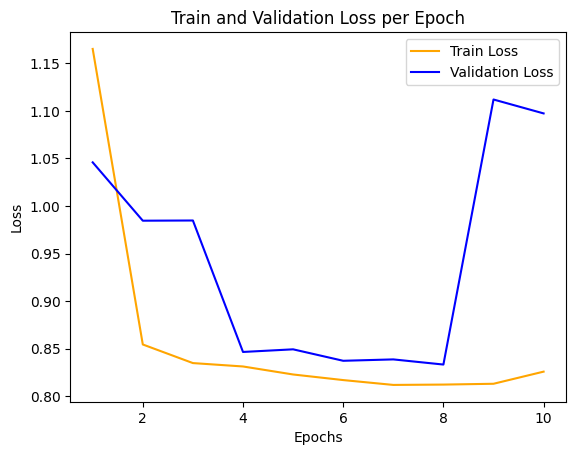

In [87]:
# Generate x-axis values (epochs)
epochs = range(1, len(train_epoch_losses) + 1)
# Plotting
plt.plot(epochs, train_epoch_losses, 'orange', label='Train Loss')
plt.plot(epochs, test_epoch_losses, 'b', label='Validation Loss')
# Adding labels and title
plt.title('Train and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Display the plot
plt.show()

## Testing - Metrics

In [89]:
# Define a model instance
trainedVQAmodel = VQAModel(resnet, visualBert, tokenizer)
# Load trained model from Google Drive
model_path = '/content/drive/MyDrive/TFG Juan Villanueva/trained_vqa_model4_imageLoss_epoch8.pth'
try:
    state_dict = torch.load(model_path, map_location=device)
    # Assign the loaded state dictionary to the model
    trainedVQAmodel.load_state_dict(state_dict)
    print("Model loaded successfully!")
except FileNotFoundError:
    print(f"File not found at path: {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


In [90]:
outputs, avg_test_loss = test(trainedVQAmodel, dataloaders_test, image_features_dataloaders_test, id2label, label2id)

Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:24<00:00,  4.68s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [02:03<00:00,  6.16s/batch]


In [92]:
outputs[0][1]

[{'Batch ID': 0,
  'Image ID': 0,
  'Question': 'How is the global pattern?',
  'Ground Truth': 'The global pattern of the lesion is undefined.',
  'Prediction': 'The global pattern of the lesion is diffuse reticular.'},
 {'Batch ID': 0,
  'Image ID': 0,
  'Question': 'Can you describe the overall pattern?',
  'Ground Truth': 'The global pattern of the lesion is undefined.',
  'Prediction': 'The global pattern of the lesion is diffuse reticular.'},
 {'Batch ID': 0,
  'Image ID': 0,
  'Question': 'Describe the pattern observed globally.',
  'Ground Truth': 'The global pattern of the lesion is undefined.',
  'Prediction': 'The global pattern of the lesion is diffuse reticular.'},
 {'Batch ID': 0,
  'Image ID': 0,
  'Question': 'What is the pattern like throughout the lesion?',
  'Ground Truth': 'The global pattern of the lesion is undefined.',
  'Prediction': 'The global pattern of the lesion is diffuse reticular.'},
 {'Batch ID': 0,
  'Image ID': 0,
  'Question': 'What patterns are pres

In [ ]:
# attentions[0].size()

In [ ]:
# inputs = tokenizer.encode(questions[image_idx,question_idx],
#                           return_token_type_ids=True,
#                           return_tensors='pt')
# inputs

In [ ]:
# tokens = tokenizer.convert_ids_to_tokens(inputs[0])
# tokens

In [ ]:
# # Tokenize image features
# tokenized_features = []
# for i in range(7):
#     for j in range(7):
#         # Convert indices to token format
#         token = f'Feature {i+1}x{j+1}'
#         tokenized_features.append(token)

In [ ]:
# tokens_concatenated = tokens + tokenized_features
# len(tokens_concatenated)

58

In [ ]:
# tokens_concatenated

In [ ]:
# head_view(attentions, tokens_concatenated)

In [ ]:
# # Reshape attentions tensor to [12, 58, 58] to iterate over each attention head
# attentions = attentions[0].squeeze(0)

# # Plot heatmap for each attention head
# for head_index in range(attentions.size(0)):
#     # Get attention values for the current head
#     attention_values = attentions[head_index].cpu().numpy()

#     # Plot heatmap
#     plt.figure(figsize=(8, 6))
#     plt.imshow(attention_values, cmap='viridis', interpolation='nearest')
#     plt.colorbar()
#     plt.title(f'Attention Heatmap - Head {head_index + 1}')
#     plt.xlabel('Tokens')
#     plt.ylabel('Tokens')
#     plt.show()

In [ ]:
# # Extract attention values between sentence tokens and image feature placeholders
# token_attentions = attentions[:, :, :9, 9:]

# # Plot heatmap for each attention head
# num_heads = token_attentions.size(1)
# plt.figure(figsize=(15, 10))
# for head_index in range(num_heads):
#     plt.subplot(3, 4, head_index + 1)
#     sns.heatmap(token_attentions[0, head_index].T.cpu().numpy(), cmap='viridis', annot=True,
#                 xticklabels=tokens,
#                 yticklabels= tokenized_features)
#     plt.title(f'Attention Head {head_index + 1}')
#     plt.xlabel('Sentence Tokens')
#     plt.ylabel('Image Features')
# plt.tight_layout()
# plt.show()

In [ ]:
# predictions = []
# for image_idx in range(len(outputs)):
#   image_answers = []
#   for output in outputs[image_idx]:
#       logits = output.logits
#       probabilities = torch.softmax(logits, dim=-1)  # Apply softmax along the last dimension
#       pred_index = torch.argmax(probabilities, dim=-1)  # Get the index of the maximum probability
#       pred_label = id2label[pred_index.item()]
#       image_answers.append(pred_label)
#   predictions.append(image_answers)
# predictions